In [1]:
import pickle
import pandas as pd
import polars as pl

import warnings
warnings.filterwarnings('ignore')

from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

import numpy as np
import minisom
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
kdprov='32'

In [3]:
# Parameters
kdprov = 18


In [4]:
print('===============================================')
print('READ THE DATA')
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH.pkl','rb') as file:
    df_training_vh=pickle.load(file)
print('FINISH LOAD DATA')

READ THE DATA


FINISH LOAD DATA


In [5]:
df_training_vh.head(2)

idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,VH_28,VH_27,VH_26,VH_25,VH_24,VH_23,VH_22,VH_21,VH_20,VH_19,VH_18,VH_17,VH_16,VH_15,VH_14,VH_13,VH_12,VH_11,VH_10,VH_9,VH_8,VH_7,VH_6,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance
str,str,str,i64,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32,f64
"""180803002A1#01""","""180803002A1""","""180803002""",1,"""2022_03""",6,"""NP""","""48MWA""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""1808""",2,0.0
"""180803002A1#02""","""180803002A1""","""180803002""",1,"""2022_03""",6,"""NP""","""48MWA""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""1808""",2,0.0


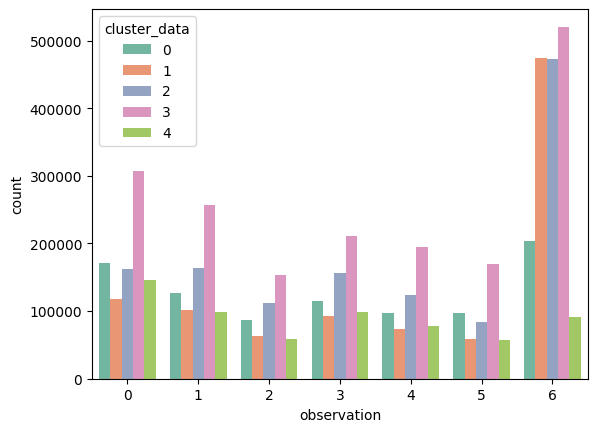

In [6]:
ls_col=['idpoint','nth','observation','periode','idsubsegment','idsegment','cluster_data']
VH_=[f'VH_{30-i}' for i in range(0,31)]
ls_col.extend(VH_)

sns.countplot(x='observation', hue='cluster_data', data=df_training_vh.to_pandas(),palette=sns.color_palette("Set2"))
# Step 4: Show the plot
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_data_.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
## Applying the cluster !
dict_som={}
for cl in df_training_vh.to_pandas().cluster_data.unique():
    print('Running For Cluster:',cl)
    pl_cl=df_training_vh.filter(pl.col('cluster_data')==cl).select(VH_).to_numpy()
    print(pl_cl.shape)
    print('RUN SOM WITH EUCLIDEANS DISTANCE BASED')
    m_neurons = 20
    n_neurons = 20
    som = minisom.MiniSom(n_neurons, m_neurons, pl_cl.shape[1], sigma=1, 
                      learning_rate=.05, random_seed=1234)
    som.random_weights_init(pl_cl)
    som.train_batch(pl_cl, 1000, verbose=True) 
    dict_som[str(cl)]={'som_model':som}#,'means':means,'stds':stds}

Running For Cluster: 2


(1272900, 31)
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [ 1000 / 1000 ] 100% - 0:00:00 left 


 quantization error: 4.263861457159979
Running For Cluster: 1
(982000, 31)
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [  187 / 1000 ]  19% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 


 quantization error: 5.128156958278114
Running For Cluster: 0
(897550, 31)
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [  556 / 1000 ]  56% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 


 quantization error: 7.695268576524752
Running For Cluster: 4
(627850, 31)
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [  534 / 1000 ]  53% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 


 quantization error: 8.174462259061674
Running For Cluster: 3


(1812975, 31)
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [  820 / 1000 ]  82% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 


 quantization error: 8.192403724938888


In [8]:
from tqdm import tqdm
clusters = df_training_vh.to_pandas().cluster_data.unique()
pl_cl_after_som=pl.DataFrame()
dict_winner={}
for cl in clusters:
    print('Running For Cluster:', cl)
    pl_cl = df_training_vh.filter(pl.col('cluster_data') == cl)
    pl_cl_n=pl_cl.select(VH_).to_numpy()
    winner_a = []
    for index, row in tqdm(enumerate(pl_cl_n)):
        a = dict_som[str(cl)]['som_model'].winner(row)
        winner_a.append(f'R{a[0]}C{a[1]}')
    df_=pl_cl.to_pandas()
    df_['winner']=winner_a
    dict_winner[str(cl)]={'winner':df_}

Running For Cluster: 2


0it [00:00, ?it/s]

1566it [00:00, 15657.89it/s]

3328it [00:00, 16805.65it/s]

5101it [00:00, 17224.66it/s]

6887it [00:00, 17472.71it/s]

8638it [00:00, 17485.07it/s]

10387it [00:00, 17182.53it/s]

12151it [00:00, 17329.06it/s]

13925it [00:00, 17455.97it/s]

15720it [00:00, 17606.18it/s]

17492it [00:01, 17639.04it/s]

19257it [00:01, 17619.83it/s]

21052it [00:01, 17719.40it/s]

22825it [00:01, 17532.39it/s]

24620it [00:01, 17655.68it/s]

26387it [00:01, 17437.18it/s]

28132it [00:01, 17101.99it/s]

29844it [00:01, 15610.01it/s]

31430it [00:01, 15006.30it/s]

33038it [00:01, 15299.50it/s]

34584it [00:02, 15199.93it/s]

36126it [00:02, 15261.26it/s]

37709it [00:02, 15424.40it/s]

39258it [00:02, 15389.49it/s]

40802it [00:02, 15111.79it/s]

42351it [00:02, 15219.95it/s]

43966it [00:02, 15490.75it/s]

45550it [00:02, 15593.39it/s]

47112it [00:02, 15585.17it/s]

48686it [00:02, 15629.94it/s]

50250it [00:03, 14426.18it/s]

51712it [00:03, 14334.54it/s]

53382it [00:03, 15007.74it/s]

55141it [00:03, 15754.87it/s]

56777it [00:03, 15930.30it/s]

58426it [00:03, 16094.68it/s]

60042it [00:03, 15549.52it/s]

61798it [00:03, 16131.42it/s]

63419it [00:03, 15958.12it/s]

65177it [00:04, 16430.03it/s]

66974it [00:04, 16881.58it/s]

68769it [00:04, 17197.14it/s]

70533it [00:04, 17327.89it/s]

72324it [00:04, 17499.21it/s]

74076it [00:04, 16770.51it/s]

75808it [00:04, 16928.44it/s]

77562it [00:04, 17106.18it/s]

79340it [00:04, 17302.48it/s]

81126it [00:04, 17465.88it/s]

82913it [00:05, 17582.88it/s]

84674it [00:05, 17540.08it/s]

86446it [00:05, 17593.24it/s]

88207it [00:05, 17555.89it/s]

89977it [00:05, 17598.05it/s]

91738it [00:05, 17535.70it/s]

93522it [00:05, 17625.26it/s]

95324it [00:05, 17741.85it/s]

97099it [00:05, 17738.17it/s]

98873it [00:05, 17628.15it/s]

100656it [00:06, 17686.01it/s]

102425it [00:06, 16134.05it/s]

104065it [00:06, 14862.16it/s]

105585it [00:06, 14302.75it/s]

107039it [00:06, 13912.06it/s]

108446it [00:06, 13725.23it/s]

110238it [00:06, 14880.72it/s]

111985it [00:06, 15611.65it/s]

113563it [00:06, 14668.03it/s]

115051it [00:07, 14724.37it/s]

116725it [00:07, 15296.36it/s]

118500it [00:07, 16002.57it/s]

120293it [00:07, 16564.02it/s]

122095it [00:07, 16990.29it/s]

123802it [00:07, 16478.41it/s]

125563it [00:07, 16805.01it/s]

127337it [00:07, 17077.76it/s]

129140it [00:07, 17356.45it/s]

130894it [00:07, 17409.03it/s]

132649it [00:08, 17449.37it/s]

134397it [00:08, 17343.13it/s]

136161it [00:08, 17429.80it/s]

137941it [00:08, 17539.12it/s]

139696it [00:08, 17458.63it/s]

141443it [00:08, 17019.69it/s]

143148it [00:08, 16957.66it/s]

144898it [00:08, 17114.40it/s]

146652it [00:08, 17238.38it/s]

148433it [00:08, 17407.41it/s]

150175it [00:09, 17382.51it/s]

151957it [00:09, 17511.00it/s]

153745it [00:09, 17618.59it/s]

155524it [00:09, 17667.28it/s]

157292it [00:09, 17561.82it/s]

159058it [00:09, 17590.40it/s]

160826it [00:09, 17616.64it/s]

162609it [00:09, 17679.56it/s]

164401it [00:09, 17750.22it/s]

166177it [00:10, 17698.50it/s]

167947it [00:10, 17353.04it/s]

169684it [00:10, 17310.22it/s]

171417it [00:10, 17167.86it/s]

173135it [00:10, 17125.00it/s]

174920it [00:10, 17337.68it/s]

176700it [00:10, 17472.35it/s]

178507it [00:10, 17650.05it/s]

180304it [00:10, 17743.45it/s]

182079it [00:10, 17654.19it/s]

183853it [00:11, 17675.46it/s]

185621it [00:11, 17035.41it/s]

187391it [00:11, 17227.94it/s]

189118it [00:11, 17190.46it/s]

190903it [00:11, 17382.85it/s]

192684it [00:11, 17508.52it/s]

194442it [00:11, 17526.62it/s]

196196it [00:11, 17259.08it/s]

197924it [00:11, 16242.66it/s]

199629it [00:11, 16471.72it/s]

201409it [00:12, 16854.03it/s]

203174it [00:12, 17083.70it/s]

204895it [00:12, 17120.34it/s]

206676it [00:12, 17323.75it/s]

208412it [00:12, 17252.18it/s]

210140it [00:12, 16945.92it/s]

211838it [00:12, 16916.84it/s]

213532it [00:12, 16434.01it/s]

215266it [00:12, 16694.17it/s]

216939it [00:12, 15932.02it/s]

218541it [00:13, 15098.53it/s]

220177it [00:13, 15448.52it/s]

221955it [00:13, 16109.35it/s]

223679it [00:13, 16435.04it/s]

225332it [00:13, 16008.47it/s]

226941it [00:13, 15189.04it/s]

228473it [00:13, 14454.01it/s]

229931it [00:13, 14023.00it/s]

231343it [00:13, 14047.06it/s]

233111it [00:14, 15074.26it/s]

234792it [00:14, 15572.04it/s]

236359it [00:14, 15248.18it/s]

238086it [00:14, 15831.54it/s]

239795it [00:14, 16197.53it/s]

241421it [00:14, 16187.72it/s]

243189it [00:14, 16627.23it/s]

244861it [00:14, 16652.44it/s]

246529it [00:14, 16246.84it/s]

248261it [00:14, 16560.68it/s]

250009it [00:15, 16831.59it/s]

251731it [00:15, 16945.62it/s]

253488it [00:15, 17128.67it/s]

255203it [00:15, 17035.14it/s]

256934it [00:15, 17115.74it/s]

258647it [00:15, 16707.33it/s]

260398it [00:15, 16941.30it/s]

262110it [00:15, 16992.42it/s]

263829it [00:15, 17048.33it/s]

265610it [00:15, 17274.51it/s]

267339it [00:16, 17210.00it/s]

269061it [00:16, 16549.97it/s]

270722it [00:16, 15924.39it/s]

272322it [00:16, 15552.23it/s]

274090it [00:16, 16155.10it/s]

275713it [00:16, 16153.53it/s]

277379it [00:16, 16298.43it/s]

279105it [00:16, 16578.38it/s]

280801it [00:16, 16689.88it/s]

282473it [00:17, 15121.11it/s]

284155it [00:17, 15591.56it/s]

285887it [00:17, 16079.96it/s]

287680it [00:17, 16612.09it/s]

289428it [00:17, 16864.09it/s]

291177it [00:17, 17045.32it/s]

292891it [00:17, 16675.98it/s]

294603it [00:17, 16804.18it/s]

296361it [00:17, 17029.81it/s]

298126it [00:17, 17210.98it/s]

299900it [00:18, 17367.76it/s]

301640it [00:18, 17237.03it/s]

303389it [00:18, 17309.92it/s]

305122it [00:18, 17242.15it/s]

306848it [00:18, 17215.20it/s]

308573it [00:18, 17221.47it/s]

310298it [00:18, 17229.27it/s]

312022it [00:18, 17137.60it/s]

313737it [00:18, 16763.49it/s]

315416it [00:19, 16416.31it/s]

317060it [00:19, 16085.45it/s]

318786it [00:19, 16423.90it/s]

320470it [00:19, 16543.52it/s]

322218it [00:19, 16818.89it/s]

323918it [00:19, 16869.51it/s]

325607it [00:19, 16727.49it/s]

327281it [00:19, 16380.04it/s]

329043it [00:19, 16742.33it/s]

330763it [00:19, 16875.33it/s]

332453it [00:20, 16671.49it/s]

334166it [00:20, 16804.48it/s]

335860it [00:20, 16843.26it/s]

337553it [00:20, 16868.12it/s]

339241it [00:20, 16821.51it/s]

340926it [00:20, 16829.01it/s]

342685it [00:20, 17055.85it/s]

344391it [00:20, 15437.05it/s]

345965it [00:20, 15507.05it/s]

347700it [00:20, 16029.18it/s]

349423it [00:21, 16375.50it/s]

351075it [00:21, 15990.79it/s]

352793it [00:21, 16333.68it/s]

354522it [00:21, 16610.42it/s]

356190it [00:21, 16621.05it/s]

357927it [00:21, 16841.78it/s]

359615it [00:21, 16797.01it/s]

361336it [00:21, 16918.34it/s]

363048it [00:21, 16977.11it/s]

364748it [00:21, 16599.99it/s]

366469it [00:22, 16776.85it/s]

368203it [00:22, 16942.93it/s]

369936it [00:22, 17057.02it/s]

371644it [00:22, 16880.81it/s]

373334it [00:22, 16390.17it/s]

374977it [00:22, 16369.21it/s]

376735it [00:22, 16722.01it/s]

378410it [00:22, 16165.73it/s]

380032it [00:22, 14856.06it/s]

381723it [00:23, 15418.91it/s]

383285it [00:23, 15383.61it/s]

384951it [00:23, 15748.19it/s]

386709it [00:23, 16277.66it/s]

388397it [00:23, 16451.64it/s]

390130it [00:23, 16709.62it/s]

391807it [00:23, 16634.50it/s]

393475it [00:23, 16103.30it/s]

395104it [00:23, 16156.52it/s]

396869it [00:23, 16591.75it/s]

398624it [00:24, 16873.62it/s]

400315it [00:24, 16853.37it/s]

402035it [00:24, 16952.57it/s]

403745it [00:24, 16994.55it/s]

405471it [00:24, 17072.25it/s]

407186it [00:24, 17092.93it/s]

408899it [00:24, 17103.33it/s]

410610it [00:24, 16939.20it/s]

412323it [00:24, 16754.02it/s]

414000it [00:24, 16466.93it/s]

415649it [00:25, 16032.49it/s]

417255it [00:25, 15771.59it/s]

418835it [00:25, 15559.92it/s]

420576it [00:25, 16094.59it/s]

422321it [00:25, 16489.90it/s]

424029it [00:25, 16661.74it/s]

425726it [00:25, 16752.08it/s]

427404it [00:25, 16751.27it/s]

429107it [00:25, 16832.48it/s]

430876it [00:25, 17087.20it/s]

432655it [00:26, 17295.61it/s]

434442it [00:26, 17466.82it/s]

436190it [00:26, 17323.96it/s]

437923it [00:26, 16870.55it/s]

439645it [00:26, 16970.61it/s]

441393it [00:26, 17119.53it/s]

443107it [00:26, 16933.62it/s]

444802it [00:26, 16443.41it/s]

446450it [00:26, 16148.72it/s]

448128it [00:27, 16330.62it/s]

449810it [00:27, 16470.38it/s]

451543it [00:27, 16722.95it/s]

453228it [00:27, 16759.74it/s]

454923it [00:27, 16813.72it/s]

456685it [00:27, 17052.45it/s]

458392it [00:27, 17020.26it/s]

460158it [00:27, 17208.24it/s]

461906it [00:27, 17287.52it/s]

463644it [00:27, 17312.42it/s]

465415it [00:28, 17430.78it/s]

467159it [00:28, 16265.35it/s]

468884it [00:28, 16543.93it/s]

470551it [00:28, 15880.63it/s]

472152it [00:28, 15908.17it/s]

473949it [00:28, 16501.56it/s]

475641it [00:28, 16622.01it/s]

477331it [00:28, 16701.79it/s]

479111it [00:28, 17026.14it/s]

480878it [00:28, 17216.92it/s]

482637it [00:29, 17324.77it/s]

484372it [00:29, 17278.12it/s]

486141it [00:29, 17397.01it/s]

487882it [00:29, 17158.33it/s]

489600it [00:29, 16524.83it/s]

491258it [00:29, 16108.53it/s]

492962it [00:29, 16374.16it/s]

494698it [00:29, 16659.72it/s]

496465it [00:29, 16954.04it/s]

498231it [00:29, 17159.57it/s]

499972it [00:30, 17231.85it/s]

501793it [00:30, 17520.18it/s]

503547it [00:30, 17446.53it/s]

505293it [00:30, 17323.03it/s]

507080it [00:30, 17484.28it/s]

508862it [00:30, 17583.12it/s]

510675it [00:30, 17743.44it/s]

512463it [00:30, 17783.80it/s]

514242it [00:30, 17676.86it/s]

516023it [00:30, 17713.82it/s]

517795it [00:31, 17580.45it/s]

519554it [00:31, 17369.85it/s]

521292it [00:31, 16765.92it/s]

523074it [00:31, 17069.98it/s]

524851it [00:31, 17271.82it/s]

526582it [00:31, 16263.73it/s]

528339it [00:31, 16631.77it/s]

530021it [00:31, 16684.87it/s]

531698it [00:31, 16451.10it/s]

533392it [00:32, 16590.86it/s]

535140it [00:32, 16850.37it/s]

536829it [00:32, 16270.11it/s]

538463it [00:32, 16122.59it/s]

540115it [00:32, 16236.07it/s]

541867it [00:32, 16610.42it/s]

543633it [00:32, 16918.19it/s]

545360it [00:32, 17019.62it/s]

547115it [00:32, 17175.81it/s]

548869it [00:32, 17283.74it/s]

550633it [00:33, 17388.59it/s]

552401it [00:33, 17475.05it/s]

554150it [00:33, 17322.20it/s]

555914it [00:33, 17416.16it/s]

557669it [00:33, 17453.28it/s]

559415it [00:33, 17327.48it/s]

561149it [00:33, 16308.59it/s]

562919it [00:33, 16704.27it/s]

564717it [00:33, 17072.84it/s]

566433it [00:33, 16595.70it/s]

568101it [00:34, 15893.07it/s]

569823it [00:34, 16266.49it/s]

571600it [00:34, 16698.69it/s]

573359it [00:34, 16955.44it/s]

575103it [00:34, 17097.37it/s]

576818it [00:34, 15860.03it/s]

578523it [00:34, 16193.50it/s]

580289it [00:34, 16612.16it/s]

581964it [00:34, 16166.30it/s]

583749it [00:35, 16649.21it/s]

585502it [00:35, 16904.14it/s]

587254it [00:35, 17083.92it/s]

589041it [00:35, 17314.71it/s]

590777it [00:35, 16948.66it/s]

592477it [00:35, 16465.17it/s]

594214it [00:35, 16724.70it/s]

595985it [00:35, 17010.94it/s]

597691it [00:35, 16621.52it/s]

599358it [00:35, 16596.87it/s]

601021it [00:36, 16107.92it/s]

602802it [00:36, 16597.18it/s]

604467it [00:36, 16549.36it/s]

606126it [00:36, 16486.60it/s]

607925it [00:36, 16925.47it/s]

609739it [00:36, 17283.35it/s]

611527it [00:36, 17457.45it/s]

613275it [00:36, 16993.32it/s]

615069it [00:36, 17268.96it/s]

616800it [00:37, 16092.07it/s]

618589it [00:37, 16596.85it/s]

620419it [00:37, 17084.02it/s]

622193it [00:37, 17274.33it/s]

623931it [00:37, 17085.58it/s]

625660it [00:37, 17144.45it/s]

627380it [00:37, 17113.07it/s]

629151it [00:37, 17285.64it/s]

630909it [00:37, 17370.53it/s]

632649it [00:37, 17376.65it/s]

634444it [00:38, 17546.17it/s]

636241it [00:38, 17672.21it/s]

638009it [00:38, 17239.89it/s]

639763it [00:38, 17326.47it/s]

641498it [00:38, 17249.93it/s]

643282it [00:38, 17413.10it/s]

645085it [00:38, 17594.56it/s]

646846it [00:38, 17427.60it/s]

648590it [00:38, 16699.28it/s]

650317it [00:38, 16861.60it/s]

652108it [00:39, 17165.18it/s]

653829it [00:39, 16837.97it/s]

655517it [00:39, 16722.34it/s]

657362it [00:39, 17226.44it/s]

659133it [00:39, 17363.80it/s]

660872it [00:39, 17070.09it/s]

662652it [00:39, 17282.35it/s]

664383it [00:39, 17233.94it/s]

666117it [00:39, 17252.58it/s]

667850it [00:39, 17274.77it/s]

669579it [00:40, 17213.25it/s]

671327it [00:40, 17291.97it/s]

673057it [00:40, 16939.48it/s]

674774it [00:40, 17006.71it/s]

676542it [00:40, 17204.70it/s]

678264it [00:40, 17106.50it/s]

680012it [00:40, 17214.21it/s]

681735it [00:40, 16979.46it/s]

683489it [00:40, 17142.62it/s]

685242it [00:40, 17256.54it/s]

686969it [00:41, 17219.75it/s]

688714it [00:41, 17285.97it/s]

690444it [00:41, 17234.09it/s]

692168it [00:41, 16770.31it/s]

693915it [00:41, 16973.02it/s]

695615it [00:41, 16662.46it/s]

697325it [00:41, 16789.39it/s]

699014it [00:41, 16818.65it/s]

700698it [00:41, 16611.14it/s]

702416it [00:42, 16776.50it/s]

704133it [00:42, 16891.55it/s]

705853it [00:42, 16982.15it/s]

707553it [00:42, 16763.60it/s]

709231it [00:42, 15538.99it/s]

711056it [00:42, 16300.28it/s]

712704it [00:42, 15583.27it/s]

714279it [00:42, 15103.63it/s]

716056it [00:42, 15846.14it/s]

717840it [00:42, 16413.35it/s]

719554it [00:43, 16623.13it/s]

721302it [00:43, 16871.67it/s]

723088it [00:43, 17161.52it/s]

724832it [00:43, 17242.69it/s]

726625it [00:43, 17445.22it/s]

728373it [00:43, 16989.17it/s]

730077it [00:43, 16933.55it/s]

731774it [00:43, 15659.76it/s]

733509it [00:43, 16131.23it/s]

735250it [00:44, 16495.08it/s]

736914it [00:44, 16082.90it/s]

738534it [00:44, 15814.62it/s]

740124it [00:44, 15742.24it/s]

741704it [00:44, 15457.82it/s]

743428it [00:44, 15971.72it/s]

745220it [00:44, 16538.90it/s]

746905it [00:44, 16629.01it/s]

748655it [00:44, 16885.24it/s]

750347it [00:44, 16734.92it/s]

752147it [00:45, 17108.45it/s]

753866it [00:45, 17129.63it/s]

755581it [00:45, 17103.93it/s]

757355it [00:45, 17293.09it/s]

759086it [00:45, 17256.73it/s]

760838it [00:45, 17334.65it/s]

762579it [00:45, 17356.43it/s]

764315it [00:45, 17305.98it/s]

766087it [00:45, 17426.88it/s]

767867it [00:45, 17534.14it/s]

769621it [00:46, 17390.94it/s]

771380it [00:46, 17448.12it/s]

773148it [00:46, 17515.04it/s]

774908it [00:46, 17537.75it/s]

776680it [00:46, 17590.30it/s]

778450it [00:46, 17621.48it/s]

780222it [00:46, 17648.49it/s]

781987it [00:46, 17582.76it/s]

783746it [00:46, 17437.68it/s]

785491it [00:46, 17246.29it/s]

787217it [00:47, 16473.49it/s]

788996it [00:47, 16850.13it/s]

790741it [00:47, 17022.02it/s]

792474it [00:47, 17109.42it/s]

794189it [00:47, 16565.80it/s]

795916it [00:47, 16769.33it/s]

797622it [00:47, 16851.74it/s]

799379it [00:47, 17061.07it/s]

801144it [00:47, 17233.46it/s]

802900it [00:47, 17328.40it/s]

804656it [00:48, 17396.07it/s]

806399it [00:48, 17404.58it/s]

808141it [00:48, 17163.26it/s]

809881it [00:48, 17231.25it/s]

811606it [00:48, 15979.53it/s]

813286it [00:48, 16209.12it/s]

815027it [00:48, 16552.70it/s]

816774it [00:48, 16819.15it/s]

818558it [00:48, 17118.43it/s]

820277it [00:49, 16978.13it/s]

821984it [00:49, 17002.73it/s]

823775it [00:49, 17270.20it/s]

825505it [00:49, 17170.24it/s]

827224it [00:49, 16904.04it/s]

828984it [00:49, 17107.25it/s]

830697it [00:49, 16338.64it/s]

832339it [00:49, 16335.47it/s]

834112it [00:49, 16739.51it/s]

835822it [00:49, 16844.19it/s]

837600it [00:50, 17119.73it/s]

839395it [00:50, 17363.20it/s]

841134it [00:50, 16211.72it/s]

842917it [00:50, 16669.36it/s]

844738it [00:50, 17112.32it/s]

846461it [00:50, 16680.37it/s]

848139it [00:50, 16628.30it/s]

849818it [00:50, 16672.47it/s]

851491it [00:50, 16297.41it/s]

853126it [00:50, 16140.67it/s]

854744it [00:51, 16002.31it/s]

856489it [00:51, 16422.98it/s]

858266it [00:51, 16818.80it/s]

860057it [00:51, 17138.92it/s]

861811it [00:51, 17256.11it/s]

863539it [00:51, 17154.06it/s]

865265it [00:51, 17182.46it/s]

867015it [00:51, 17274.75it/s]

868789it [00:51, 17412.04it/s]

870553it [00:51, 17478.72it/s]

872302it [00:52, 17367.81it/s]

874040it [00:52, 17320.60it/s]

875773it [00:52, 17248.11it/s]

877570it [00:52, 17457.02it/s]

879317it [00:52, 17349.99it/s]

881072it [00:52, 17406.60it/s]

882843it [00:52, 17496.25it/s]

884642it [00:52, 17641.24it/s]

886407it [00:52, 17463.66it/s]

888154it [00:53, 16401.38it/s]

889843it [00:53, 16537.43it/s]

891636it [00:53, 16939.90it/s]

893400it [00:53, 17142.75it/s]

895147it [00:53, 17238.57it/s]

896918it [00:53, 17376.62it/s]

898698it [00:53, 17500.02it/s]

900500it [00:53, 17654.21it/s]

902268it [00:53, 17533.64it/s]

904023it [00:53, 17536.92it/s]

905808it [00:54, 17628.62it/s]

907624it [00:54, 17785.29it/s]

909420it [00:54, 17835.45it/s]

911230it [00:54, 17913.64it/s]

913035it [00:54, 17953.03it/s]

914831it [00:54, 17925.59it/s]

916630it [00:54, 17943.78it/s]

918425it [00:54, 17879.56it/s]

920214it [00:54, 17765.67it/s]

921991it [00:54, 17702.04it/s]

923762it [00:55, 17698.20it/s]

925532it [00:55, 17555.29it/s]

927334it [00:55, 17692.70it/s]

929118it [00:55, 17734.08it/s]

930930it [00:55, 17846.77it/s]

932750it [00:55, 17950.41it/s]

934546it [00:55, 17759.90it/s]

936358it [00:55, 17865.48it/s]

938146it [00:55, 17864.08it/s]

939933it [00:55, 17823.83it/s]

941728it [00:56, 17860.98it/s]

943515it [00:56, 17803.62it/s]

945299it [00:56, 17811.55it/s]

947109it [00:56, 17895.90it/s]

948899it [00:56, 17213.96it/s]

950626it [00:56, 16755.96it/s]

952308it [00:56, 16410.26it/s]

953954it [00:56, 15989.19it/s]

955557it [00:56, 15667.80it/s]

957160it [00:56, 15770.00it/s]

958740it [00:57, 15707.34it/s]

960333it [00:57, 15771.17it/s]

961912it [00:57, 15520.07it/s]

963489it [00:57, 15589.49it/s]

965052it [00:57, 15598.83it/s]

966613it [00:57, 14905.96it/s]

968130it [00:57, 14978.88it/s]

969633it [00:57, 14966.86it/s]

971133it [00:57, 14911.47it/s]

972627it [00:58, 14848.08it/s]

974276it [00:58, 15304.78it/s]

975959it [00:58, 15754.43it/s]

977537it [00:58, 15663.02it/s]

979105it [00:58, 15253.39it/s]

980783it [00:58, 15698.34it/s]

982551it [00:58, 16279.55it/s]

984183it [00:58, 15937.43it/s]

985967it [00:58, 16491.64it/s]

987737it [00:58, 16847.40it/s]

989444it [00:59, 16911.78it/s]

991138it [00:59, 16853.45it/s]

992900it [00:59, 17077.24it/s]

994649it [00:59, 17198.36it/s]

996407it [00:59, 17311.02it/s]

998158it [00:59, 17370.03it/s]

999896it [00:59, 17361.08it/s]

1001651it [00:59, 17414.82it/s]

1003393it [00:59, 17199.73it/s]

1005114it [00:59, 17064.85it/s]

1006840it [01:00, 17121.21it/s]

1008582it [01:00, 17207.04it/s]

1010370it [01:00, 17404.69it/s]

1012162it [01:00, 17557.67it/s]

1013919it [01:00, 16996.78it/s]

1015649it [01:00, 17083.56it/s]

1017445it [01:00, 17338.79it/s]

1019187it [01:00, 17359.70it/s]

1020930it [01:00, 17377.60it/s]

1022715it [01:00, 17517.45it/s]

1024485it [01:01, 17570.56it/s]

1026261it [01:01, 17625.06it/s]

1028032it [01:01, 17648.80it/s]

1029798it [01:01, 17334.50it/s]

1031533it [01:01, 17029.03it/s]

1033342it [01:01, 17339.14it/s]

1035136it [01:01, 17515.44it/s]

1036890it [01:01, 17522.15it/s]

1038644it [01:01, 17411.66it/s]

1040392it [01:01, 17430.70it/s]

1042154it [01:02, 17486.43it/s]

1043904it [01:02, 17288.59it/s]

1045634it [01:02, 17124.67it/s]

1047405it [01:02, 17294.72it/s]

1049191it [01:02, 17459.78it/s]

1050951it [01:02, 17499.18it/s]

1052702it [01:02, 17371.14it/s]

1054440it [01:02, 16760.67it/s]

1056177it [01:02, 16936.67it/s]

1057963it [01:02, 17205.54it/s]

1059687it [01:03, 17164.69it/s]

1061434it [01:03, 17252.15it/s]

1063203it [01:03, 17381.16it/s]

1064949it [01:03, 17403.11it/s]

1066691it [01:03, 17351.09it/s]

1068445it [01:03, 17406.29it/s]

1070209it [01:03, 17473.62it/s]

1072003it [01:03, 17612.48it/s]

1073765it [01:03, 17593.98it/s]

1075525it [01:03, 17581.26it/s]

1077301it [01:04, 17632.25it/s]

1079065it [01:04, 16574.98it/s]

1080736it [01:04, 16577.55it/s]

1082554it [01:04, 17040.46it/s]

1084373it [01:04, 17375.56it/s]

1086154it [01:04, 17501.36it/s]

1087918it [01:04, 17539.33it/s]

1089697it [01:04, 17609.24it/s]

1091461it [01:04, 17604.04it/s]

1093224it [01:05, 17434.72it/s]

1094969it [01:05, 17433.66it/s]

1096778it [01:05, 17626.81it/s]

1098542it [01:05, 17071.56it/s]

1100254it [01:05, 16775.82it/s]

1101935it [01:05, 16520.60it/s]

1103590it [01:05, 16272.14it/s]

1105220it [01:05, 15448.87it/s]

1106773it [01:05, 14776.51it/s]

1108346it [01:05, 15039.35it/s]

1110088it [01:06, 15714.56it/s]

1111799it [01:06, 16116.10it/s]

1113576it [01:06, 16596.14it/s]

1115243it [01:06, 16237.03it/s]

1117016it [01:06, 16670.88it/s]

1118801it [01:06, 17015.69it/s]

1120508it [01:06, 16457.68it/s]

1122269it [01:06, 16788.97it/s]

1124053it [01:06, 17094.94it/s]

1125848it [01:07, 17344.48it/s]

1127630it [01:07, 17482.24it/s]

1129382it [01:07, 17391.03it/s]

1131124it [01:07, 17366.67it/s]

1132863it [01:07, 17361.33it/s]

1134633it [01:07, 17461.28it/s]

1136380it [01:07, 17462.49it/s]

1138127it [01:07, 16528.08it/s]

1139791it [01:07, 16288.06it/s]

1141440it [01:07, 16345.48it/s]

1143080it [01:08, 16283.77it/s]

1144713it [01:08, 15039.19it/s]

1146400it [01:08, 15548.62it/s]

1148175it [01:08, 16173.00it/s]

1149868it [01:08, 16389.45it/s]

1151609it [01:08, 16686.36it/s]

1153319it [01:08, 16807.30it/s]

1155107it [01:08, 17123.98it/s]

1156825it [01:08, 17047.38it/s]

1158562it [01:08, 17137.04it/s]

1160306it [01:09, 17224.05it/s]

1162031it [01:09, 17048.73it/s]

1163738it [01:09, 16664.85it/s]

1165408it [01:09, 15938.37it/s]

1167010it [01:09, 15165.37it/s]

1168537it [01:09, 14801.53it/s]

1170025it [01:09, 14547.07it/s]

1171685it [01:09, 15124.53it/s]

1173303it [01:09, 15424.63it/s]

1174982it [01:10, 15819.94it/s]

1176744it [01:10, 16345.76it/s]

1178449it [01:10, 16551.64it/s]

1180118it [01:10, 16589.94it/s]

1181780it [01:10, 16187.59it/s]

1183446it [01:10, 16323.64it/s]

1185082it [01:10, 16082.15it/s]

1186693it [01:10, 15266.66it/s]

1188402it [01:10, 15784.07it/s]

1190149it [01:10, 16269.63it/s]

1191902it [01:11, 16635.64it/s]

1193573it [01:11, 16585.15it/s]

1195305it [01:11, 16799.14it/s]

1197019it [01:11, 16898.93it/s]

1198712it [01:11, 16847.03it/s]

1200509it [01:11, 17178.96it/s]

1202229it [01:11, 16958.18it/s]

1203929it [01:11, 16968.81it/s]

1205628it [01:11, 16707.27it/s]

1207331it [01:11, 16799.98it/s]

1209042it [01:12, 16890.19it/s]

1210732it [01:12, 16768.61it/s]

1212468it [01:12, 16940.93it/s]

1214231it [01:12, 17144.93it/s]

1215947it [01:12, 17136.90it/s]

1217662it [01:12, 15652.41it/s]

1219444it [01:12, 16257.70it/s]

1221224it [01:12, 16698.13it/s]

1223011it [01:12, 17034.66it/s]

1224734it [01:13, 17089.85it/s]

1226472it [01:13, 17173.38it/s]

1228237it [01:13, 17314.03it/s]

1229993it [01:13, 17385.72it/s]

1231740it [01:13, 17409.95it/s]

1233484it [01:13, 17139.59it/s]

1235201it [01:13, 15517.73it/s]

1236903it [01:13, 15932.32it/s]

1238693it [01:13, 16486.91it/s]

1240468it [01:13, 16848.42it/s]

1242221it [01:14, 17046.09it/s]

1243981it [01:14, 17207.61it/s]

1245711it [01:14, 17231.68it/s]

1247459it [01:14, 17302.39it/s]

1249208it [01:14, 17355.12it/s]

1250947it [01:14, 16412.12it/s]

1252601it [01:14, 15873.30it/s]

1254377it [01:14, 16405.99it/s]

1256134it [01:14, 16738.92it/s]

1257924it [01:14, 17074.39it/s]

1259739it [01:15, 17387.85it/s]

1261522it [01:15, 17517.84it/s]

1263278it [01:15, 16755.33it/s]

1265007it [01:15, 16907.33it/s]

1266805it [01:15, 17218.50it/s]

1268591it [01:15, 17405.56it/s]

1270337it [01:15, 17357.76it/s]

1272076it [01:15, 17321.34it/s]

1272900it [01:15, 16781.88it/s]

Running For Cluster: 1


0it [00:00, ?it/s]

1019it [00:00, 10185.35it/s]

2806it [00:00, 14697.74it/s]

4591it [00:00, 16132.36it/s]

6205it [00:00, 16033.37it/s]

7955it [00:00, 16544.60it/s]

9661it [00:00, 16714.89it/s]

11382it [00:00, 16875.26it/s]

13143it [00:00, 17106.06it/s]

14896it [00:00, 17236.21it/s]

16620it [00:01, 15943.29it/s]

18233it [00:01, 15525.61it/s]

19958it [00:01, 16017.43it/s]

21573it [00:01, 15981.17it/s]

23264it [00:01, 16250.10it/s]

24903it [00:01, 16290.42it/s]

26545it [00:01, 16327.71it/s]

28319it [00:01, 16744.46it/s]

30094it [00:01, 17042.39it/s]

31801it [00:01, 16983.16it/s]

33501it [00:02, 16729.97it/s]

35176it [00:02, 16481.08it/s]

36826it [00:02, 16195.45it/s]

38448it [00:02, 16109.40it/s]

40091it [00:02, 16201.40it/s]

41748it [00:02, 16308.24it/s]

43417it [00:02, 16420.87it/s]

45088it [00:02, 16504.46it/s]

46740it [00:02, 16268.80it/s]

48368it [00:02, 15969.59it/s]

49967it [00:03, 15235.97it/s]

51498it [00:03, 15149.84it/s]

53216it [00:03, 15733.55it/s]

54963it [00:03, 16238.26it/s]

56731it [00:03, 16661.36it/s]

58406it [00:03, 16686.69it/s]

60138it [00:03, 16871.34it/s]

61828it [00:03, 16845.23it/s]

63572it [00:03, 17021.99it/s]

65292it [00:03, 17074.08it/s]

67036it [00:04, 17180.35it/s]

68755it [00:04, 16972.85it/s]

70454it [00:04, 16018.69it/s]

72164it [00:04, 16325.02it/s]

73912it [00:04, 16658.24it/s]

75655it [00:04, 16881.73it/s]

77350it [00:04, 16818.28it/s]

79036it [00:04, 16088.71it/s]

80758it [00:04, 16412.02it/s]

82504it [00:05, 16715.36it/s]

84182it [00:05, 16628.93it/s]

85918it [00:05, 16842.45it/s]

87683it [00:05, 17079.03it/s]

89439it [00:05, 17218.45it/s]

91163it [00:05, 17110.35it/s]

92876it [00:05, 16996.73it/s]

94577it [00:05, 16707.30it/s]

96280it [00:05, 16799.10it/s]

98008it [00:05, 16940.25it/s]

99704it [00:06, 16920.40it/s]

101436it [00:06, 17036.82it/s]

103213it [00:06, 17253.04it/s]

104939it [00:06, 17183.43it/s]

106681it [00:06, 17252.90it/s]

108477it [00:06, 17462.86it/s]

110224it [00:06, 17446.35it/s]

111997it [00:06, 17530.29it/s]

113751it [00:06, 17164.85it/s]

115470it [00:06, 16967.64it/s]

117236it [00:07, 17169.91it/s]

119009it [00:07, 17333.77it/s]

120744it [00:07, 17325.88it/s]

122508it [00:07, 17418.88it/s]

124251it [00:07, 17256.51it/s]

125978it [00:07, 17238.46it/s]

127761it [00:07, 17413.55it/s]

129503it [00:07, 17285.59it/s]

131233it [00:07, 17268.58it/s]

132961it [00:07, 16917.72it/s]

134693it [00:08, 17033.37it/s]

136398it [00:08, 16779.14it/s]

138129it [00:08, 16932.72it/s]

139824it [00:08, 16908.67it/s]

141516it [00:08, 16829.47it/s]

143222it [00:08, 16894.46it/s]

144992it [00:08, 17132.11it/s]

146706it [00:08, 17107.89it/s]

148418it [00:08, 16994.76it/s]

150202it [00:08, 17245.18it/s]

151960it [00:09, 17341.52it/s]

153729it [00:09, 17442.50it/s]

155497it [00:09, 17511.82it/s]

157262it [00:09, 17551.89it/s]

159018it [00:09, 17487.86it/s]

160767it [00:09, 17445.99it/s]

162518it [00:09, 17464.17it/s]

164265it [00:09, 17313.38it/s]

165997it [00:09, 17139.55it/s]

167712it [00:09, 17131.63it/s]

169426it [00:10, 15919.70it/s]

171169it [00:10, 16344.19it/s]

172896it [00:10, 16609.54it/s]

174677it [00:10, 16955.37it/s]

176429it [00:10, 17120.41it/s]

178148it [00:10, 16884.38it/s]

179902it [00:10, 17074.98it/s]

181614it [00:10, 15949.69it/s]

183334it [00:10, 16300.47it/s]

184984it [00:11, 16354.97it/s]

186630it [00:11, 15550.85it/s]

188213it [00:11, 15627.69it/s]

189915it [00:11, 16027.87it/s]

191640it [00:11, 16382.95it/s]

193312it [00:11, 16479.22it/s]

194966it [00:11, 15690.29it/s]

196608it [00:11, 15898.14it/s]

198317it [00:11, 16242.98it/s]

199971it [00:11, 16329.35it/s]

201610it [00:12, 16049.28it/s]

203272it [00:12, 16215.58it/s]

204952it [00:12, 16387.18it/s]

206625it [00:12, 16486.32it/s]

208276it [00:12, 16469.03it/s]

209935it [00:12, 16504.58it/s]

211656it [00:12, 16711.70it/s]

213358it [00:12, 16799.84it/s]

215134it [00:12, 17084.39it/s]

216883it [00:12, 17204.80it/s]

218604it [00:13, 16614.55it/s]

220271it [00:13, 16551.51it/s]

221930it [00:13, 16561.67it/s]

223682it [00:13, 16843.37it/s]

225413it [00:13, 16980.27it/s]

227113it [00:13, 16927.27it/s]

228829it [00:13, 16993.14it/s]

230530it [00:13, 16215.61it/s]

232211it [00:13, 16386.69it/s]

233898it [00:14, 16527.52it/s]

235610it [00:14, 16699.99it/s]

237312it [00:14, 16793.97it/s]

238995it [00:14, 15304.75it/s]

240553it [00:14, 15273.94it/s]

242256it [00:14, 15771.37it/s]

243911it [00:14, 15994.86it/s]

245523it [00:14, 15966.80it/s]

247129it [00:14, 15398.16it/s]

248741it [00:14, 15604.43it/s]

250309it [00:15, 14601.68it/s]

251786it [00:15, 14478.38it/s]

253245it [00:15, 14093.37it/s]

254663it [00:15, 13591.76it/s]

256030it [00:15, 13309.19it/s]

257706it [00:15, 14275.90it/s]

259380it [00:15, 14979.41it/s]

260889it [00:15, 14704.05it/s]

262452it [00:15, 14970.24it/s]

263956it [00:16, 14866.62it/s]

265471it [00:16, 14947.07it/s]

266976it [00:16, 14976.43it/s]

268499it [00:16, 15049.29it/s]

270006it [00:16, 15008.96it/s]

271509it [00:16, 14911.26it/s]

273012it [00:16, 14943.40it/s]

274508it [00:16, 14139.02it/s]

275931it [00:16, 13971.24it/s]

277616it [00:16, 14797.57it/s]

279334it [00:17, 15490.09it/s]

281081it [00:17, 16070.85it/s]

282807it [00:17, 16420.34it/s]

284455it [00:17, 15597.47it/s]

286027it [00:17, 15624.11it/s]

287764it [00:17, 16130.99it/s]

289385it [00:17, 15812.85it/s]

290973it [00:17, 14983.38it/s]

292580it [00:17, 15287.42it/s]

294119it [00:18, 15269.35it/s]

295770it [00:18, 15628.91it/s]

297339it [00:18, 15161.89it/s]

298862it [00:18, 14311.90it/s]

300306it [00:18, 13745.71it/s]

301989it [00:18, 14599.31it/s]

303464it [00:18, 14215.91it/s]

305016it [00:18, 14583.44it/s]

306558it [00:18, 14823.46it/s]

308049it [00:18, 14501.61it/s]

309601it [00:19, 14792.41it/s]

311195it [00:19, 15127.01it/s]

312713it [00:19, 14769.59it/s]

314272it [00:19, 15006.29it/s]

315777it [00:19, 14533.59it/s]

317364it [00:19, 14917.21it/s]

319061it [00:19, 15515.40it/s]

320706it [00:19, 15787.91it/s]

322289it [00:19, 15582.19it/s]

324010it [00:20, 16060.03it/s]

325713it [00:20, 16345.27it/s]

327361it [00:20, 16382.86it/s]

329002it [00:20, 16343.08it/s]

330714it [00:20, 16573.96it/s]

332373it [00:20, 16276.87it/s]

334090it [00:20, 16537.83it/s]

335825it [00:20, 16777.94it/s]

337574it [00:20, 16987.43it/s]

339315it [00:20, 17110.65it/s]

341052it [00:21, 17186.80it/s]

342833it [00:21, 17372.71it/s]

344624it [00:21, 17531.64it/s]

346378it [00:21, 17530.47it/s]

348132it [00:21, 17344.45it/s]

349897it [00:21, 17433.60it/s]

351641it [00:21, 17432.93it/s]

353385it [00:21, 17284.74it/s]

355120it [00:21, 17301.47it/s]

356851it [00:21, 17288.12it/s]

358615it [00:22, 17391.55it/s]

360384it [00:22, 17479.18it/s]

362138it [00:22, 17495.50it/s]

363888it [00:22, 17355.89it/s]

365652it [00:22, 17438.09it/s]

367397it [00:22, 17114.70it/s]

369110it [00:22, 16864.05it/s]

370798it [00:22, 16682.61it/s]

372560it [00:22, 16953.76it/s]

374301it [00:22, 17085.39it/s]

376011it [00:23, 17081.49it/s]

377720it [00:23, 16169.90it/s]

379459it [00:23, 16517.82it/s]

381233it [00:23, 16872.62it/s]

382928it [00:23, 16290.58it/s]

384613it [00:23, 16447.64it/s]

386310it [00:23, 16598.23it/s]

388054it [00:23, 16843.12it/s]

389801it [00:23, 17027.79it/s]

391507it [00:24, 15757.62it/s]

393103it [00:24, 15369.69it/s]

394779it [00:24, 15758.40it/s]

396559it [00:24, 16342.13it/s]

398302it [00:24, 16655.27it/s]

400044it [00:24, 16877.90it/s]

401752it [00:24, 16936.50it/s]

403474it [00:24, 17019.19it/s]

405189it [00:24, 17055.99it/s]

406898it [00:24, 16833.63it/s]

408584it [00:25, 16515.01it/s]

410331it [00:25, 16792.37it/s]

412089it [00:25, 17022.84it/s]

413835it [00:25, 17151.39it/s]

415552it [00:25, 16887.10it/s]

417281it [00:25, 17003.46it/s]

418983it [00:25, 15794.02it/s]

420580it [00:25, 15716.57it/s]

422164it [00:25, 15560.27it/s]

423771it [00:25, 15703.49it/s]

425487it [00:26, 16125.59it/s]

427249it [00:26, 16562.51it/s]

428986it [00:26, 16797.75it/s]

430670it [00:26, 16289.60it/s]

432305it [00:26, 16261.86it/s]

433991it [00:26, 16435.22it/s]

435638it [00:26, 16354.69it/s]

437352it [00:26, 16583.14it/s]

439013it [00:26, 15980.84it/s]

440617it [00:27, 14787.33it/s]

442115it [00:27, 14130.67it/s]

443601it [00:27, 14328.51it/s]

445287it [00:27, 15037.94it/s]

446854it [00:27, 15214.74it/s]

448587it [00:27, 15827.38it/s]

450192it [00:27, 15889.87it/s]

451911it [00:27, 16270.86it/s]

453544it [00:27, 16077.26it/s]

455297it [00:27, 16504.93it/s]

457040it [00:28, 16778.36it/s]

458786it [00:28, 16978.40it/s]

460487it [00:28, 16699.94it/s]

462241it [00:28, 16947.51it/s]

463966it [00:28, 17034.69it/s]

465672it [00:28, 16982.98it/s]

467390it [00:28, 17038.82it/s]

469129it [00:28, 17140.41it/s]

470844it [00:28, 17014.63it/s]

472590it [00:28, 17144.92it/s]

474306it [00:29, 16426.82it/s]

476046it [00:29, 16708.21it/s]

477788it [00:29, 16913.87it/s]

479516it [00:29, 17019.12it/s]

481229it [00:29, 17049.47it/s]

482937it [00:29, 16707.95it/s]

484685it [00:29, 16932.12it/s]

486381it [00:29, 16726.57it/s]

488056it [00:29, 16628.63it/s]

489823it [00:29, 16935.14it/s]

491565it [00:30, 17075.51it/s]

493277it [00:30, 17087.37it/s]

495028it [00:30, 17212.11it/s]

496774it [00:30, 17283.98it/s]

498503it [00:30, 17002.80it/s]

500205it [00:30, 16981.26it/s]

501905it [00:30, 16489.34it/s]

503636it [00:30, 16725.57it/s]

505312it [00:30, 16472.54it/s]

507013it [00:31, 16629.20it/s]

508721it [00:31, 16760.88it/s]

510399it [00:31, 15534.88it/s]

512113it [00:31, 15984.57it/s]

513728it [00:31, 16005.44it/s]

515475it [00:31, 16428.34it/s]

517224it [00:31, 16737.10it/s]

518905it [00:31, 16469.73it/s]

520558it [00:31, 16306.26it/s]

522193it [00:31, 16220.76it/s]

523863it [00:32, 16358.98it/s]

525539it [00:32, 16476.49it/s]

527254it [00:32, 16673.64it/s]

528974it [00:32, 16827.47it/s]

530734it [00:32, 17057.11it/s]

532441it [00:32, 16812.55it/s]

534124it [00:32, 15190.68it/s]

535673it [00:32, 14354.72it/s]

537135it [00:32, 14038.07it/s]

538702it [00:33, 14482.41it/s]

540167it [00:33, 13958.52it/s]

541576it [00:33, 13672.60it/s]

543221it [00:33, 14448.33it/s]

544933it [00:33, 15209.39it/s]

546486it [00:33, 15301.34it/s]

548236it [00:33, 15942.37it/s]

549896it [00:33, 16134.27it/s]

551516it [00:33, 15756.39it/s]

553098it [00:33, 15464.66it/s]

554649it [00:34, 15242.44it/s]

556309it [00:34, 15632.86it/s]

558007it [00:34, 16025.54it/s]

559686it [00:34, 16249.20it/s]

561314it [00:34, 16035.02it/s]

562968it [00:34, 16183.00it/s]

564700it [00:34, 16518.89it/s]

566426it [00:34, 16736.55it/s]

568102it [00:34, 16701.01it/s]

569816it [00:34, 16825.09it/s]

571526it [00:35, 16905.86it/s]

573260it [00:35, 17034.29it/s]

575010it [00:35, 17171.92it/s]

576746it [00:35, 17226.11it/s]

578469it [00:35, 17180.54it/s]

580224it [00:35, 17289.48it/s]

581954it [00:35, 16982.60it/s]

583655it [00:35, 16990.22it/s]

585355it [00:35, 15841.44it/s]

586955it [00:36, 14812.21it/s]

588457it [00:36, 14155.78it/s]

589922it [00:36, 14288.17it/s]

591687it [00:36, 15225.15it/s]

593421it [00:36, 15828.13it/s]

595163it [00:36, 16286.42it/s]

596806it [00:36, 16326.05it/s]

598548it [00:36, 16646.11it/s]

600219it [00:36, 16644.27it/s]

601927it [00:36, 16772.53it/s]

603608it [00:37, 16414.11it/s]

605361it [00:37, 16740.61it/s]

607066it [00:37, 16828.88it/s]

608752it [00:37, 16379.43it/s]

610486it [00:37, 16658.54it/s]

612209it [00:37, 16824.49it/s]

613895it [00:37, 16153.95it/s]

615646it [00:37, 16544.12it/s]

617307it [00:37, 16520.63it/s]

618999it [00:37, 16636.86it/s]

620724it [00:38, 16816.33it/s]

622409it [00:38, 16348.69it/s]

624077it [00:38, 16443.36it/s]

625725it [00:38, 15334.02it/s]

627295it [00:38, 15434.13it/s]

628986it [00:38, 15854.54it/s]

630582it [00:38, 15596.07it/s]

632150it [00:38, 15524.38it/s]

633737it [00:38, 15624.10it/s]

635304it [00:39, 15479.86it/s]

636855it [00:39, 15383.24it/s]

638396it [00:39, 15000.25it/s]

639919it [00:39, 15066.00it/s]

641428it [00:39, 15013.21it/s]

643020it [00:39, 15277.61it/s]

644627it [00:39, 15509.70it/s]

646356it [00:39, 16036.36it/s]

647962it [00:39, 15983.94it/s]

649562it [00:39, 15899.96it/s]

651153it [00:40, 14472.92it/s]

652876it [00:40, 15239.04it/s]

654571it [00:40, 15724.35it/s]

656165it [00:40, 15784.08it/s]

657803it [00:40, 15955.72it/s]

659486it [00:40, 16210.95it/s]

661115it [00:40, 16184.42it/s]

662839it [00:40, 16494.04it/s]

664493it [00:40, 16391.76it/s]

666135it [00:40, 16309.18it/s]

667768it [00:41, 16112.85it/s]

669446it [00:41, 16308.92it/s]

671150it [00:41, 16523.74it/s]

672804it [00:41, 16193.19it/s]

674444it [00:41, 16253.06it/s]

676174it [00:41, 16561.98it/s]

677832it [00:41, 16459.64it/s]

679481it [00:41, 16466.54it/s]

681129it [00:41, 15620.74it/s]

682701it [00:42, 15207.29it/s]

684230it [00:42, 15190.14it/s]

685876it [00:42, 15554.60it/s]

687581it [00:42, 15988.89it/s]

689279it [00:42, 16280.22it/s]

690980it [00:42, 16495.00it/s]

692669it [00:42, 16611.59it/s]

694401it [00:42, 16820.79it/s]

696085it [00:42, 15437.59it/s]

697675it [00:42, 15563.89it/s]

699249it [00:43, 14454.48it/s]

700720it [00:43, 13798.77it/s]

702120it [00:43, 13367.87it/s]

703821it [00:43, 14359.74it/s]

705431it [00:43, 14844.25it/s]

707148it [00:43, 15506.53it/s]

708869it [00:43, 15998.14it/s]

710482it [00:43, 14954.99it/s]

711999it [00:43, 14431.98it/s]

713688it [00:44, 15114.56it/s]

715313it [00:44, 15434.26it/s]

717041it [00:44, 15966.40it/s]

718783it [00:44, 16390.33it/s]

720432it [00:44, 16276.75it/s]

722067it [00:44, 15166.44it/s]

723603it [00:44, 14360.47it/s]

725261it [00:44, 14968.50it/s]

726962it [00:44, 15541.74it/s]

728671it [00:44, 15985.65it/s]

730411it [00:45, 16395.45it/s]

732124it [00:45, 16608.74it/s]

733841it [00:45, 16773.93it/s]

735584it [00:45, 16968.12it/s]

737286it [00:45, 16818.22it/s]

739050it [00:45, 17061.19it/s]

740819it [00:45, 17247.26it/s]

742546it [00:45, 17212.94it/s]

744269it [00:45, 16746.80it/s]

745948it [00:46, 16646.31it/s]

747616it [00:46, 16601.74it/s]

749378it [00:46, 16900.38it/s]

751120it [00:46, 17051.75it/s]

752827it [00:46, 17001.46it/s]

754584it [00:46, 17163.24it/s]

756302it [00:46, 17155.22it/s]

758042it [00:46, 17226.55it/s]

759766it [00:46, 16920.62it/s]

761460it [00:46, 16878.55it/s]

763149it [00:47, 16781.05it/s]

764828it [00:47, 16741.45it/s]

766503it [00:47, 16172.37it/s]

768208it [00:47, 16426.05it/s]

769862it [00:47, 16458.87it/s]

771511it [00:47, 15479.67it/s]

773242it [00:47, 15997.33it/s]

774984it [00:47, 16404.45it/s]

776635it [00:47, 15415.19it/s]

778194it [00:47, 15409.10it/s]

779855it [00:48, 15749.70it/s]

781441it [00:48, 15048.46it/s]

782958it [00:48, 13755.67it/s]

784360it [00:48, 12409.54it/s]

785637it [00:48, 11782.52it/s]

786840it [00:48, 11221.36it/s]

788293it [00:48, 12073.92it/s]

789920it [00:48, 13201.65it/s]

791502it [00:49, 13927.24it/s]

792922it [00:49, 13390.62it/s]

794283it [00:49, 13333.67it/s]

795836it [00:49, 13952.19it/s]

797246it [00:49, 12593.89it/s]

798538it [00:49, 12137.26it/s]

800033it [00:49, 12894.93it/s]

801740it [00:49, 14055.34it/s]

803309it [00:49, 14519.56it/s]

805061it [00:49, 15384.28it/s]

806629it [00:50, 15468.44it/s]

808189it [00:50, 15282.04it/s]

809727it [00:50, 14226.32it/s]

811170it [00:50, 13206.40it/s]

812544it [00:50, 13347.59it/s]

813967it [00:50, 13591.80it/s]

815342it [00:50, 13497.02it/s]

816702it [00:50, 12877.29it/s]

818013it [00:50, 12940.34it/s]

819431it [00:51, 13292.17it/s]

820768it [00:51, 12316.43it/s]

822069it [00:51, 12507.49it/s]

823563it [00:51, 13195.39it/s]

825300it [00:51, 14398.44it/s]

826779it [00:51, 14511.74it/s]

828369it [00:51, 14918.50it/s]

829869it [00:51, 14098.68it/s]

831294it [00:51, 12749.00it/s]

832601it [00:52, 11867.59it/s]

833885it [00:52, 12120.63it/s]

835419it [00:52, 12996.45it/s]

837149it [00:52, 14199.81it/s]

838596it [00:52, 14010.66it/s]

840016it [00:52, 13958.28it/s]

841425it [00:52, 13162.04it/s]

842758it [00:52, 12473.02it/s]

844021it [00:52, 12412.27it/s]

845418it [00:53, 12846.47it/s]

847144it [00:53, 14103.54it/s]

848772it [00:53, 14731.57it/s]

850340it [00:53, 15007.99it/s]

851850it [00:53, 14042.53it/s]

853273it [00:53, 12615.16it/s]

854748it [00:53, 13179.58it/s]

856523it [00:53, 14433.30it/s]

858220it [00:53, 15147.56it/s]

859764it [00:54, 14226.84it/s]

861217it [00:54, 13637.60it/s]

862604it [00:54, 9418.30it/s] 

864303it [00:54, 11021.85it/s]

865873it [00:54, 12108.64it/s]

867253it [00:54, 12157.03it/s]

868588it [00:54, 11487.41it/s]

869824it [00:55, 10096.56it/s]

871283it [00:55, 11161.75it/s]

872921it [00:55, 12482.55it/s]

874689it [00:55, 13860.96it/s]

876383it [00:55, 14705.93it/s]

878112it [00:55, 15433.41it/s]

879703it [00:55, 15543.53it/s]

881383it [00:55, 15907.21it/s]

883032it [00:55, 16075.42it/s]

884684it [00:55, 16206.14it/s]

886318it [00:56, 15394.92it/s]

887875it [00:56, 15059.41it/s]

889576it [00:56, 15613.55it/s]

891258it [00:56, 15960.93it/s]

892978it [00:56, 16321.11it/s]

894758it [00:56, 16755.64it/s]

896442it [00:56, 16778.98it/s]

898208it [00:56, 17038.35it/s]

899915it [00:56, 16837.41it/s]

901602it [00:56, 16598.41it/s]

903304it [00:57, 16720.79it/s]

904984it [00:57, 16741.77it/s]

906660it [00:57, 16700.35it/s]

908331it [00:57, 15439.43it/s]

909894it [00:57, 14550.77it/s]

911370it [00:57, 13859.66it/s]

912850it [00:57, 14113.33it/s]

914428it [00:57, 14577.79it/s]

916003it [00:57, 14910.01it/s]

917506it [00:58, 14341.92it/s]

918952it [00:58, 14226.60it/s]

920383it [00:58, 13047.56it/s]

922086it [00:58, 14131.24it/s]

923751it [00:58, 14836.76it/s]

925409it [00:58, 15333.67it/s]

926961it [00:58, 15368.46it/s]

928516it [00:58, 15418.25it/s]

930068it [00:58, 14475.24it/s]

931666it [00:59, 14900.28it/s]

933352it [00:59, 15462.61it/s]

935065it [00:59, 15945.47it/s]

936714it [00:59, 16102.14it/s]

938455it [00:59, 16487.80it/s]

940227it [00:59, 16851.75it/s]

941976it [00:59, 17040.62it/s]

943755it [00:59, 17262.57it/s]

945523it [00:59, 17386.16it/s]

947264it [00:59, 17180.06it/s]

948984it [01:00, 17117.65it/s]

950697it [01:00, 16586.38it/s]

952400it [01:00, 16715.18it/s]

954161it [01:00, 16977.39it/s]

955897it [01:00, 17090.07it/s]

957609it [01:00, 16945.82it/s]

959306it [01:00, 16074.17it/s]

960924it [01:00, 15114.38it/s]

962451it [01:00, 14572.68it/s]

963980it [01:00, 14769.10it/s]

965753it [01:01, 15605.03it/s]

967426it [01:01, 15926.20it/s]

969147it [01:01, 16296.47it/s]

970894it [01:01, 16638.75it/s]

972620it [01:01, 16819.26it/s]

974307it [01:01, 16726.82it/s]

975983it [01:01, 16431.46it/s]

977770it [01:01, 16851.48it/s]

979498it [01:01, 16976.61it/s]

981263it [01:02, 17174.61it/s]

982000it [01:02, 15824.70it/s]

Running For Cluster: 0


0it [00:00, ?it/s]

1181it [00:00, 11801.85it/s]

2915it [00:00, 15033.02it/s]

4554it [00:00, 15648.34it/s]

6272it [00:00, 16250.48it/s]

7994it [00:00, 16599.34it/s]

9687it [00:00, 16710.43it/s]

11441it [00:00, 16978.69it/s]

13162it [00:00, 17051.83it/s]

14917it [00:00, 17205.29it/s]

16703it [00:01, 17403.70it/s]

18467it [00:01, 17473.50it/s]

20225it [00:01, 17503.66it/s]

22000it [00:01, 17575.58it/s]

23758it [00:01, 17435.38it/s]

25535it [00:01, 17534.90it/s]

27289it [00:01, 17267.70it/s]

29017it [00:01, 15548.99it/s]

30604it [00:01, 14462.03it/s]

32083it [00:01, 14116.56it/s]

33779it [00:02, 14884.43it/s]

35534it [00:02, 15625.54it/s]

37119it [00:02, 14856.77it/s]

38771it [00:02, 15318.08it/s]

40429it [00:02, 15674.98it/s]

42145it [00:02, 16102.07it/s]

43768it [00:02, 14545.65it/s]

45512it [00:02, 15335.37it/s]

47250it [00:02, 15907.55it/s]

49005it [00:03, 16374.91it/s]

50752it [00:03, 16688.99it/s]

52504it [00:03, 16931.23it/s]

54279it [00:03, 17171.29it/s]

56035it [00:03, 17282.88it/s]

57770it [00:03, 17258.34it/s]

59521it [00:03, 17330.38it/s]

61302it [00:03, 17470.98it/s]

63052it [00:03, 17341.53it/s]

64789it [00:03, 17347.71it/s]

66525it [00:04, 17135.16it/s]

68319it [00:04, 17369.98it/s]

70058it [00:04, 17174.22it/s]

71777it [00:04, 16178.90it/s]

73551it [00:04, 16621.08it/s]

75275it [00:04, 16797.51it/s]

76993it [00:04, 16908.09it/s]

78690it [00:04, 16827.35it/s]

80386it [00:04, 16865.14it/s]

82118it [00:04, 16997.34it/s]

83850it [00:05, 17091.13it/s]

85599it [00:05, 17208.60it/s]

87322it [00:05, 17125.62it/s]

89086it [00:05, 17267.65it/s]

90840it [00:05, 17346.51it/s]

92576it [00:05, 17277.30it/s]

94305it [00:05, 16151.67it/s]

95935it [00:05, 15563.27it/s]

97505it [00:05, 15549.72it/s]

99159it [00:06, 15829.39it/s]

100919it [00:06, 16340.23it/s]

102664it [00:06, 16663.52it/s]

104337it [00:06, 15941.52it/s]

106033it [00:06, 16232.78it/s]

107712it [00:06, 16392.11it/s]

109433it [00:06, 16631.46it/s]

111158it [00:06, 16813.57it/s]

112883it [00:06, 16940.22it/s]

114616it [00:06, 17054.52it/s]

116363it [00:07, 17174.23it/s]

118083it [00:07, 17181.19it/s]

119803it [00:07, 16179.89it/s]

121535it [00:07, 16505.49it/s]

123247it [00:07, 16681.21it/s]

124923it [00:07, 16662.40it/s]

126667it [00:07, 16890.76it/s]

128410it [00:07, 17048.91it/s]

130158it [00:07, 17175.34it/s]

131879it [00:07, 17184.59it/s]

133600it [00:08, 16804.74it/s]

135335it [00:08, 16962.53it/s]

137034it [00:08, 16896.68it/s]

138801it [00:08, 17124.84it/s]

140515it [00:08, 16966.80it/s]

142213it [00:08, 16940.78it/s]

143932it [00:08, 17011.72it/s]

145656it [00:08, 17078.97it/s]

147379it [00:08, 17122.66it/s]

149105it [00:08, 17162.31it/s]

150853it [00:09, 17256.04it/s]

152579it [00:09, 17240.52it/s]

154304it [00:09, 16831.80it/s]

156001it [00:09, 16871.09it/s]

157757it [00:09, 17072.07it/s]

159466it [00:09, 17071.78it/s]

161175it [00:09, 16891.33it/s]

162866it [00:09, 16504.20it/s]

164550it [00:09, 16600.81it/s]

166271it [00:09, 16778.10it/s]

167991it [00:10, 16901.96it/s]

169753it [00:10, 17114.00it/s]

171467it [00:10, 17119.31it/s]

173233it [00:10, 17279.05it/s]

174989it [00:10, 17361.46it/s]

176726it [00:10, 17105.81it/s]

178438it [00:10, 16852.19it/s]

180145it [00:10, 16914.20it/s]

181908it [00:10, 17124.65it/s]

183653it [00:11, 17218.68it/s]

185387it [00:11, 17254.01it/s]

187113it [00:11, 15730.85it/s]

188713it [00:11, 14887.04it/s]

190226it [00:11, 14290.96it/s]

191825it [00:11, 14750.93it/s]

193511it [00:11, 15338.23it/s]

195250it [00:11, 15920.66it/s]

197008it [00:11, 16399.46it/s]

198779it [00:11, 16781.49it/s]

200536it [00:12, 17011.96it/s]

202321it [00:12, 17257.63it/s]

204052it [00:12, 17159.40it/s]

205816it [00:12, 17301.42it/s]

207561it [00:12, 17343.95it/s]

209298it [00:12, 17298.01it/s]

211030it [00:12, 17231.61it/s]

212779it [00:12, 17297.96it/s]

214510it [00:12, 16711.62it/s]

216186it [00:12, 16411.55it/s]

217831it [00:13, 16146.56it/s]

219449it [00:13, 15879.44it/s]

221040it [00:13, 15827.57it/s]

222625it [00:13, 15787.69it/s]

224205it [00:13, 15653.92it/s]

225778it [00:13, 15675.34it/s]

227535it [00:13, 16232.05it/s]

229258it [00:13, 16526.48it/s]

231015it [00:13, 16834.29it/s]

232756it [00:14, 17003.76it/s]

234515it [00:14, 17177.81it/s]

236283it [00:14, 17327.22it/s]

238035it [00:14, 17383.87it/s]

239774it [00:14, 17343.40it/s]

241509it [00:14, 17298.97it/s]

243249it [00:14, 17328.47it/s]

244994it [00:14, 17362.60it/s]

246731it [00:14, 17357.05it/s]

248479it [00:14, 17392.04it/s]

250219it [00:15, 17185.95it/s]

252005it [00:15, 17384.23it/s]

253745it [00:15, 16995.02it/s]

255541it [00:15, 17277.54it/s]

257330it [00:15, 17456.61it/s]

259103it [00:15, 17536.19it/s]

260858it [00:15, 17504.41it/s]

262610it [00:15, 17448.63it/s]

264356it [00:15, 17351.82it/s]

266134it [00:15, 17476.99it/s]

267883it [00:16, 17432.77it/s]

269627it [00:16, 15771.05it/s]

271234it [00:16, 15332.44it/s]

272857it [00:16, 15581.15it/s]

274592it [00:16, 16081.58it/s]

276318it [00:16, 16419.86it/s]

277972it [00:16, 16441.24it/s]

279685it [00:16, 16641.71it/s]

281356it [00:16, 16481.66it/s]

283106it [00:16, 16780.47it/s]

284894it [00:17, 17104.42it/s]

286642it [00:17, 17215.54it/s]

288370it [00:17, 17232.89it/s]

290095it [00:17, 17075.48it/s]

291804it [00:17, 16971.26it/s]

293503it [00:17, 16681.02it/s]

295226it [00:17, 16841.72it/s]

296912it [00:17, 16586.11it/s]

298607it [00:17, 16691.69it/s]

300315it [00:18, 16804.67it/s]

301999it [00:18, 16813.82it/s]

303749it [00:18, 17015.28it/s]

305452it [00:18, 16984.70it/s]

307169it [00:18, 17038.54it/s]

308875it [00:18, 17043.98it/s]

310580it [00:18, 17026.64it/s]

312285it [00:18, 17032.03it/s]

314047it [00:18, 17204.92it/s]

315809it [00:18, 17328.54it/s]

317542it [00:19, 16756.12it/s]

319222it [00:19, 16541.46it/s]

320971it [00:19, 16815.88it/s]

322720it [00:19, 17012.06it/s]

324486it [00:19, 17200.69it/s]

326238it [00:19, 17295.20it/s]

327980it [00:19, 17332.03it/s]

329727it [00:19, 17372.04it/s]

331501it [00:19, 17478.02it/s]

333254it [00:19, 17491.79it/s]

335004it [00:20, 17439.48it/s]

336761it [00:20, 17474.92it/s]

338509it [00:20, 16764.78it/s]

340232it [00:20, 16899.02it/s]

341955it [00:20, 16994.50it/s]

343658it [00:20, 16924.21it/s]

345395it [00:20, 17055.65it/s]

347103it [00:20, 17035.75it/s]

348848it [00:20, 17156.85it/s]

350577it [00:20, 17196.19it/s]

352298it [00:21, 17153.01it/s]

354031it [00:21, 17204.94it/s]

355763it [00:21, 17237.81it/s]

357488it [00:21, 17131.54it/s]

359245it [00:21, 17260.22it/s]

360972it [00:21, 17261.87it/s]

362703it [00:21, 17274.53it/s]

364444it [00:21, 17312.39it/s]

366176it [00:21, 17051.85it/s]

367883it [00:21, 16942.58it/s]

369629it [00:22, 17094.90it/s]

371387it [00:22, 17238.56it/s]

373163it [00:22, 17391.52it/s]

374903it [00:22, 17362.81it/s]

376640it [00:22, 17281.28it/s]

378401it [00:22, 17377.30it/s]

380140it [00:22, 17216.82it/s]

381876it [00:22, 17257.48it/s]

383603it [00:22, 16067.36it/s]

385358it [00:22, 16486.03it/s]

387021it [00:23, 16096.88it/s]

388776it [00:23, 16510.69it/s]

390490it [00:23, 16691.92it/s]

392224it [00:23, 16879.33it/s]

393941it [00:23, 16964.60it/s]

395642it [00:23, 16470.74it/s]

397385it [00:23, 16748.01it/s]

399137it [00:23, 16974.24it/s]

400839it [00:23, 16795.66it/s]

402559it [00:24, 16913.75it/s]

404284it [00:24, 17011.01it/s]

406035it [00:24, 17158.84it/s]

407761it [00:24, 17187.25it/s]

409505it [00:24, 17257.99it/s]

411232it [00:24, 16944.45it/s]

412959it [00:24, 17038.17it/s]

414677it [00:24, 17079.41it/s]

416386it [00:24, 16243.92it/s]

418130it [00:24, 16585.25it/s]

419849it [00:25, 16759.92it/s]

421531it [00:25, 16306.86it/s]

423168it [00:25, 15279.12it/s]

424711it [00:25, 14961.31it/s]

426441it [00:25, 15616.60it/s]

428155it [00:25, 16051.07it/s]

429898it [00:25, 16449.30it/s]

431593it [00:25, 16594.34it/s]

433259it [00:25, 16544.52it/s]

434956it [00:25, 16668.95it/s]

436636it [00:26, 16707.03it/s]

438310it [00:26, 16710.89it/s]

440049it [00:26, 16910.68it/s]

441793it [00:26, 17065.69it/s]

443515it [00:26, 17109.66it/s]

445227it [00:26, 17011.72it/s]

447010it [00:26, 17252.78it/s]

448793it [00:26, 17423.65it/s]

450541it [00:26, 17439.43it/s]

452286it [00:26, 17076.43it/s]

453996it [00:27, 16864.12it/s]

455732it [00:27, 17007.64it/s]

457435it [00:27, 16992.46it/s]

459136it [00:27, 16719.70it/s]

460894it [00:27, 16972.09it/s]

462651it [00:27, 17146.97it/s]

464394it [00:27, 17230.52it/s]

466122it [00:27, 17243.89it/s]

467877it [00:27, 17331.82it/s]

469642it [00:27, 17424.49it/s]

471410it [00:28, 17499.76it/s]

473161it [00:28, 17379.84it/s]

474900it [00:28, 17377.60it/s]

476639it [00:28, 17154.92it/s]

478356it [00:28, 17157.78it/s]

480099it [00:28, 17237.99it/s]

481824it [00:28, 17171.61it/s]

483542it [00:28, 17145.64it/s]

485258it [00:28, 17147.31it/s]

486981it [00:29, 17170.58it/s]

488699it [00:29, 17071.41it/s]

490407it [00:29, 16950.65it/s]

492103it [00:29, 16898.11it/s]

493793it [00:29, 15507.38it/s]

495366it [00:29, 14691.25it/s]

496856it [00:29, 14398.72it/s]

498310it [00:29, 14317.01it/s]

499859it [00:29, 14645.76it/s]

501557it [00:29, 15313.75it/s]

503153it [00:30, 15499.24it/s]

504853it [00:30, 15937.24it/s]

506580it [00:30, 16328.56it/s]

508246it [00:30, 16424.40it/s]

509892it [00:30, 15999.41it/s]

511623it [00:30, 16382.49it/s]

513266it [00:30, 16119.18it/s]

514882it [00:30, 15155.11it/s]

516411it [00:30, 14534.01it/s]

518131it [00:31, 15275.22it/s]

519872it [00:31, 15879.85it/s]

521473it [00:31, 15708.50it/s]

523053it [00:31, 15030.14it/s]

524567it [00:31, 14940.80it/s]

526217it [00:31, 15384.75it/s]

527869it [00:31, 15713.11it/s]

529447it [00:31, 15364.12it/s]

531094it [00:31, 15682.01it/s]

532818it [00:31, 16137.63it/s]

534437it [00:32, 16088.06it/s]

536049it [00:32, 14354.24it/s]

537521it [00:32, 13703.09it/s]

539230it [00:32, 14616.64it/s]

540998it [00:32, 15466.65it/s]

542725it [00:32, 15978.40it/s]

544456it [00:32, 16360.66it/s]

546220it [00:32, 16734.08it/s]

547926it [00:32, 16828.32it/s]

549695it [00:33, 17082.93it/s]

551481it [00:33, 17312.51it/s]

553263it [00:33, 17462.97it/s]

555013it [00:33, 17455.03it/s]

556761it [00:33, 17419.46it/s]

558510it [00:33, 17439.26it/s]

560256it [00:33, 17424.26it/s]

562019it [00:33, 17484.68it/s]

563769it [00:33, 17466.52it/s]

565517it [00:33, 17441.49it/s]

567262it [00:34, 17308.35it/s]

568994it [00:34, 17303.94it/s]

570755it [00:34, 17392.46it/s]

572495it [00:34, 17047.97it/s]

574202it [00:34, 16989.61it/s]

575903it [00:34, 16980.82it/s]

577621it [00:34, 17038.51it/s]

579326it [00:34, 16879.67it/s]

581022it [00:34, 16900.77it/s]

582713it [00:34, 16814.13it/s]

584460it [00:35, 17003.01it/s]

586161it [00:35, 16548.08it/s]

587950it [00:35, 16939.87it/s]

589706it [00:35, 17119.95it/s]

591439it [00:35, 17180.89it/s]

593159it [00:35, 17180.19it/s]

594889it [00:35, 17212.86it/s]

596612it [00:35, 17114.51it/s]

598325it [00:35, 17116.53it/s]

600046it [00:35, 17141.50it/s]

601761it [00:36, 16948.41it/s]

603457it [00:36, 16692.44it/s]

605128it [00:36, 16182.61it/s]

606891it [00:36, 16599.95it/s]

608622it [00:36, 16807.37it/s]

610383it [00:36, 17041.40it/s]

612101it [00:36, 17079.88it/s]

613833it [00:36, 17150.40it/s]

615560it [00:36, 17185.16it/s]

617280it [00:36, 17172.06it/s]

619026it [00:37, 17257.49it/s]

620772it [00:37, 17316.88it/s]

622517it [00:37, 17354.96it/s]

624253it [00:37, 17250.09it/s]

626004it [00:37, 17323.73it/s]

627737it [00:37, 17249.71it/s]

629468it [00:37, 17266.36it/s]

631212it [00:37, 17316.59it/s]

632944it [00:37, 17020.15it/s]

634662it [00:37, 17065.13it/s]

636421it [00:38, 17219.57it/s]

638176it [00:38, 17317.62it/s]

639962it [00:38, 17478.14it/s]

641711it [00:38, 17466.85it/s]

643459it [00:38, 16772.72it/s]

645143it [00:38, 16253.56it/s]

646775it [00:38, 16056.83it/s]

648385it [00:38, 15916.17it/s]

649980it [00:38, 15648.97it/s]

651547it [00:39, 14902.40it/s]

653270it [00:39, 15557.55it/s]

655029it [00:39, 16139.56it/s]

656796it [00:39, 16584.40it/s]

658533it [00:39, 16813.74it/s]

660255it [00:39, 16930.81it/s]

662003it [00:39, 17091.42it/s]

663716it [00:39, 16928.69it/s]

665447it [00:39, 17039.02it/s]

667153it [00:39, 16552.86it/s]

668832it [00:40, 16620.66it/s]

670592it [00:40, 16905.86it/s]

672327it [00:40, 17035.09it/s]

674033it [00:40, 17030.20it/s]

675801it [00:40, 17223.31it/s]

677525it [00:40, 17056.41it/s]

679272it [00:40, 17177.43it/s]

681020it [00:40, 17265.75it/s]

682760it [00:40, 17304.80it/s]

684510it [00:40, 17360.42it/s]

686282it [00:41, 17466.48it/s]

688029it [00:41, 16904.80it/s]

689798it [00:41, 17132.88it/s]

691515it [00:41, 17076.83it/s]

693285it [00:41, 17255.97it/s]

695057it [00:41, 17390.60it/s]

696810it [00:41, 17429.10it/s]

698554it [00:41, 17429.92it/s]

700298it [00:41, 17431.05it/s]

702042it [00:41, 17201.16it/s]

703764it [00:42, 17159.13it/s]

705489it [00:42, 17173.47it/s]

707218it [00:42, 17205.73it/s]

708949it [00:42, 17234.49it/s]

710673it [00:42, 16945.24it/s]

712369it [00:42, 16824.69it/s]

714053it [00:42, 15797.77it/s]

715740it [00:42, 16101.59it/s]

717361it [00:42, 15941.37it/s]

718984it [00:43, 16024.41it/s]

720637it [00:43, 16167.55it/s]

722386it [00:43, 16554.28it/s]

724045it [00:43, 16402.51it/s]

725781it [00:43, 16683.62it/s]

727452it [00:43, 16158.25it/s]

729191it [00:43, 16515.07it/s]

730939it [00:43, 16797.50it/s]

732666it [00:43, 16936.07it/s]

734363it [00:43, 16938.47it/s]

736059it [00:44, 16939.41it/s]

737796it [00:44, 17065.74it/s]

739548it [00:44, 17200.38it/s]

741316it [00:44, 17342.34it/s]

743051it [00:44, 17172.50it/s]

744815it [00:44, 17309.01it/s]

746569it [00:44, 17375.08it/s]

748307it [00:44, 17040.27it/s]

750081it [00:44, 17244.34it/s]

751849it [00:44, 17371.62it/s]

753593it [00:45, 17390.10it/s]

755348it [00:45, 17436.84it/s]

757137it [00:45, 17570.92it/s]

758895it [00:45, 17329.17it/s]

760629it [00:45, 16484.37it/s]

762287it [00:45, 15340.31it/s]

763894it [00:45, 15539.95it/s]

765593it [00:45, 15946.48it/s]

767284it [00:45, 16221.77it/s]

768917it [00:45, 15895.36it/s]

770673it [00:46, 16374.79it/s]

772406it [00:46, 16653.51it/s]

774170it [00:46, 16941.44it/s]

775869it [00:46, 16524.24it/s]

777603it [00:46, 16761.70it/s]

779284it [00:46, 16759.67it/s]

780983it [00:46, 16825.22it/s]

782668it [00:46, 16742.99it/s]

784413it [00:46, 16951.19it/s]

786110it [00:47, 15901.12it/s]

787847it [00:47, 16319.22it/s]

789560it [00:47, 16553.49it/s]

791249it [00:47, 16649.00it/s]

792921it [00:47, 16586.63it/s]

794600it [00:47, 16636.52it/s]

796339it [00:47, 16859.21it/s]

798085it [00:47, 17035.66it/s]

799820it [00:47, 17126.70it/s]

801535it [00:47, 17075.17it/s]

803244it [00:48, 16955.45it/s]

804991it [00:48, 17107.13it/s]

806705it [00:48, 17115.84it/s]

808418it [00:48, 15880.41it/s]

810024it [00:48, 15612.49it/s]

811757it [00:48, 16098.96it/s]

813503it [00:48, 16490.31it/s]

815249it [00:48, 16771.14it/s]

816934it [00:48, 16753.73it/s]

818691it [00:48, 16992.06it/s]

820395it [00:49, 16623.79it/s]

822122it [00:49, 16810.83it/s]

823865it [00:49, 16992.69it/s]

825606it [00:49, 17114.76it/s]

827320it [00:49, 16843.56it/s]

829024it [00:49, 16899.15it/s]

830806it [00:49, 17169.02it/s]

832525it [00:49, 17112.00it/s]

834238it [00:49, 17070.65it/s]

836008it [00:49, 17256.20it/s]

837758it [00:50, 17327.99it/s]

839537it [00:50, 17463.18it/s]

841302it [00:50, 17517.91it/s]

843055it [00:50, 17492.52it/s]

844805it [00:50, 17357.50it/s]

846556it [00:50, 17400.75it/s]

848303it [00:50, 17420.23it/s]

850053it [00:50, 17441.63it/s]

851798it [00:50, 17329.69it/s]

853532it [00:50, 17307.40it/s]

855263it [00:51, 16792.94it/s]

856991it [00:51, 16932.78it/s]

858755it [00:51, 17139.19it/s]

860483it [00:51, 17178.59it/s]

862241it [00:51, 17296.59it/s]

863972it [00:51, 17196.86it/s]

865734it [00:51, 17320.10it/s]

867469it [00:51, 17328.23it/s]

869219it [00:51, 17377.71it/s]

870958it [00:52, 17234.09it/s]

872701it [00:52, 17290.72it/s]

874450it [00:52, 17347.55it/s]

876206it [00:52, 17408.94it/s]

877961it [00:52, 17448.49it/s]

879707it [00:52, 17438.96it/s]

881459it [00:52, 17462.78it/s]

883206it [00:52, 17434.43it/s]

884950it [00:52, 17424.97it/s]

886693it [00:52, 17402.83it/s]

888434it [00:53, 16673.37it/s]

890113it [00:53, 16704.49it/s]

891789it [00:53, 15736.10it/s]

893376it [00:53, 14959.03it/s]

895104it [00:53, 15599.75it/s]

896776it [00:53, 15914.92it/s]

897550it [00:53, 16744.22it/s]

Running For Cluster: 4


0it [00:00, ?it/s]

1211it [00:00, 12104.04it/s]

2827it [00:00, 14486.23it/s]

4558it [00:00, 15772.19it/s]

6380it [00:00, 16736.25it/s]

8181it [00:00, 17192.71it/s]

9972it [00:00, 17433.97it/s]

11789it [00:00, 17671.81it/s]

13557it [00:00, 17639.14it/s]

15321it [00:00, 17447.09it/s]

17067it [00:01, 17402.78it/s]

18808it [00:01, 17299.63it/s]

20566it [00:01, 17381.90it/s]

22315it [00:01, 17413.49it/s]

24057it [00:01, 17409.45it/s]

25799it [00:01, 17208.81it/s]

27521it [00:01, 17193.23it/s]

29255it [00:01, 17236.20it/s]

30979it [00:01, 17219.11it/s]

32702it [00:01, 17176.53it/s]

34438it [00:02, 17230.52it/s]

36164it [00:02, 17238.26it/s]

37888it [00:02, 17163.36it/s]

39605it [00:02, 16532.90it/s]

41264it [00:02, 16506.12it/s]

42947it [00:02, 16596.58it/s]

44692it [00:02, 16848.11it/s]

46413it [00:02, 16953.48it/s]

48152it [00:02, 17080.98it/s]

49901it [00:02, 17202.13it/s]

51638it [00:03, 17251.53it/s]

53364it [00:03, 16791.33it/s]

55054it [00:03, 16821.91it/s]

56817it [00:03, 17058.75it/s]

58587it [00:03, 17246.93it/s]

60314it [00:03, 16823.31it/s]

62000it [00:03, 15725.70it/s]

63744it [00:03, 16207.12it/s]

65476it [00:03, 16524.92it/s]

67216it [00:03, 16777.84it/s]

68908it [00:04, 16817.14it/s]

70671it [00:04, 17056.49it/s]

72418it [00:04, 17177.45it/s]

74183it [00:04, 17317.07it/s]

75918it [00:04, 17064.06it/s]

77627it [00:04, 17050.39it/s]

79391it [00:04, 17222.76it/s]

81143it [00:04, 17308.74it/s]

82886it [00:04, 17342.22it/s]

84621it [00:04, 16471.24it/s]

86278it [00:05, 16134.92it/s]

88054it [00:05, 16601.25it/s]

89813it [00:05, 16886.09it/s]

91524it [00:05, 16949.23it/s]

93287it [00:05, 17147.70it/s]

95005it [00:05, 16807.96it/s]

96690it [00:05, 16696.17it/s]

98468it [00:05, 17012.71it/s]

100173it [00:05, 17021.87it/s]

101897it [00:06, 17083.83it/s]

103607it [00:06, 16736.28it/s]

105358it [00:06, 16961.73it/s]

107128it [00:06, 17178.76it/s]

108905it [00:06, 17353.12it/s]

110642it [00:06, 17305.10it/s]

112374it [00:06, 16933.61it/s]

114132it [00:06, 17120.32it/s]

115846it [00:06, 17100.07it/s]

117558it [00:06, 17025.59it/s]

119262it [00:07, 16932.68it/s]

121034it [00:07, 17164.46it/s]

122771it [00:07, 17222.96it/s]

124513it [00:07, 17280.75it/s]

126287it [00:07, 17416.87it/s]

128047it [00:07, 17469.89it/s]

129796it [00:07, 17475.12it/s]

131547it [00:07, 17484.42it/s]

133296it [00:07, 17257.84it/s]

135039it [00:07, 17307.65it/s]

136771it [00:08, 16782.29it/s]

138508it [00:08, 16952.66it/s]

140256it [00:08, 17106.71it/s]

142005it [00:08, 17217.79it/s]

143765it [00:08, 17328.52it/s]

145541it [00:08, 17453.79it/s]

147311it [00:08, 17524.88it/s]

149065it [00:08, 17395.28it/s]

150806it [00:08, 17111.47it/s]

152580it [00:08, 17295.82it/s]

154311it [00:09, 17035.39it/s]

156017it [00:09, 16806.45it/s]

157699it [00:09, 16336.69it/s]

159483it [00:09, 16768.89it/s]

161207it [00:09, 16903.82it/s]

162926it [00:09, 16984.40it/s]

164627it [00:09, 16749.92it/s]

166382it [00:09, 16983.17it/s]

168108it [00:09, 17061.68it/s]

169882it [00:09, 17262.23it/s]

171648it [00:10, 17378.87it/s]

173387it [00:10, 17265.10it/s]

175115it [00:10, 17227.68it/s]

176865it [00:10, 17306.37it/s]

178630it [00:10, 17408.06it/s]

180372it [00:10, 17393.36it/s]

182124it [00:10, 17428.31it/s]

183868it [00:10, 17361.33it/s]

185633it [00:10, 17443.89it/s]

187391it [00:10, 17482.52it/s]

189140it [00:11, 17294.46it/s]

190910it [00:11, 17414.31it/s]

192655it [00:11, 17422.91it/s]

194398it [00:11, 17371.32it/s]

196155it [00:11, 17428.62it/s]

197959it [00:11, 17608.52it/s]

199721it [00:11, 17542.42it/s]

201476it [00:11, 17431.36it/s]

203220it [00:11, 17275.37it/s]

204965it [00:11, 17323.17it/s]

206698it [00:12, 16643.73it/s]

208449it [00:12, 16893.10it/s]

210204it [00:12, 17082.94it/s]

211939it [00:12, 17161.15it/s]

213658it [00:12, 17142.56it/s]

215379it [00:12, 17161.97it/s]

217154it [00:12, 17335.60it/s]

218889it [00:12, 17310.49it/s]

220621it [00:12, 17292.08it/s]

222381it [00:13, 17383.52it/s]

224136it [00:13, 17431.24it/s]

225925it [00:13, 17566.42it/s]

227682it [00:13, 17528.85it/s]

229459it [00:13, 17600.07it/s]

231230it [00:13, 17630.40it/s]

232994it [00:13, 17438.68it/s]

234739it [00:13, 16417.66it/s]

236497it [00:13, 16748.96it/s]

238275it [00:13, 17044.99it/s]

240069it [00:14, 17305.81it/s]

241806it [00:14, 16607.36it/s]

243585it [00:14, 16945.67it/s]

245365it [00:14, 17192.49it/s]

247144it [00:14, 17365.52it/s]

248922it [00:14, 17487.36it/s]

250675it [00:14, 17393.58it/s]

252423it [00:14, 17416.23it/s]

254169it [00:14, 17427.34it/s]

255954it [00:14, 17551.09it/s]

257762it [00:15, 17707.93it/s]

259552it [00:15, 17764.45it/s]

261329it [00:15, 17691.93it/s]

263099it [00:15, 17671.72it/s]

264888it [00:15, 17735.32it/s]

266662it [00:15, 17661.21it/s]

268429it [00:15, 17559.48it/s]

270186it [00:15, 17492.57it/s]

271936it [00:15, 17258.71it/s]

273693it [00:15, 17348.92it/s]

275437it [00:16, 17375.51it/s]

277175it [00:16, 17276.80it/s]

278904it [00:16, 17269.44it/s]

280676it [00:16, 17403.16it/s]

282429it [00:16, 17438.52it/s]

284174it [00:16, 17411.03it/s]

285916it [00:16, 17319.15it/s]

287649it [00:16, 17159.54it/s]

289366it [00:16, 17097.76it/s]

291077it [00:16, 16725.07it/s]

292823it [00:17, 16938.38it/s]

294568it [00:17, 17086.68it/s]

296279it [00:17, 15572.83it/s]

298035it [00:17, 16124.75it/s]

299831it [00:17, 16645.52it/s]

301612it [00:17, 16980.16it/s]

303374it [00:17, 17166.34it/s]

305102it [00:17, 15544.38it/s]

306692it [00:17, 15545.11it/s]

308443it [00:18, 16095.35it/s]

310211it [00:18, 16547.58it/s]

311956it [00:18, 16807.92it/s]

313712it [00:18, 17026.13it/s]

315448it [00:18, 17121.94it/s]

317211it [00:18, 17269.75it/s]

318957it [00:18, 17324.93it/s]

320693it [00:18, 17320.45it/s]

322467it [00:18, 17444.62it/s]

324214it [00:18, 17278.75it/s]

325944it [00:19, 17143.45it/s]

327693it [00:19, 17245.20it/s]

329419it [00:19, 17231.20it/s]

331166it [00:19, 17300.45it/s]

332920it [00:19, 17369.16it/s]

334686it [00:19, 17455.15it/s]

336432it [00:19, 17212.41it/s]

338214it [00:19, 17390.10it/s]

339999it [00:19, 17525.01it/s]

341758it [00:19, 17542.29it/s]

343539it [00:20, 17620.20it/s]

345303it [00:20, 17622.94it/s]

347066it [00:20, 17569.41it/s]

348824it [00:20, 16860.82it/s]

350561it [00:20, 17006.32it/s]

352343it [00:20, 17241.58it/s]

354120it [00:20, 17395.35it/s]

355863it [00:20, 17335.20it/s]

357599it [00:20, 17300.10it/s]

359331it [00:20, 17210.84it/s]

361054it [00:21, 17118.92it/s]

362813it [00:21, 17255.58it/s]

364540it [00:21, 16976.81it/s]

366266it [00:21, 17057.92it/s]

368004it [00:21, 17151.11it/s]

369725it [00:21, 17166.93it/s]

371443it [00:21, 17168.35it/s]

373173it [00:21, 17204.17it/s]

374925it [00:21, 17297.15it/s]

376655it [00:21, 17058.41it/s]

378414it [00:22, 17215.57it/s]

380157it [00:22, 17278.89it/s]

381886it [00:22, 16899.22it/s]

383650it [00:22, 17113.67it/s]

385364it [00:22, 17090.55it/s]

387089it [00:22, 17134.89it/s]

388804it [00:22, 17130.99it/s]

390584it [00:22, 17327.87it/s]

392349it [00:22, 17423.66it/s]

394095it [00:23, 17432.73it/s]

395839it [00:23, 17410.97it/s]

397581it [00:23, 17334.43it/s]

399315it [00:23, 17156.88it/s]

401069it [00:23, 17269.04it/s]

402797it [00:23, 17198.76it/s]

404518it [00:23, 17089.30it/s]

406249it [00:23, 17152.12it/s]

408011it [00:23, 17289.67it/s]

409786it [00:23, 17424.58it/s]

411555it [00:24, 17500.85it/s]

413311it [00:24, 17514.79it/s]

415063it [00:24, 17456.12it/s]

416843it [00:24, 17555.73it/s]

418607it [00:24, 17578.61it/s]

420365it [00:24, 17524.16it/s]

422118it [00:24, 17474.41it/s]

423866it [00:24, 17215.18it/s]

425638it [00:24, 17363.24it/s]

427400it [00:24, 17437.55it/s]

429182it [00:25, 17549.18it/s]

430967it [00:25, 17636.67it/s]

432732it [00:25, 17533.49it/s]

434486it [00:25, 17483.75it/s]

436237it [00:25, 17481.31it/s]

438031it [00:25, 17615.12it/s]

439793it [00:25, 17563.53it/s]

441550it [00:25, 17556.63it/s]

443306it [00:25, 17457.10it/s]

445075it [00:25, 17526.17it/s]

446861it [00:26, 17624.52it/s]

448624it [00:26, 17272.20it/s]

450354it [00:26, 17277.50it/s]

452083it [00:26, 17261.15it/s]

453853it [00:26, 17389.32it/s]

455593it [00:26, 17320.64it/s]

457348it [00:26, 17387.35it/s]

459107it [00:26, 17446.45it/s]

460852it [00:26, 17241.07it/s]

462609it [00:26, 17335.62it/s]

464386it [00:27, 17462.76it/s]

466138it [00:27, 17478.40it/s]

467895it [00:27, 17505.03it/s]

469646it [00:27, 17478.02it/s]

471398it [00:27, 17487.50it/s]

473147it [00:27, 17469.84it/s]

474895it [00:27, 17261.96it/s]

476622it [00:27, 17142.77it/s]

478337it [00:27, 16680.31it/s]

480091it [00:27, 16929.07it/s]

481864it [00:28, 17162.92it/s]

483583it [00:28, 17043.19it/s]

485319it [00:28, 17136.18it/s]

487034it [00:28, 16647.93it/s]

488796it [00:28, 16930.17it/s]

490529it [00:28, 17045.68it/s]

492253it [00:28, 17101.18it/s]

493982it [00:28, 17155.21it/s]

495699it [00:28, 16582.00it/s]

497362it [00:28, 16208.30it/s]

499139it [00:29, 16656.97it/s]

500892it [00:29, 16910.72it/s]

502634it [00:29, 17059.55it/s]

504344it [00:29, 16136.21it/s]

506145it [00:29, 16669.36it/s]

507895it [00:29, 16907.46it/s]

509595it [00:29, 16925.02it/s]

511353it [00:29, 17116.33it/s]

513109it [00:29, 17247.16it/s]

514860it [00:30, 17323.37it/s]

516620it [00:30, 17403.07it/s]

518367it [00:30, 17420.47it/s]

520139it [00:30, 17508.91it/s]

521892it [00:30, 17512.30it/s]

523644it [00:30, 17144.47it/s]

525380it [00:30, 17205.89it/s]

527134it [00:30, 17302.78it/s]

528924it [00:30, 17478.14it/s]

530693it [00:30, 17540.53it/s]

532470it [00:31, 17606.82it/s]

534274it [00:31, 17734.51it/s]

536048it [00:31, 17734.35it/s]

537822it [00:31, 17611.12it/s]

539584it [00:31, 17588.93it/s]

541344it [00:31, 17507.07it/s]

543116it [00:31, 17567.86it/s]

544886it [00:31, 17604.09it/s]

546647it [00:31, 17482.79it/s]

548396it [00:31, 17481.85it/s]

550175it [00:32, 17570.93it/s]

551955it [00:32, 17636.34it/s]

553755it [00:32, 17743.47it/s]

555530it [00:32, 16834.06it/s]

557224it [00:32, 16224.31it/s]

559008it [00:32, 16681.98it/s]

560755it [00:32, 16906.92it/s]

562514it [00:32, 17103.70it/s]

564236it [00:32, 17135.60it/s]

565954it [00:32, 16446.95it/s]

567717it [00:33, 16787.38it/s]

569493it [00:33, 17070.45it/s]

571246it [00:33, 17204.33it/s]

573005it [00:33, 17316.82it/s]

574789it [00:33, 17471.51it/s]

576539it [00:33, 17377.70it/s]

578298it [00:33, 17437.92it/s]

580060it [00:33, 17491.08it/s]

581817it [00:33, 17513.35it/s]

583569it [00:33, 17298.97it/s]

585300it [00:34, 16984.81it/s]

587044it [00:34, 17117.42it/s]

588762it [00:34, 17135.00it/s]

590485it [00:34, 17161.10it/s]

592202it [00:34, 17043.36it/s]

593962it [00:34, 17206.41it/s]

595732it [00:34, 17352.77it/s]

597468it [00:34, 17185.64it/s]

599188it [00:34, 17026.79it/s]

600899it [00:34, 17045.38it/s]

602680it [00:35, 17269.58it/s]

604464it [00:35, 17436.52it/s]

606247it [00:35, 17552.00it/s]

608009it [00:35, 17569.66it/s]

609767it [00:35, 17476.16it/s]

611515it [00:35, 17456.44it/s]

613269it [00:35, 17480.92it/s]

615045it [00:35, 17562.48it/s]

616825it [00:35, 17631.40it/s]

618589it [00:36, 17380.00it/s]

620356it [00:36, 17465.67it/s]

622127it [00:36, 17536.96it/s]

623891it [00:36, 17565.98it/s]

625648it [00:36, 17450.80it/s]

627394it [00:36, 17022.07it/s]

627850it [00:36, 17181.25it/s]

Running For Cluster: 3


0it [00:00, ?it/s]

1018it [00:00, 10172.93it/s]

2505it [00:00, 12932.68it/s]

4278it [00:00, 15118.76it/s]

6086it [00:00, 16284.91it/s]

7853it [00:00, 16781.05it/s]

9669it [00:00, 17247.34it/s]

11504it [00:00, 17605.91it/s]

13265it [00:00, 17453.91it/s]

15011it [00:00, 17215.99it/s]

16734it [00:01, 16752.14it/s]

18412it [00:01, 16556.42it/s]

20155it [00:01, 16813.66it/s]

21943it [00:01, 17127.43it/s]

23721it [00:01, 17320.23it/s]

25464it [00:01, 17349.27it/s]

27272it [00:01, 17565.61it/s]

29030it [00:01, 17394.05it/s]

30806it [00:01, 17501.87it/s]

32566it [00:01, 17529.90it/s]

34332it [00:02, 17566.91it/s]

36107it [00:02, 17620.31it/s]

37912it [00:02, 17746.42it/s]

39687it [00:02, 17684.61it/s]

41462it [00:02, 17702.86it/s]

43233it [00:02, 17672.02it/s]

45001it [00:02, 17605.19it/s]

46774it [00:02, 17640.05it/s]

48539it [00:02, 17374.59it/s]

50322it [00:02, 17507.06it/s]

52104it [00:03, 17598.27it/s]

53865it [00:03, 17539.38it/s]

55630it [00:03, 17570.04it/s]

57396it [00:03, 17595.90it/s]

59172it [00:03, 17644.10it/s]

60937it [00:03, 16368.13it/s]

62676it [00:03, 16657.27it/s]

64429it [00:03, 16908.09it/s]

66168it [00:03, 17047.54it/s]

67881it [00:03, 16571.80it/s]

69547it [00:04, 16340.74it/s]

71187it [00:04, 16171.74it/s]

72808it [00:04, 15947.02it/s]

74406it [00:04, 15899.82it/s]

75998it [00:04, 15865.21it/s]

77586it [00:04, 15791.32it/s]

79299it [00:04, 16173.88it/s]

81073it [00:04, 16636.88it/s]

82836it [00:04, 16930.22it/s]

84618it [00:04, 17191.19it/s]

86350it [00:05, 17226.64it/s]

88113it [00:05, 17345.05it/s]

89903it [00:05, 17509.44it/s]

91697it [00:05, 17636.44it/s]

93474it [00:05, 17674.44it/s]

95253it [00:05, 17706.65it/s]

97047it [00:05, 17775.00it/s]

98845it [00:05, 17835.05it/s]

100629it [00:05, 17828.95it/s]

102412it [00:05, 17725.47it/s]

104204it [00:06, 17781.09it/s]

105983it [00:06, 17736.17it/s]

107787it [00:06, 17823.77it/s]

109570it [00:06, 17720.64it/s]

111351it [00:06, 17745.47it/s]

113172it [00:06, 17882.56it/s]

114967it [00:06, 17900.74it/s]

116760it [00:06, 17907.15it/s]

118551it [00:06, 17868.57it/s]

120338it [00:06, 17820.88it/s]

122123it [00:07, 17826.58it/s]

123906it [00:07, 17797.23it/s]

125715it [00:07, 17881.64it/s]

127505it [00:07, 17886.30it/s]

129303it [00:07, 17913.84it/s]

131095it [00:07, 17326.87it/s]

132856it [00:07, 17408.01it/s]

134600it [00:07, 17380.18it/s]

136374it [00:07, 17486.02it/s]

138140it [00:08, 17536.72it/s]

139895it [00:08, 17526.11it/s]

141649it [00:08, 17521.44it/s]

143410it [00:08, 17545.42it/s]

145188it [00:08, 17614.81it/s]

146950it [00:08, 17541.07it/s]

148705it [00:08, 17325.36it/s]

150439it [00:08, 17292.91it/s]

152169it [00:08, 17268.70it/s]

153938it [00:08, 17392.37it/s]

155691it [00:09, 17432.24it/s]

157472it [00:09, 17542.93it/s]

159235it [00:09, 17567.55it/s]

160998it [00:09, 17585.61it/s]

162763it [00:09, 17602.00it/s]

164524it [00:09, 17597.85it/s]

166284it [00:09, 17445.87it/s]

168029it [00:09, 17380.03it/s]

169768it [00:09, 17301.56it/s]

171516it [00:09, 17351.94it/s]

173252it [00:10, 17307.44it/s]

174983it [00:10, 17270.76it/s]

176711it [00:10, 17078.18it/s]

178420it [00:10, 15804.60it/s]

180159it [00:10, 16249.19it/s]

181881it [00:10, 16526.43it/s]

183626it [00:10, 16792.82it/s]

185367it [00:10, 16971.68it/s]

187077it [00:10, 17007.74it/s]

188816it [00:10, 17119.74it/s]

190532it [00:11, 17129.59it/s]

192262it [00:11, 17177.41it/s]

194021it [00:11, 17299.68it/s]

195793it [00:11, 17424.35it/s]

197585it [00:11, 17572.39it/s]

199343it [00:11, 17002.76it/s]

201085it [00:11, 17122.30it/s]

202828it [00:11, 17212.38it/s]

204594it [00:11, 17344.30it/s]

206348it [00:11, 17398.27it/s]

208090it [00:12, 16984.30it/s]

209840it [00:12, 17132.84it/s]

211556it [00:12, 16763.36it/s]

213312it [00:12, 16994.00it/s]

215074it [00:12, 17175.82it/s]

216850it [00:12, 17345.67it/s]

218620it [00:12, 17448.91it/s]

220411it [00:12, 17585.42it/s]

222206it [00:12, 17691.40it/s]

223994it [00:12, 17744.68it/s]

225784it [00:13, 17788.20it/s]

227588it [00:13, 17860.41it/s]

229375it [00:13, 17796.81it/s]

231155it [00:13, 17748.12it/s]

232930it [00:13, 17633.11it/s]

234694it [00:13, 17577.51it/s]

236452it [00:13, 17565.51it/s]

238209it [00:13, 16046.12it/s]

239842it [00:13, 16124.33it/s]

241544it [00:14, 16376.98it/s]

243279it [00:14, 16657.05it/s]

245035it [00:14, 16918.60it/s]

246797it [00:14, 17124.03it/s]

248535it [00:14, 17197.40it/s]

250279it [00:14, 17266.68it/s]

252038it [00:14, 17360.70it/s]

253797it [00:14, 17426.54it/s]

255555it [00:14, 17471.82it/s]

257328it [00:14, 17546.75it/s]

259084it [00:15, 17473.45it/s]

260851it [00:15, 17529.24it/s]

262627it [00:15, 17597.86it/s]

264390it [00:15, 17605.86it/s]

266151it [00:15, 17574.96it/s]

267909it [00:15, 17364.20it/s]

269694it [00:15, 17505.49it/s]

271455it [00:15, 17535.19it/s]

273209it [00:15, 17375.50it/s]

274948it [00:15, 17256.84it/s]

276741it [00:16, 17453.71it/s]

278487it [00:16, 17274.51it/s]

280216it [00:16, 17071.26it/s]

281933it [00:16, 17099.99it/s]

283693it [00:16, 17246.45it/s]

285419it [00:16, 17192.49it/s]

287150it [00:16, 17224.39it/s]

288923it [00:16, 17374.19it/s]

290661it [00:16, 17317.16it/s]

292393it [00:16, 17217.12it/s]

294129it [00:17, 17258.34it/s]

295856it [00:17, 17245.50it/s]

297601it [00:17, 17303.68it/s]

299332it [00:17, 17231.66it/s]

301056it [00:17, 16974.13it/s]

302779it [00:17, 17047.14it/s]

304505it [00:17, 17109.73it/s]

306218it [00:17, 17113.89it/s]

307930it [00:17, 16858.62it/s]

309651it [00:17, 16960.64it/s]

311371it [00:18, 17030.43it/s]

313136it [00:18, 17213.82it/s]

314873it [00:18, 17259.47it/s]

316600it [00:18, 17204.48it/s]

318367it [00:18, 17342.65it/s]

320142it [00:18, 17463.72it/s]

321907it [00:18, 17517.28it/s]

323683it [00:18, 17587.61it/s]

325457it [00:18, 17630.45it/s]

327235it [00:18, 17673.43it/s]

329003it [00:19, 17584.21it/s]

330780it [00:19, 17637.79it/s]

332558it [00:19, 17678.13it/s]

334337it [00:19, 17709.67it/s]

336109it [00:19, 17647.89it/s]

337874it [00:19, 17384.25it/s]

339614it [00:19, 16757.28it/s]

341389it [00:19, 17041.92it/s]

343098it [00:19, 17042.82it/s]

344851it [00:19, 17183.01it/s]

346609it [00:20, 17298.87it/s]

348354it [00:20, 17342.92it/s]

350136it [00:20, 17482.47it/s]

351923it [00:20, 17596.45it/s]

353715it [00:20, 17691.42it/s]

355492it [00:20, 17713.63it/s]

357274it [00:20, 17744.01it/s]

359049it [00:20, 17026.81it/s]

360840it [00:20, 17280.99it/s]

362626it [00:20, 17448.00it/s]

364375it [00:21, 17449.28it/s]

366132it [00:21, 17483.37it/s]

367902it [00:21, 17544.75it/s]

369663it [00:21, 17561.21it/s]

371421it [00:21, 17450.55it/s]

373200it [00:21, 17548.64it/s]

374956it [00:21, 17551.28it/s]

376712it [00:21, 17401.61it/s]

378460it [00:21, 17423.78it/s]

380234it [00:22, 17516.04it/s]

382010it [00:22, 17586.48it/s]

383769it [00:22, 17483.89it/s]

385518it [00:22, 17483.69it/s]

387301it [00:22, 17586.59it/s]

389078it [00:22, 17638.38it/s]

390852it [00:22, 17668.47it/s]

392619it [00:22, 17652.15it/s]

394400it [00:22, 17698.97it/s]

396170it [00:22, 17642.68it/s]

397937it [00:23, 17647.93it/s]

399702it [00:23, 17631.75it/s]

401466it [00:23, 17211.46it/s]

403190it [00:23, 16112.69it/s]

404908it [00:23, 16412.35it/s]

406693it [00:23, 16824.75it/s]

408472it [00:23, 17105.10it/s]

410191it [00:23, 16528.32it/s]

411859it [00:23, 16570.34it/s]

413523it [00:23, 16541.35it/s]

415288it [00:24, 16864.92it/s]

417056it [00:24, 17103.96it/s]

418770it [00:24, 17065.24it/s]

420485it [00:24, 17088.80it/s]

422206it [00:24, 17122.54it/s]

423920it [00:24, 17105.79it/s]

425648it [00:24, 17156.59it/s]

427365it [00:24, 17119.11it/s]

429114it [00:24, 17229.14it/s]

430850it [00:24, 17266.30it/s]

432618it [00:25, 17388.67it/s]

434359it [00:25, 17392.04it/s]

436099it [00:25, 17262.37it/s]

437826it [00:25, 17191.34it/s]

439575it [00:25, 17279.43it/s]

441320it [00:25, 17327.20it/s]

443064it [00:25, 17358.88it/s]

444824it [00:25, 17428.04it/s]

446594it [00:25, 17507.06it/s]

448345it [00:25, 17394.80it/s]

450085it [00:26, 17355.44it/s]

451830it [00:26, 17380.74it/s]

453595it [00:26, 17460.70it/s]

455342it [00:26, 16945.04it/s]

457040it [00:26, 16568.63it/s]

458769it [00:26, 16775.98it/s]

460520it [00:26, 16988.85it/s]

462271it [00:26, 17141.44it/s]

463988it [00:26, 17064.89it/s]

465720it [00:26, 17137.36it/s]

467497it [00:27, 17325.25it/s]

469278it [00:27, 17469.12it/s]

471034it [00:27, 17494.68it/s]

472784it [00:27, 17298.08it/s]

474515it [00:27, 17045.09it/s]

476227it [00:27, 17065.49it/s]

477965it [00:27, 17157.51it/s]

479706it [00:27, 17231.14it/s]

481472it [00:27, 17356.29it/s]

483209it [00:27, 16890.98it/s]

484902it [00:28, 15768.89it/s]

486581it [00:28, 16053.12it/s]

488200it [00:28, 15287.72it/s]

489896it [00:28, 15754.21it/s]

491617it [00:28, 16167.48it/s]

493354it [00:28, 16513.77it/s]

495090it [00:28, 16760.48it/s]

496869it [00:28, 17061.16it/s]

498602it [00:28, 17138.97it/s]

500401it [00:29, 17390.30it/s]

502159it [00:29, 17445.18it/s]

503957it [00:29, 17601.82it/s]

505719it [00:29, 17578.45it/s]

507478it [00:29, 17489.81it/s]

509252it [00:29, 17560.97it/s]

511009it [00:29, 17537.32it/s]

512817it [00:29, 17698.53it/s]

514601it [00:29, 17737.73it/s]

516376it [00:29, 17348.85it/s]

518142it [00:30, 17440.25it/s]

519938it [00:30, 17593.77it/s]

521707it [00:30, 17621.17it/s]

523483it [00:30, 17660.04it/s]

525250it [00:30, 17626.18it/s]

527014it [00:30, 17542.88it/s]

528792it [00:30, 17610.55it/s]

530563it [00:30, 17639.08it/s]

532343it [00:30, 17685.91it/s]

534134it [00:30, 17750.76it/s]

535952it [00:31, 17877.64it/s]

537740it [00:31, 17870.93it/s]

539528it [00:31, 17790.51it/s]

541308it [00:31, 17353.55it/s]

543046it [00:31, 15867.91it/s]

544747it [00:31, 16183.09it/s]

546510it [00:31, 16591.50it/s]

548264it [00:31, 16863.11it/s]

550016it [00:31, 17052.14it/s]

551770it [00:31, 17193.33it/s]

553555it [00:32, 17385.60it/s]

555343it [00:32, 17531.56it/s]

557100it [00:32, 17171.51it/s]

558866it [00:32, 17313.86it/s]

560655it [00:32, 17483.47it/s]

562448it [00:32, 17613.61it/s]

564219it [00:32, 17640.63it/s]

565985it [00:32, 17541.01it/s]

567741it [00:32, 17539.99it/s]

569496it [00:33, 17532.68it/s]

571250it [00:33, 17361.84it/s]

572987it [00:33, 17178.46it/s]

574706it [00:33, 16996.86it/s]

576407it [00:33, 16908.56it/s]

578146it [00:33, 17048.69it/s]

579898it [00:33, 17187.88it/s]

581628it [00:33, 17219.00it/s]

583411it [00:33, 17400.05it/s]

585153it [00:33, 17403.67it/s]

586894it [00:34, 17380.23it/s]

588636it [00:34, 17390.12it/s]

590404it [00:34, 17474.18it/s]

592152it [00:34, 17469.71it/s]

593900it [00:34, 17081.50it/s]

595668it [00:34, 17257.17it/s]

597401it [00:34, 17277.14it/s]

599143it [00:34, 17318.50it/s]

600877it [00:34, 17321.79it/s]

602634it [00:34, 17394.65it/s]

604374it [00:35, 17213.56it/s]

606132it [00:35, 17320.06it/s]

607873it [00:35, 17342.02it/s]

609608it [00:35, 17143.78it/s]

611349it [00:35, 17219.73it/s]

613137it [00:35, 17415.77it/s]

614911it [00:35, 17510.15it/s]

616663it [00:35, 17212.58it/s]

618437it [00:35, 17366.51it/s]

620201it [00:35, 17447.06it/s]

621954it [00:36, 17471.29it/s]

623702it [00:36, 17311.47it/s]

625497it [00:36, 17499.02it/s]

627286it [00:36, 17612.96it/s]

629048it [00:36, 17519.72it/s]

630818it [00:36, 17572.31it/s]

632576it [00:36, 17388.10it/s]

634352it [00:36, 17497.75it/s]

636116it [00:36, 17538.49it/s]

637871it [00:36, 17166.78it/s]

639654it [00:37, 17360.14it/s]

641392it [00:37, 16953.36it/s]

643150it [00:37, 17134.77it/s]

644907it [00:37, 17260.19it/s]

646666it [00:37, 17356.45it/s]

648442it [00:37, 17473.62it/s]

650191it [00:37, 17414.57it/s]

651934it [00:37, 17187.85it/s]

653672it [00:37, 17242.11it/s]

655398it [00:37, 17131.91it/s]

657112it [00:38, 16842.44it/s]

658798it [00:38, 16820.00it/s]

660522it [00:38, 16941.90it/s]

662217it [00:38, 16919.90it/s]

663954it [00:38, 17052.05it/s]

665707it [00:38, 17192.82it/s]

667446it [00:38, 17251.00it/s]

669172it [00:38, 16992.44it/s]

670880it [00:38, 17017.33it/s]

672583it [00:39, 15555.59it/s]

674292it [00:39, 15983.51it/s]

676044it [00:39, 16419.24it/s]

677758it [00:39, 16625.74it/s]

679433it [00:39, 16639.27it/s]

681209it [00:39, 16968.85it/s]

682979it [00:39, 17182.70it/s]

684735it [00:39, 17292.85it/s]

686468it [00:39, 17055.51it/s]

688177it [00:39, 16670.15it/s]

689897it [00:40, 16821.94it/s]

691583it [00:40, 15716.47it/s]

693171it [00:40, 15510.54it/s]

694941it [00:40, 16130.04it/s]

696692it [00:40, 16525.30it/s]

698443it [00:40, 16810.12it/s]

700141it [00:40, 16858.46it/s]

701879it [00:40, 17010.57it/s]

703584it [00:40, 16990.34it/s]

705331it [00:40, 17131.22it/s]

707047it [00:41, 16937.09it/s]

708743it [00:41, 16898.49it/s]

710487it [00:41, 17058.29it/s]

712245it [00:41, 17211.88it/s]

714007it [00:41, 17331.47it/s]

715741it [00:41, 17035.66it/s]

717447it [00:41, 16514.11it/s]

719190it [00:41, 16777.75it/s]

720949it [00:41, 17013.84it/s]

722671it [00:41, 17072.46it/s]

724447it [00:42, 17274.72it/s]

726199it [00:42, 17346.94it/s]

727936it [00:42, 17057.50it/s]

729665it [00:42, 17124.73it/s]

731400it [00:42, 17187.62it/s]

733137it [00:42, 17241.08it/s]

734889it [00:42, 17321.55it/s]

736622it [00:42, 17285.76it/s]

738396it [00:42, 17418.86it/s]

740139it [00:42, 17149.15it/s]

741881it [00:43, 17228.79it/s]

743605it [00:43, 17119.98it/s]

745328it [00:43, 17151.02it/s]

747113it [00:43, 17358.64it/s]

748876it [00:43, 17437.58it/s]

750621it [00:43, 17182.76it/s]

752341it [00:43, 17163.23it/s]

754059it [00:43, 17122.77it/s]

755818it [00:43, 17258.75it/s]

757586it [00:44, 17381.83it/s]

759325it [00:44, 17247.95it/s]

761051it [00:44, 17181.53it/s]

762770it [00:44, 17164.29it/s]

764497it [00:44, 17193.64it/s]

766217it [00:44, 17028.64it/s]

767921it [00:44, 16214.86it/s]

769551it [00:44, 15707.84it/s]

771130it [00:44, 15033.75it/s]

772907it [00:44, 15796.67it/s]

774628it [00:45, 16198.20it/s]

776382it [00:45, 16584.37it/s]

778122it [00:45, 16820.94it/s]

779811it [00:45, 16386.71it/s]

781457it [00:45, 15673.06it/s]

783034it [00:45, 15599.99it/s]

784611it [00:45, 15646.71it/s]

786181it [00:45, 15633.74it/s]

787756it [00:45, 15666.96it/s]

789326it [00:45, 15253.76it/s]

790855it [00:46, 14121.06it/s]

792285it [00:46, 14044.52it/s]

793831it [00:46, 14443.19it/s]

795589it [00:46, 15342.79it/s]

797359it [00:46, 16026.58it/s]

798972it [00:46, 15254.58it/s]

800512it [00:46, 14334.56it/s]

802083it [00:46, 14711.66it/s]

803839it [00:46, 15516.46it/s]

805618it [00:47, 16168.20it/s]

807345it [00:47, 16486.22it/s]

809100it [00:47, 16797.14it/s]

810878it [00:47, 17085.05it/s]

812669it [00:47, 17328.06it/s]

814427it [00:47, 17402.11it/s]

816220it [00:47, 17557.91it/s]

817979it [00:47, 17539.82it/s]

819735it [00:47, 17536.07it/s]

821504it [00:47, 17579.57it/s]

823294it [00:48, 17672.85it/s]

825062it [00:48, 17669.19it/s]

826830it [00:48, 17636.76it/s]

828594it [00:48, 17605.81it/s]

830355it [00:48, 17557.12it/s]

832137it [00:48, 17633.95it/s]

833940it [00:48, 17749.45it/s]

835716it [00:48, 17677.92it/s]

837484it [00:48, 17636.61it/s]

839248it [00:48, 17572.83it/s]

841015it [00:49, 17601.37it/s]

842776it [00:49, 17562.92it/s]

844569it [00:49, 17671.01it/s]

846344it [00:49, 17693.08it/s]

848114it [00:49, 17409.67it/s]

849891it [00:49, 17515.59it/s]

851664it [00:49, 17578.25it/s]

853423it [00:49, 17559.99it/s]

855180it [00:49, 17431.45it/s]

856944it [00:49, 17492.49it/s]

858716it [00:50, 17556.94it/s]

860491it [00:50, 17611.63it/s]

862253it [00:50, 17608.66it/s]

864015it [00:50, 17522.09it/s]

865768it [00:50, 16990.61it/s]

867471it [00:50, 16977.55it/s]

869210it [00:50, 17097.17it/s]

870982it [00:50, 17280.22it/s]

872714it [00:50, 17291.70it/s]

874445it [00:51, 17194.77it/s]

876193it [00:51, 17278.98it/s]

877935it [00:51, 17320.28it/s]

879691it [00:51, 17388.27it/s]

881431it [00:51, 17383.02it/s]

883170it [00:51, 17360.44it/s]

884911it [00:51, 17373.39it/s]

886649it [00:51, 17369.81it/s]

888402it [00:51, 17416.71it/s]

890166it [00:51, 17480.86it/s]

891937it [00:52, 17548.25it/s]

893692it [00:52, 17529.56it/s]

895453it [00:52, 17550.69it/s]

897219it [00:52, 17582.04it/s]

898978it [00:52, 17479.37it/s]

900727it [00:52, 17229.73it/s]

902496it [00:52, 17364.83it/s]

904257it [00:52, 17436.18it/s]

906017it [00:52, 17483.76it/s]

907791it [00:52, 17557.88it/s]

909548it [00:53, 16842.46it/s]

911239it [00:53, 16714.47it/s]

912984it [00:53, 16927.81it/s]

914747it [00:53, 17133.44it/s]

916464it [00:53, 16961.02it/s]

918163it [00:53, 16426.85it/s]

919811it [00:53, 16134.88it/s]

921428it [00:53, 15953.82it/s]

923026it [00:53, 15783.82it/s]

924606it [00:53, 15672.04it/s]

926175it [00:54, 15606.75it/s]

927737it [00:54, 15532.01it/s]

929291it [00:54, 14979.07it/s]

930793it [00:54, 14200.46it/s]

932267it [00:54, 14351.36it/s]

934020it [00:54, 15259.92it/s]

935789it [00:54, 15962.74it/s]

937594it [00:54, 16573.12it/s]

939360it [00:54, 16892.83it/s]

941087it [00:54, 17004.00it/s]

942874it [00:55, 17259.36it/s]

944604it [00:55, 17255.63it/s]

946350it [00:55, 17316.20it/s]

948144it [00:55, 17501.21it/s]

949896it [00:55, 17401.93it/s]

951638it [00:55, 17320.51it/s]

953371it [00:55, 17151.72it/s]

955126it [00:55, 17267.14it/s]

956919it [00:55, 17461.32it/s]

958692it [00:56, 17538.56it/s]

960447it [00:56, 17469.65it/s]

962222it [00:56, 17550.12it/s]

963991it [00:56, 17590.14it/s]

965751it [00:56, 17558.38it/s]

967538it [00:56, 17651.03it/s]

969304it [00:56, 16852.22it/s]

970997it [00:56, 16468.73it/s]

972651it [00:56, 16455.05it/s]

974396it [00:56, 16733.36it/s]

976135it [00:57, 16923.37it/s]

977886it [00:57, 17093.86it/s]

979598it [00:57, 16913.13it/s]

981371it [00:57, 17152.33it/s]

983104it [00:57, 17203.25it/s]

984845it [00:57, 17264.35it/s]

986628it [00:57, 17432.44it/s]

988372it [00:57, 17410.81it/s]

990171it [00:57, 17581.92it/s]

991930it [00:57, 17462.86it/s]

993677it [00:58, 17256.07it/s]

995404it [00:58, 17214.22it/s]

997126it [00:58, 17162.35it/s]

998909it [00:58, 17353.46it/s]

1000693it [00:58, 17496.22it/s]

1002449it [00:58, 17513.60it/s]

1004206it [00:58, 17529.46it/s]

1005960it [00:58, 17512.50it/s]

1007750it [00:58, 17627.15it/s]

1009516it [00:58, 17636.12it/s]

1011280it [00:59, 17321.24it/s]

1013014it [00:59, 17153.37it/s]

1014745it [00:59, 17197.86it/s]

1016466it [00:59, 17192.24it/s]

1018186it [00:59, 17162.57it/s]

1019962it [00:59, 17339.30it/s]

1021697it [00:59, 17262.56it/s]

1023439it [00:59, 17306.95it/s]

1025174it [00:59, 17316.74it/s]

1026927it [00:59, 17378.96it/s]

1028666it [01:00, 17347.95it/s]

1030401it [01:00, 16974.20it/s]

1032101it [01:00, 16940.94it/s]

1033904it [01:00, 17262.18it/s]

1035675it [01:00, 17394.62it/s]

1037431it [01:00, 17441.04it/s]

1039176it [01:00, 16658.70it/s]

1040876it [01:00, 16755.31it/s]

1042558it [01:00, 16712.95it/s]

1044268it [01:00, 16824.68it/s]

1045983it [01:01, 16918.27it/s]

1047678it [01:01, 16826.39it/s]

1049372it [01:01, 16856.56it/s]

1051060it [01:01, 16862.48it/s]

1052798it [01:01, 17015.66it/s]

1054533it [01:01, 17113.84it/s]

1056254it [01:01, 17139.92it/s]

1058008it [01:01, 17257.24it/s]

1059743it [01:01, 17281.99it/s]

1061472it [01:01, 17258.27it/s]

1063198it [01:02, 17124.48it/s]

1064911it [01:02, 16362.15it/s]

1066619it [01:02, 16567.50it/s]

1068381it [01:02, 16874.19it/s]

1070121it [01:02, 17026.29it/s]

1071828it [01:02, 16976.28it/s]

1073560it [01:02, 17076.58it/s]

1075295it [01:02, 17157.02it/s]

1077016it [01:02, 17172.31it/s]

1078735it [01:03, 17166.52it/s]

1080453it [01:03, 17051.36it/s]

1082159it [01:03, 16933.47it/s]

1083881it [01:03, 17016.19it/s]

1085584it [01:03, 16788.61it/s]

1087279it [01:03, 16834.18it/s]

1089029it [01:03, 17029.98it/s]

1090744it [01:03, 17063.62it/s]

1092506it [01:03, 17227.54it/s]

1094230it [01:03, 16460.69it/s]

1095914it [01:04, 16569.17it/s]

1097679it [01:04, 16884.83it/s]

1099399it [01:04, 16977.33it/s]

1101101it [01:04, 16764.30it/s]

1102855it [01:04, 16990.21it/s]

1104588it [01:04, 17087.25it/s]

1106299it [01:04, 16975.28it/s]

1107998it [01:04, 16973.12it/s]

1109697it [01:04, 16877.50it/s]

1111386it [01:04, 16654.58it/s]

1113107it [01:05, 16817.28it/s]

1114817it [01:05, 16900.68it/s]

1116550it [01:05, 17026.45it/s]

1118254it [01:05, 16952.35it/s]

1119967it [01:05, 17004.09it/s]

1121714it [01:05, 17142.42it/s]

1123470it [01:05, 17266.26it/s]

1125197it [01:05, 17223.76it/s]

1126927it [01:05, 17238.41it/s]

1128651it [01:05, 17126.51it/s]

1130364it [01:06, 17094.49it/s]

1132117it [01:06, 17221.89it/s]

1133840it [01:06, 17194.69it/s]

1135560it [01:06, 17129.58it/s]

1137287it [01:06, 17168.23it/s]

1139004it [01:06, 16455.51it/s]

1140757it [01:06, 16766.45it/s]

1142481it [01:06, 16903.45it/s]

1144200it [01:06, 16986.01it/s]

1145975it [01:06, 17209.58it/s]

1147716it [01:07, 17267.17it/s]

1149450it [01:07, 17286.23it/s]

1151201it [01:07, 17351.70it/s]

1152938it [01:07, 17321.12it/s]

1154671it [01:07, 16138.05it/s]

1156411it [01:07, 16494.38it/s]

1158088it [01:07, 16572.89it/s]

1159828it [01:07, 16812.69it/s]

1161517it [01:07, 15615.62it/s]

1163100it [01:08, 15388.75it/s]

1164834it [01:08, 15939.50it/s]

1166442it [01:08, 14896.03it/s]

1168130it [01:08, 15443.51it/s]

1169910it [01:08, 16110.68it/s]

1171664it [01:08, 16521.65it/s]

1173404it [01:08, 16777.21it/s]

1175169it [01:08, 17030.87it/s]

1176930it [01:08, 17200.06it/s]

1178667it [01:08, 17247.98it/s]

1180396it [01:09, 16987.75it/s]

1182099it [01:09, 16030.46it/s]

1183788it [01:09, 16274.48it/s]

1185463it [01:09, 16410.34it/s]

1187112it [01:09, 15619.16it/s]

1188686it [01:09, 15242.12it/s]

1190295it [01:09, 15480.62it/s]

1191964it [01:09, 15826.06it/s]

1193717it [01:09, 16321.23it/s]

1195376it [01:10, 16399.15it/s]

1197103it [01:10, 16653.87it/s]

1198772it [01:10, 16568.65it/s]

1200432it [01:10, 16286.70it/s]

1202160it [01:10, 16578.37it/s]

1203821it [01:10, 16471.31it/s]

1205470it [01:10, 15907.89it/s]

1207066it [01:10, 15876.56it/s]

1208657it [01:10, 15550.76it/s]

1210314it [01:10, 15843.25it/s]

1212060it [01:11, 16315.08it/s]

1213769it [01:11, 16542.96it/s]

1215426it [01:11, 16134.72it/s]

1217044it [01:11, 15980.83it/s]

1218645it [01:11, 15971.13it/s]

1220390it [01:11, 16405.39it/s]

1222071it [01:11, 16524.56it/s]

1223726it [01:11, 16180.64it/s]

1225444it [01:11, 16472.04it/s]

1227143it [01:11, 16623.24it/s]

1228808it [01:12, 16411.74it/s]

1230451it [01:12, 16296.30it/s]

1232082it [01:12, 16236.07it/s]

1233707it [01:12, 16210.98it/s]

1235334it [01:12, 16226.60it/s]

1237058it [01:12, 16526.76it/s]

1238712it [01:12, 16507.19it/s]

1240415it [01:12, 16662.70it/s]

1242144it [01:12, 16848.42it/s]

1243902it [01:12, 17066.14it/s]

1245613it [01:13, 17077.92it/s]

1247321it [01:13, 16624.59it/s]

1248987it [01:13, 16631.58it/s]

1250696it [01:13, 16764.54it/s]

1252414it [01:13, 16887.13it/s]

1254147it [01:13, 17017.77it/s]

1255881it [01:13, 17112.47it/s]

1257593it [01:13, 17061.67it/s]

1259300it [01:13, 16521.98it/s]

1260993it [01:13, 16640.23it/s]

1262735it [01:14, 16867.10it/s]

1264487it [01:14, 17059.86it/s]

1266196it [01:14, 15701.35it/s]

1267857it [01:14, 15954.96it/s]

1269550it [01:14, 16232.98it/s]

1271274it [01:14, 16523.59it/s]

1272937it [01:14, 16536.36it/s]

1274654it [01:14, 16722.52it/s]

1276334it [01:14, 16744.43it/s]

1278088it [01:15, 16978.81it/s]

1279818it [01:15, 17073.90it/s]

1281528it [01:15, 17047.50it/s]

1283235it [01:15, 16727.30it/s]

1284918it [01:15, 16755.73it/s]

1286596it [01:15, 16441.44it/s]

1288351it [01:15, 16763.68it/s]

1290030it [01:15, 16102.25it/s]

1291730it [01:15, 16358.58it/s]

1293452it [01:15, 16607.60it/s]

1295118it [01:16, 16202.91it/s]

1296744it [01:16, 15089.66it/s]

1298344it [01:16, 15342.88it/s]

1300045it [01:16, 15816.73it/s]

1301786it [01:16, 16275.97it/s]

1303535it [01:16, 16629.16it/s]

1305315it [01:16, 16970.56it/s]

1307019it [01:16, 16957.67it/s]

1308720it [01:16, 16965.25it/s]

1310446it [01:16, 17052.41it/s]

1312154it [01:17, 17019.16it/s]

1313884it [01:17, 17102.04it/s]

1315596it [01:17, 16430.74it/s]

1317246it [01:17, 15198.60it/s]

1318787it [01:17, 14424.36it/s]

1320487it [01:17, 15124.35it/s]

1322170it [01:17, 15600.15it/s]

1323870it [01:17, 15997.67it/s]

1325644it [01:17, 16501.21it/s]

1327350it [01:18, 16663.72it/s]

1329121it [01:18, 16970.13it/s]

1330825it [01:18, 16885.75it/s]

1332519it [01:18, 16894.88it/s]

1334271it [01:18, 17078.77it/s]

1335994it [01:18, 17119.68it/s]

1337708it [01:18, 17105.41it/s]

1339471it [01:18, 17259.63it/s]

1341198it [01:18, 16782.77it/s]

1342964it [01:18, 17037.96it/s]

1344729it [01:19, 17217.35it/s]

1346454it [01:19, 16577.66it/s]

1348144it [01:19, 16670.39it/s]

1349816it [01:19, 15503.44it/s]

1351504it [01:19, 15886.86it/s]

1353247it [01:19, 16326.91it/s]

1354962it [01:19, 16563.27it/s]

1356629it [01:19, 16213.78it/s]

1358383it [01:19, 16596.97it/s]

1360089it [01:20, 16731.83it/s]

1361818it [01:20, 16894.77it/s]

1363570it [01:20, 17077.85it/s]

1365281it [01:20, 16701.01it/s]

1366955it [01:20, 16404.76it/s]

1368704it [01:20, 16719.66it/s]

1370474it [01:20, 17004.96it/s]

1372178it [01:20, 16074.09it/s]

1373797it [01:20, 15687.14it/s]

1375494it [01:20, 16049.83it/s]

1377150it [01:21, 16194.25it/s]

1378823it [01:21, 16349.93it/s]

1380547it [01:21, 16610.30it/s]

1382227it [01:21, 16663.97it/s]

1383954it [01:21, 16842.94it/s]

1385678it [01:21, 16957.84it/s]

1387389it [01:21, 17000.44it/s]

1389091it [01:21, 16899.23it/s]

1390782it [01:21, 16858.15it/s]

1392491it [01:21, 16925.16it/s]

1394227it [01:22, 17054.21it/s]

1395933it [01:22, 16934.40it/s]

1397658it [01:22, 17025.80it/s]

1399371it [01:22, 17053.88it/s]

1401077it [01:22, 17054.44it/s]

1402783it [01:22, 16526.94it/s]

1404496it [01:22, 16702.59it/s]

1406193it [01:22, 16779.80it/s]

1407874it [01:22, 16711.91it/s]

1409547it [01:22, 16500.60it/s]

1411304it [01:23, 16813.78it/s]

1412987it [01:23, 16307.97it/s]

1414622it [01:23, 15815.73it/s]

1416321it [01:23, 16152.36it/s]

1418002it [01:23, 16343.31it/s]

1419740it [01:23, 16646.24it/s]

1421500it [01:23, 16926.69it/s]

1423219it [01:23, 17002.53it/s]

1424922it [01:23, 15816.85it/s]

1426522it [01:24, 15860.47it/s]

1428174it [01:24, 16047.71it/s]

1429922it [01:24, 16464.48it/s]

1431687it [01:24, 16812.26it/s]

1433443it [01:24, 17031.73it/s]

1435151it [01:24, 17020.10it/s]

1436857it [01:24, 16643.21it/s]

1438558it [01:24, 16749.14it/s]

1440290it [01:24, 16915.93it/s]

1442018it [01:24, 17021.25it/s]

1443776it [01:25, 17184.86it/s]

1445500it [01:25, 17200.78it/s]

1447248it [01:25, 17282.84it/s]

1448977it [01:25, 17222.97it/s]

1450700it [01:25, 16939.04it/s]

1452396it [01:25, 16422.05it/s]

1454109it [01:25, 16626.07it/s]

1455854it [01:25, 16866.68it/s]

1457555it [01:25, 16907.62it/s]

1459248it [01:25, 16833.76it/s]

1460981it [01:26, 16979.22it/s]

1462703it [01:26, 17046.90it/s]

1464409it [01:26, 16752.22it/s]

1466135it [01:26, 16900.14it/s]

1467873it [01:26, 17040.65it/s]

1469604it [01:26, 17120.20it/s]

1471359it [01:26, 17245.78it/s]

1473100it [01:26, 17292.80it/s]

1474830it [01:26, 17197.10it/s]

1476551it [01:26, 17111.60it/s]

1478268it [01:27, 17127.45it/s]

1480002it [01:27, 17187.10it/s]

1481753it [01:27, 17282.71it/s]

1483482it [01:27, 17258.29it/s]

1485213it [01:27, 17272.43it/s]

1486966it [01:27, 17348.00it/s]

1488723it [01:27, 17412.73it/s]

1490465it [01:27, 17223.11it/s]

1492254it [01:27, 17420.71it/s]

1493997it [01:27, 17349.54it/s]

1495776it [01:28, 17478.43it/s]

1497539it [01:28, 17520.72it/s]

1499292it [01:28, 17465.90it/s]

1501039it [01:28, 17373.90it/s]

1502777it [01:28, 17261.88it/s]

1504515it [01:28, 17295.19it/s]

1506245it [01:28, 17237.78it/s]

1507969it [01:28, 17160.56it/s]

1509735it [01:28, 17307.75it/s]

1511466it [01:28, 17284.94it/s]

1513240it [01:29, 17419.55it/s]

1514983it [01:29, 16897.46it/s]

1516731it [01:29, 17065.38it/s]

1518441it [01:29, 17057.47it/s]

1520149it [01:29, 16543.29it/s]

1521871it [01:29, 16739.63it/s]

1523626it [01:29, 16976.38it/s]

1525327it [01:29, 16910.88it/s]

1527021it [01:29, 16826.37it/s]

1528706it [01:30, 16451.05it/s]

1530499it [01:30, 16881.79it/s]

1532217it [01:30, 16966.71it/s]

1533954it [01:30, 17083.53it/s]

1535664it [01:30, 17071.38it/s]

1537374it [01:30, 17076.89it/s]

1539083it [01:30, 16969.25it/s]

1540805it [01:30, 17041.08it/s]

1542510it [01:30, 17032.26it/s]

1544234it [01:30, 17090.68it/s]

1545944it [01:31, 17036.69it/s]

1547648it [01:31, 17019.15it/s]

1549397it [01:31, 17156.33it/s]

1551157it [01:31, 17288.65it/s]

1552915it [01:31, 17373.20it/s]

1554677it [01:31, 17445.19it/s]

1556434it [01:31, 17479.45it/s]

1558183it [01:31, 17324.20it/s]

1559916it [01:31, 17299.47it/s]

1561676it [01:31, 17384.58it/s]

1563425it [01:32, 17413.24it/s]

1565229it [01:32, 17598.18it/s]

1566989it [01:32, 17252.24it/s]

1568716it [01:32, 17233.59it/s]

1570479it [01:32, 17349.08it/s]

1572215it [01:32, 17336.01it/s]

1573950it [01:32, 17336.61it/s]

1575685it [01:32, 17276.12it/s]

1577439it [01:32, 17345.38it/s]

1579207it [01:32, 17442.69it/s]

1580952it [01:33, 17337.02it/s]

1582707it [01:33, 17396.39it/s]

1584447it [01:33, 16951.03it/s]

1586145it [01:33, 16855.35it/s]

1587868it [01:33, 16964.50it/s]

1589654it [01:33, 17229.10it/s]

1591438it [01:33, 17409.55it/s]

1593223it [01:33, 17537.77it/s]

1594978it [01:33, 17393.67it/s]

1596719it [01:33, 17321.35it/s]

1598452it [01:34, 16545.77it/s]

1600133it [01:34, 16618.76it/s]

1601860it [01:34, 16808.01it/s]

1603570it [01:34, 16893.54it/s]

1605346it [01:34, 17147.50it/s]

1607117it [01:34, 17312.60it/s]

1608867it [01:34, 17366.88it/s]

1610606it [01:34, 17243.84it/s]

1612335it [01:34, 17255.31it/s]

1614062it [01:34, 17207.04it/s]

1615812it [01:35, 17290.64it/s]

1617582it [01:35, 17411.68it/s]

1619324it [01:35, 17382.84it/s]

1621063it [01:35, 17031.54it/s]

1622803it [01:35, 17137.31it/s]

1624519it [01:35, 16825.43it/s]

1626204it [01:35, 16737.42it/s]

1627967it [01:35, 16998.48it/s]

1629711it [01:35, 17128.35it/s]

1631425it [01:35, 17119.84it/s]

1633177it [01:36, 17236.25it/s]

1634902it [01:36, 16913.71it/s]

1636603it [01:36, 16941.79it/s]

1638299it [01:36, 16821.77it/s]

1639983it [01:36, 16344.28it/s]

1641667it [01:36, 16486.52it/s]

1643417it [01:36, 16783.08it/s]

1645124it [01:36, 16867.10it/s]

1646813it [01:36, 16694.61it/s]

1648528it [01:36, 16826.47it/s]

1650252it [01:37, 16947.19it/s]

1652011it [01:37, 17137.31it/s]

1653754it [01:37, 17221.88it/s]

1655477it [01:37, 17190.21it/s]

1657197it [01:37, 17127.01it/s]

1658912it [01:37, 17123.40it/s]

1660625it [01:37, 15848.31it/s]

1662336it [01:37, 16203.26it/s]

1664097it [01:37, 16605.18it/s]

1665770it [01:38, 16210.68it/s]

1667414it [01:38, 16274.79it/s]

1669172it [01:38, 16654.01it/s]

1670967it [01:38, 17034.28it/s]

1672693it [01:38, 17099.70it/s]

1674407it [01:38, 17041.44it/s]

1676119it [01:38, 17062.20it/s]

1677827it [01:38, 16829.55it/s]

1679554it [01:38, 16956.91it/s]

1681263it [01:38, 16993.93it/s]

1683048it [01:39, 17248.44it/s]

1684821it [01:39, 17391.68it/s]

1686561it [01:39, 17215.63it/s]

1688302it [01:39, 17272.67it/s]

1690030it [01:39, 17092.50it/s]

1691799it [01:39, 17267.45it/s]

1693564it [01:39, 17378.83it/s]

1695334it [01:39, 17473.81it/s]

1697082it [01:39, 17454.89it/s]

1698850it [01:39, 17519.89it/s]

1700603it [01:40, 17480.53it/s]

1702352it [01:40, 17350.35it/s]

1704088it [01:40, 17305.46it/s]

1705864it [01:40, 17440.13it/s]

1707609it [01:40, 17113.07it/s]

1709339it [01:40, 17166.26it/s]

1711074it [01:40, 17220.28it/s]

1712839it [01:40, 17344.59it/s]

1714627it [01:40, 17503.55it/s]

1716378it [01:40, 16677.86it/s]

1718055it [01:41, 16354.11it/s]

1719697it [01:41, 16141.13it/s]

1721316it [01:41, 15705.60it/s]

1722891it [01:41, 15457.47it/s]

1724440it [01:41, 15347.95it/s]

1726179it [01:41, 15936.58it/s]

1727848it [01:41, 16156.16it/s]

1729568it [01:41, 16460.67it/s]

1731217it [01:41, 16460.56it/s]

1732865it [01:42, 15320.24it/s]

1734473it [01:42, 15534.98it/s]

1736170it [01:42, 15947.32it/s]

1737956it [01:42, 16503.60it/s]

1739616it [01:42, 16301.58it/s]

1741334it [01:42, 16557.16it/s]

1743037it [01:42, 16695.04it/s]

1744785it [01:42, 16923.26it/s]

1746538it [01:42, 17101.28it/s]

1748260it [01:42, 17133.26it/s]

1749975it [01:43, 17079.58it/s]

1751709it [01:43, 17155.61it/s]

1753426it [01:43, 17137.10it/s]

1755151it [01:43, 17167.81it/s]

1756890it [01:43, 17231.85it/s]

1758614it [01:43, 17196.51it/s]

1760344it [01:43, 17223.97it/s]

1762152it [01:43, 17476.45it/s]

1763902it [01:43, 17481.59it/s]

1765651it [01:43, 17445.02it/s]

1767399it [01:44, 17454.70it/s]

1769145it [01:44, 17363.58it/s]

1770882it [01:44, 17324.87it/s]

1772615it [01:44, 17246.63it/s]

1774380it [01:44, 17365.70it/s]

1776117it [01:44, 17321.24it/s]

1777855it [01:44, 17336.66it/s]

1779589it [01:44, 17259.44it/s]

1781316it [01:44, 16549.56it/s]

1783014it [01:44, 16673.65it/s]

1784785it [01:45, 16976.55it/s]

1786487it [01:45, 16988.80it/s]

1788189it [01:45, 16918.05it/s]

1789909it [01:45, 17000.80it/s]

1791611it [01:45, 16229.67it/s]

1793242it [01:45, 15773.64it/s]

1794827it [01:45, 15690.54it/s]

1796485it [01:45, 15946.27it/s]

1798245it [01:45, 16426.47it/s]

1799950it [01:45, 16608.97it/s]

1801692it [01:46, 16847.99it/s]

1803384it [01:46, 16867.26it/s]

1805130it [01:46, 17041.03it/s]

1806874it [01:46, 17158.70it/s]

1808629it [01:46, 17272.75it/s]

1810396it [01:46, 17388.50it/s]

1812176it [01:46, 17509.33it/s]

1812975it [01:46, 16985.01it/s]

In [9]:
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/som_and_observation.pkl','wb'):
    dict_={'som':dict_som,
          'winner_observation':dict_winner}

In [10]:
ls_pd=[]
for i in dict_winner.keys():
    a=dict_winner[i]['winner'][['idpoint','idsubsegment','idsegment','periode','observation','cluster_data','winner']]
    ls_pd.append(a)

df_all_winner=pl.from_pandas(pd.concat(ls_pd))

In [11]:
clusters = df_all_winner.to_pandas().cluster_data.unique()
pl_prior=[]
for cl in clusters:
    df_pivot=df_all_winner.filter(pl.col('cluster_data')==cl).to_pandas()\
            .pivot_table(
            values='idpoint',
            index='winner',
            columns='observation',
            aggfunc='count')
    df_pivot_prior=df_pivot.div(df_pivot.sum(axis=1), axis=0).reset_index()\
            .melt(id_vars="winner", var_name="observation", value_name="prior")
    df_pivot_prior['cluster_data']=cl
    pl_prior.append(df_pivot_prior)
pl_prior=pl.from_pandas(pd.concat(pl_prior))

In [12]:
df_all_winner=df_all_winner.join(pl_prior,on=['winner', 'observation', 'cluster_data'])

In [13]:
df_all_winner.shape

(5593275, 8)

Cluster  0
Observation 0


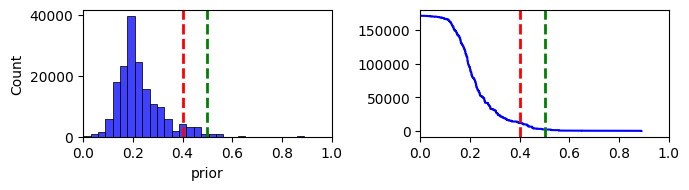

Observation 1


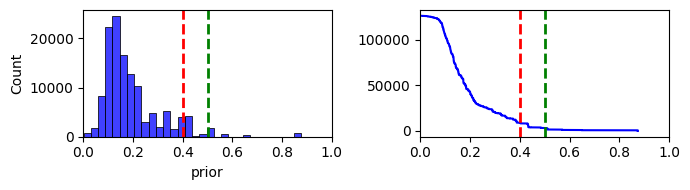

Observation 2


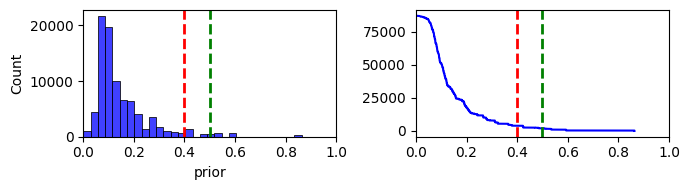

Observation 3


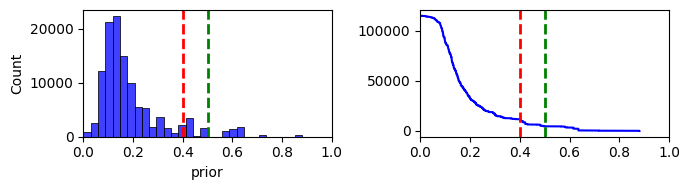

Observation 4


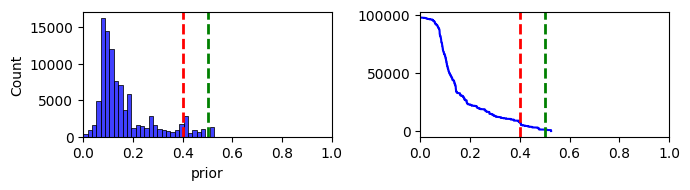

Observation 5


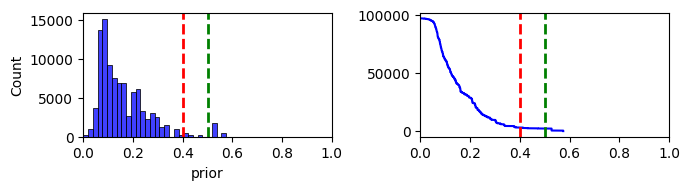

Observation 6


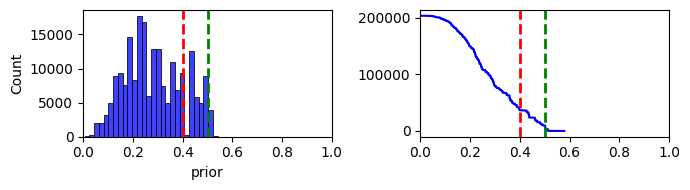

Cluster  1
Observation 0


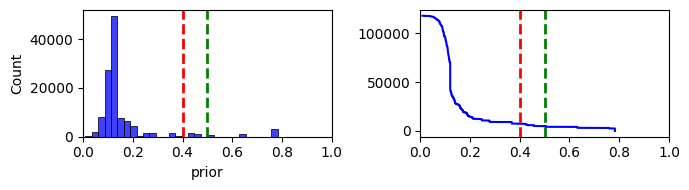

Observation 1


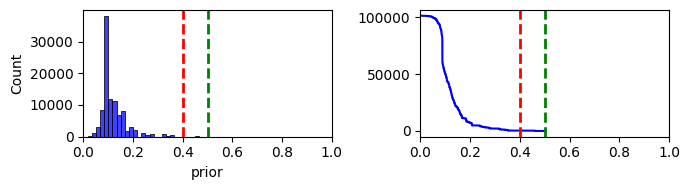

Observation 2


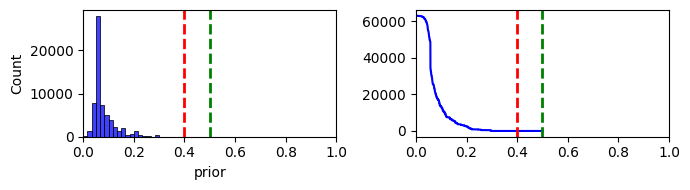

Observation 3


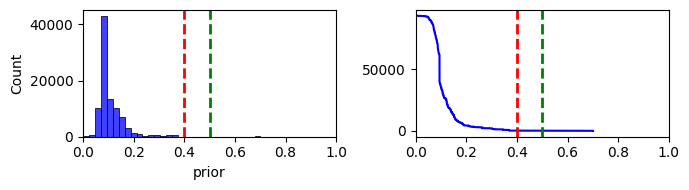

Observation 4


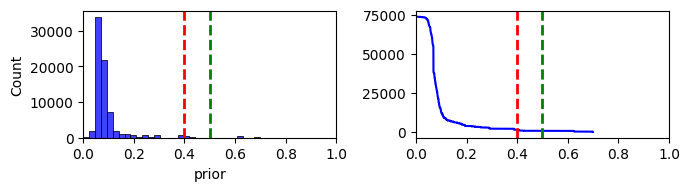

Observation 5


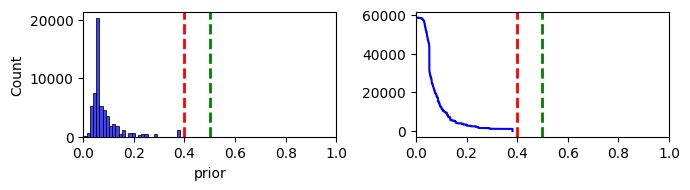

Observation 6


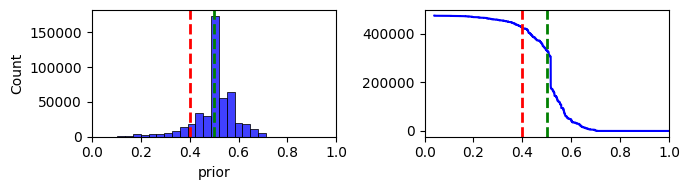

Cluster  2
Observation 0


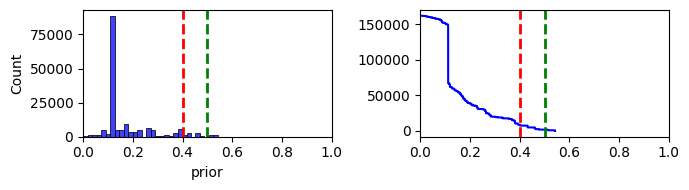

Observation 1


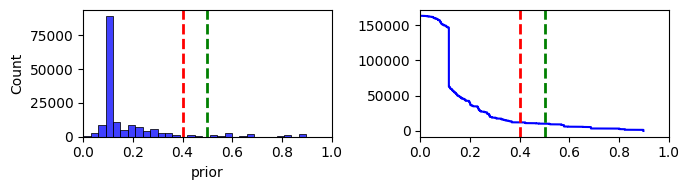

Observation 2


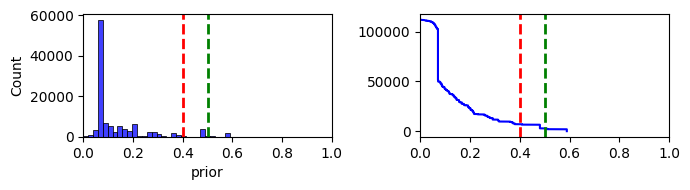

Observation 3


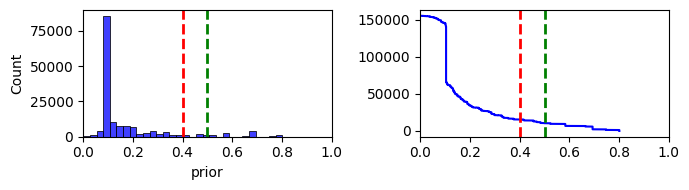

Observation 4


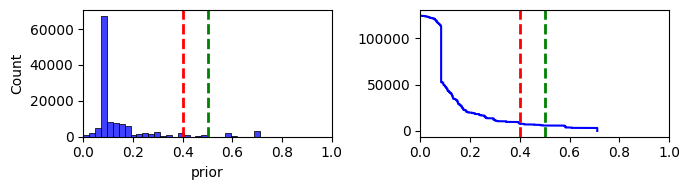

Observation 5


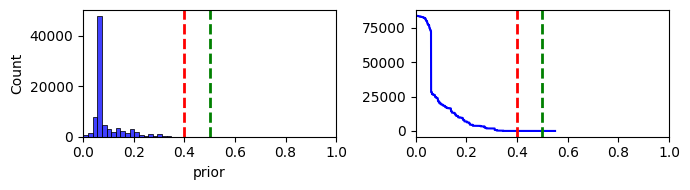

Observation 6


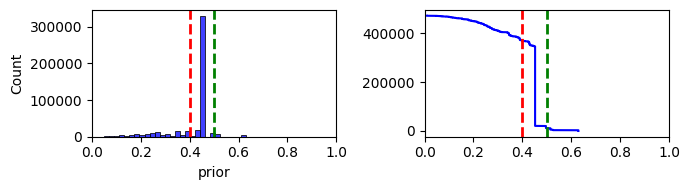

Cluster  3
Observation 0


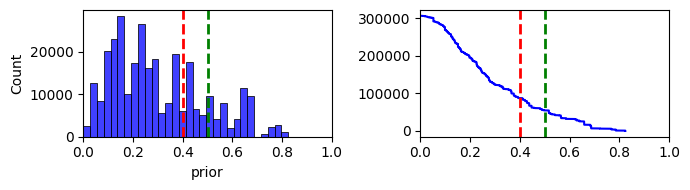

Observation 1


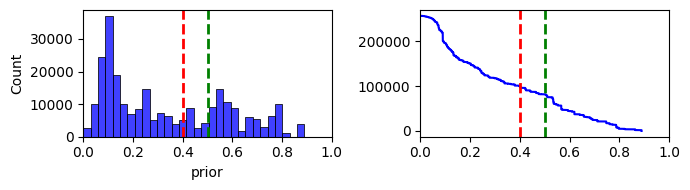

Observation 2


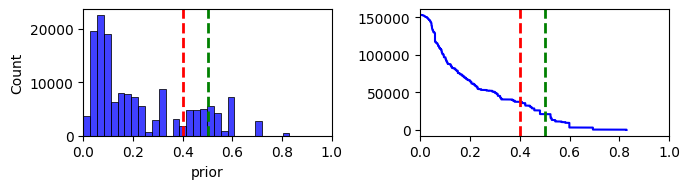

Observation 3


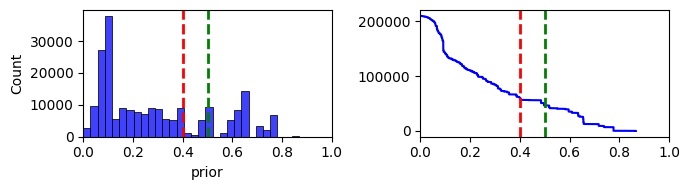

Observation 4


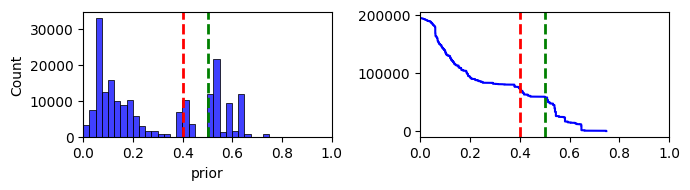

Observation 5


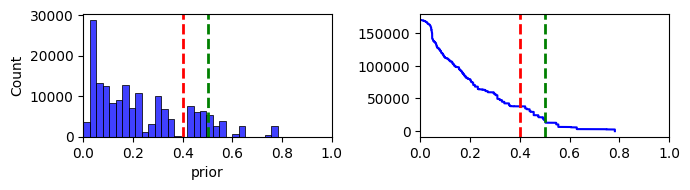

Observation 6


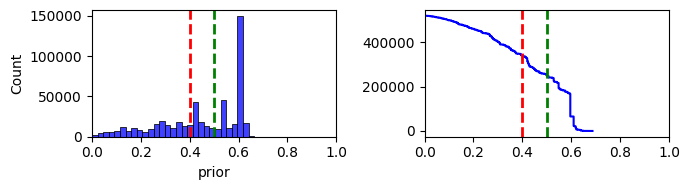

Cluster  4
Observation 0


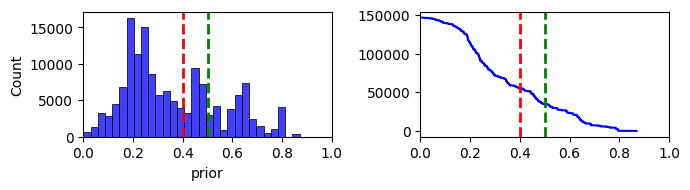

Observation 1


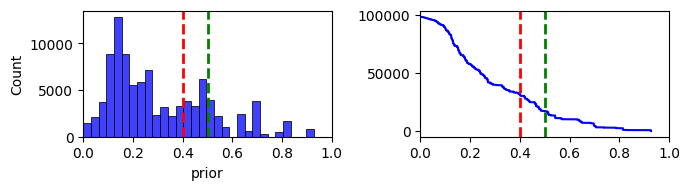

Observation 2


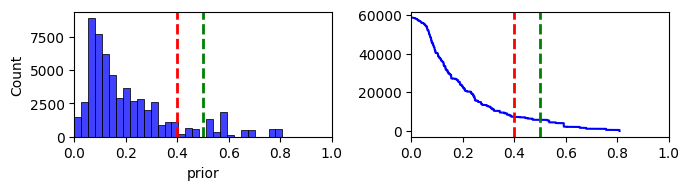

Observation 3


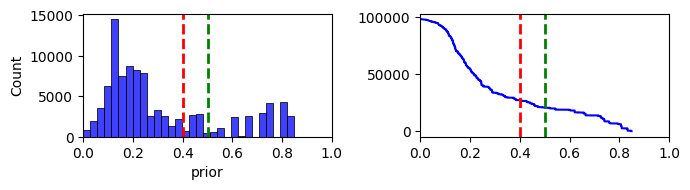

Observation 4


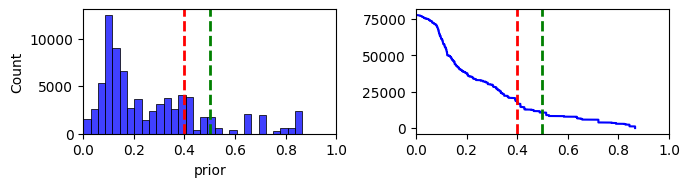

Observation 5


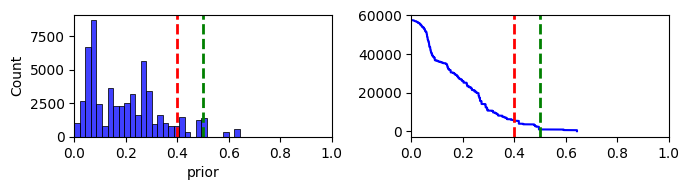

Observation 6


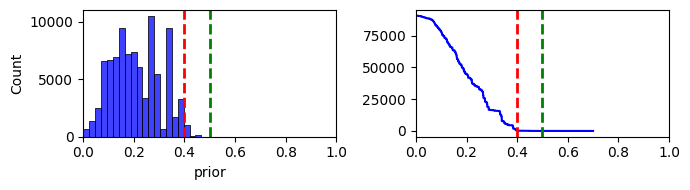

In [14]:
observation = np.sort(df_all_winner.to_pandas().observation.unique())
for cl in np.sort(clusters):
    print('Cluster ',cl)
    for obs in observation:
        print('Observation',obs)
        pl_cl_hist=df_all_winner.filter(pl.col('cluster_data')==cl).filter(pl.col('observation')==obs).to_pandas()
        fig, axs = plt.subplots(1, 2, figsize=(7,2))
        sns.histplot(pl_cl_hist['prior'], bins=30, kde=False, color='blue', edgecolor='black',cumulative=False,ax=axs[0])

        sorted_data = np.sort(pl_cl_hist['prior'])
        cdf = np.arange(1, len(sorted_data) + 1) 
        inverse_cdf = len(sorted_data) - cdf
        axs[1].plot(sorted_data, inverse_cdf, label="Inverse Cumulative", color='blue')

        
        
        #sns.histplot(pl_cl_hist['prior'], cumulative=True, kde=False, stat="density", color="red", 
        #             label="Inverse Cumulative",ax=axs[1])\
        # .lines[-1].set_ydata(
        #     1 - sns.histplot(pl_cl_hist['prior'], cumulative=True, kde=False, stat="density").lines[-1].get_ydata())
        #sns.histplot(pl_cl_hist['prior'], bins=30, kde=False, color='blue', edgecolor='black',cumulative=True,ax=axs[1])
        axs[0].set_xlim(0,1)
        axs[1].set_xlim(0,1)    
        axs[0].axvline(x=0.4,color='red', linestyle='--', linewidth=2)
        axs[0].axvline(x=0.5,color='green', linestyle='--', linewidth=2)
        axs[1].axvline(x=0.4,color='red', linestyle='--', linewidth=2)
        axs[1].axvline(x=0.5,color='green', linestyle='--', linewidth=2)
        plt.tight_layout()
        plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_by_prior_som_{cl}.png", dpi=300, bbox_inches='tight')
        plt.show()

In [15]:
print('pivot_table')
print(df_all_winner.to_pandas().pivot_table(
    values='idpoint',
    columns='observation',
    index='cluster_data',
    aggfunc='count',
    fill_value=0
))

print('filtering_based on prior 0.5')
print(df_all_winner.filter(pl.col('prior')>=0.5).to_pandas().pivot_table(
    values='idpoint',
    columns='observation',
    index='cluster_data',
    aggfunc='count',
    fill_value=0
))


print('filtering_based on prior 0.4')
print(df_all_winner.filter(pl.col('prior')>=0.3).to_pandas().pivot_table(
    values='idpoint',
    columns='observation',
    index='cluster_data',
    aggfunc='count',
    fill_value=0
))

pivot_table


observation        0       1       2       3       4       5       6
cluster_data                                                        
0             171175  126225   87250  114850   97650   97075  203325
1             118125  101425   62975   93225   73775   58575  473900
2             161850  163275  111975  155575  124350   83650  472225
3             307250  257175  153125  210300  194525  170200  520400
4             146450   98175   58625   98575   77900   57525   90600
filtering_based on prior 0.5


observation       0      1      2      3      4      5       6
cluster_data                                                  
0              2407   3341   2053   4660   1319   2253    9839
1              5067      2      2    206    742      0  331335
2              1948  10397   2835  10793   5890     22   11550
3             54936  82026  21119  46635  59331  17445  253191
4             34930  16975   5815  20821  10705    896      33
filtering_based on prior 0.4


observation        0       1      2      3      4      5       6
cluster_data                                                    
0              30354   20761   7961  16297  13133   9677   79741
1               9248    2142      2   2161   2103   1156  457496
2              20122   18954  11678  21403  12043   1865  411222
3             123943  117880  49326  84522  81465  57222  404017
4              72168   39777  12669  33839  29915  10654   16448


In [16]:
df_train_2=[]
for cl in np.sort(clusters):
    for obs in observation:
        dls=[]
        cl_obs=df_all_winner.filter(pl.col('cluster_data')==cl).filter(pl.col('observation')==obs)\
            .filter(pl.col('prior')>=.4)#.to_pandas()
        if cl_obs.shape[0]>=20000:
            cl_obs=cl_obs.sample(20000,with_replacement=False)#.to_pandas()
        dls.append(cl_obs.to_pandas())
        if cl_obs.shape[0]<10000:
            nsample=10000-cl_obs.shape[0]
            cl_tambahan=df_all_winner.filter(pl.col('cluster_data')==cl).filter(pl.col('observation')==obs)\
            .filter(pl.col('prior')<.4)
            if cl_tambahan.shape[0]<nsample:
                cl_tambahan=cl_tambahan.to_pandas()
            else:
                cl_tambahan=cl_tambahan.sample(nsample,with_replacement=False).to_pandas()
            dls.append(cl_tambahan)
        dls=pd.concat(dls)
        df_train_2.append(dls)

In [17]:
df_train_2=pl.from_pandas(pd.concat(df_train_2))

In [18]:
df_train_2.shape

(499468, 8)

In [19]:
#df_train_2=df_train_2.join(df_training_vh,on=['idpoint','idsubsegment','idsegment','periode','observation',
# 'cluster_data'],how='inner')

In [20]:
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','wb') as file:
    pickle.dump(df_train_2,file)

In [21]:
dfx=df_training_vh.to_pandas()
dfy=df_train_2.to_pandas()

In [22]:
u=dfx.merge(dfy).drop_duplicates()

In [23]:
print(u.pivot_table(
    values='idpoint',
    columns='observation',
    index='cluster_data',
    aggfunc='count',
    fill_value=0
))

observation       0      1      2      3      4      5      6
cluster_data                                                 
0              8990   7541   9287  10057   8824   8563  15546
1              6657   9417   9299   9504   8901   9233  19647
2              5957   6996   6864   8783   6647   9659  19925
3             17724  18130  17236  18093  17937  14871  19568
4             16316  15931   9315  16527  13114   7812   9393


In [24]:

with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','wb') as file:
    pickle.dump(u,file)

In [25]:
df_som_pict=df_all_winner.to_pandas().pivot_table(
    index=['cluster_data','winner'],
    columns='observation',
    values='idpoint',
    aggfunc='count'
).fillna(0).reset_index()

In [26]:
df_som_pict

observation,cluster_data,winner,0,1,2,3,4,5,6
0,0,R0C0,727.0,884.0,694.0,764.0,458.0,425.0,1835.0
1,0,R0C1,124.0,52.0,36.0,43.0,50.0,46.0,265.0
2,0,R0C10,85.0,398.0,816.0,367.0,29.0,31.0,202.0
3,0,R0C11,93.0,191.0,42.0,7.0,10.0,200.0,82.0
4,0,R0C12,355.0,282.0,176.0,326.0,161.0,206.0,591.0
...,...,...,...,...,...,...,...,...,...
1649,4,R9C5,691.0,161.0,191.0,468.0,151.0,58.0,574.0
1650,4,R9C6,1182.0,570.0,433.0,783.0,506.0,220.0,1843.0
1651,4,R9C7,38.0,457.0,185.0,67.0,0.0,67.0,73.0
1652,4,R9C8,259.0,19.0,34.0,110.0,31.0,16.0,101.0


Cluster 0


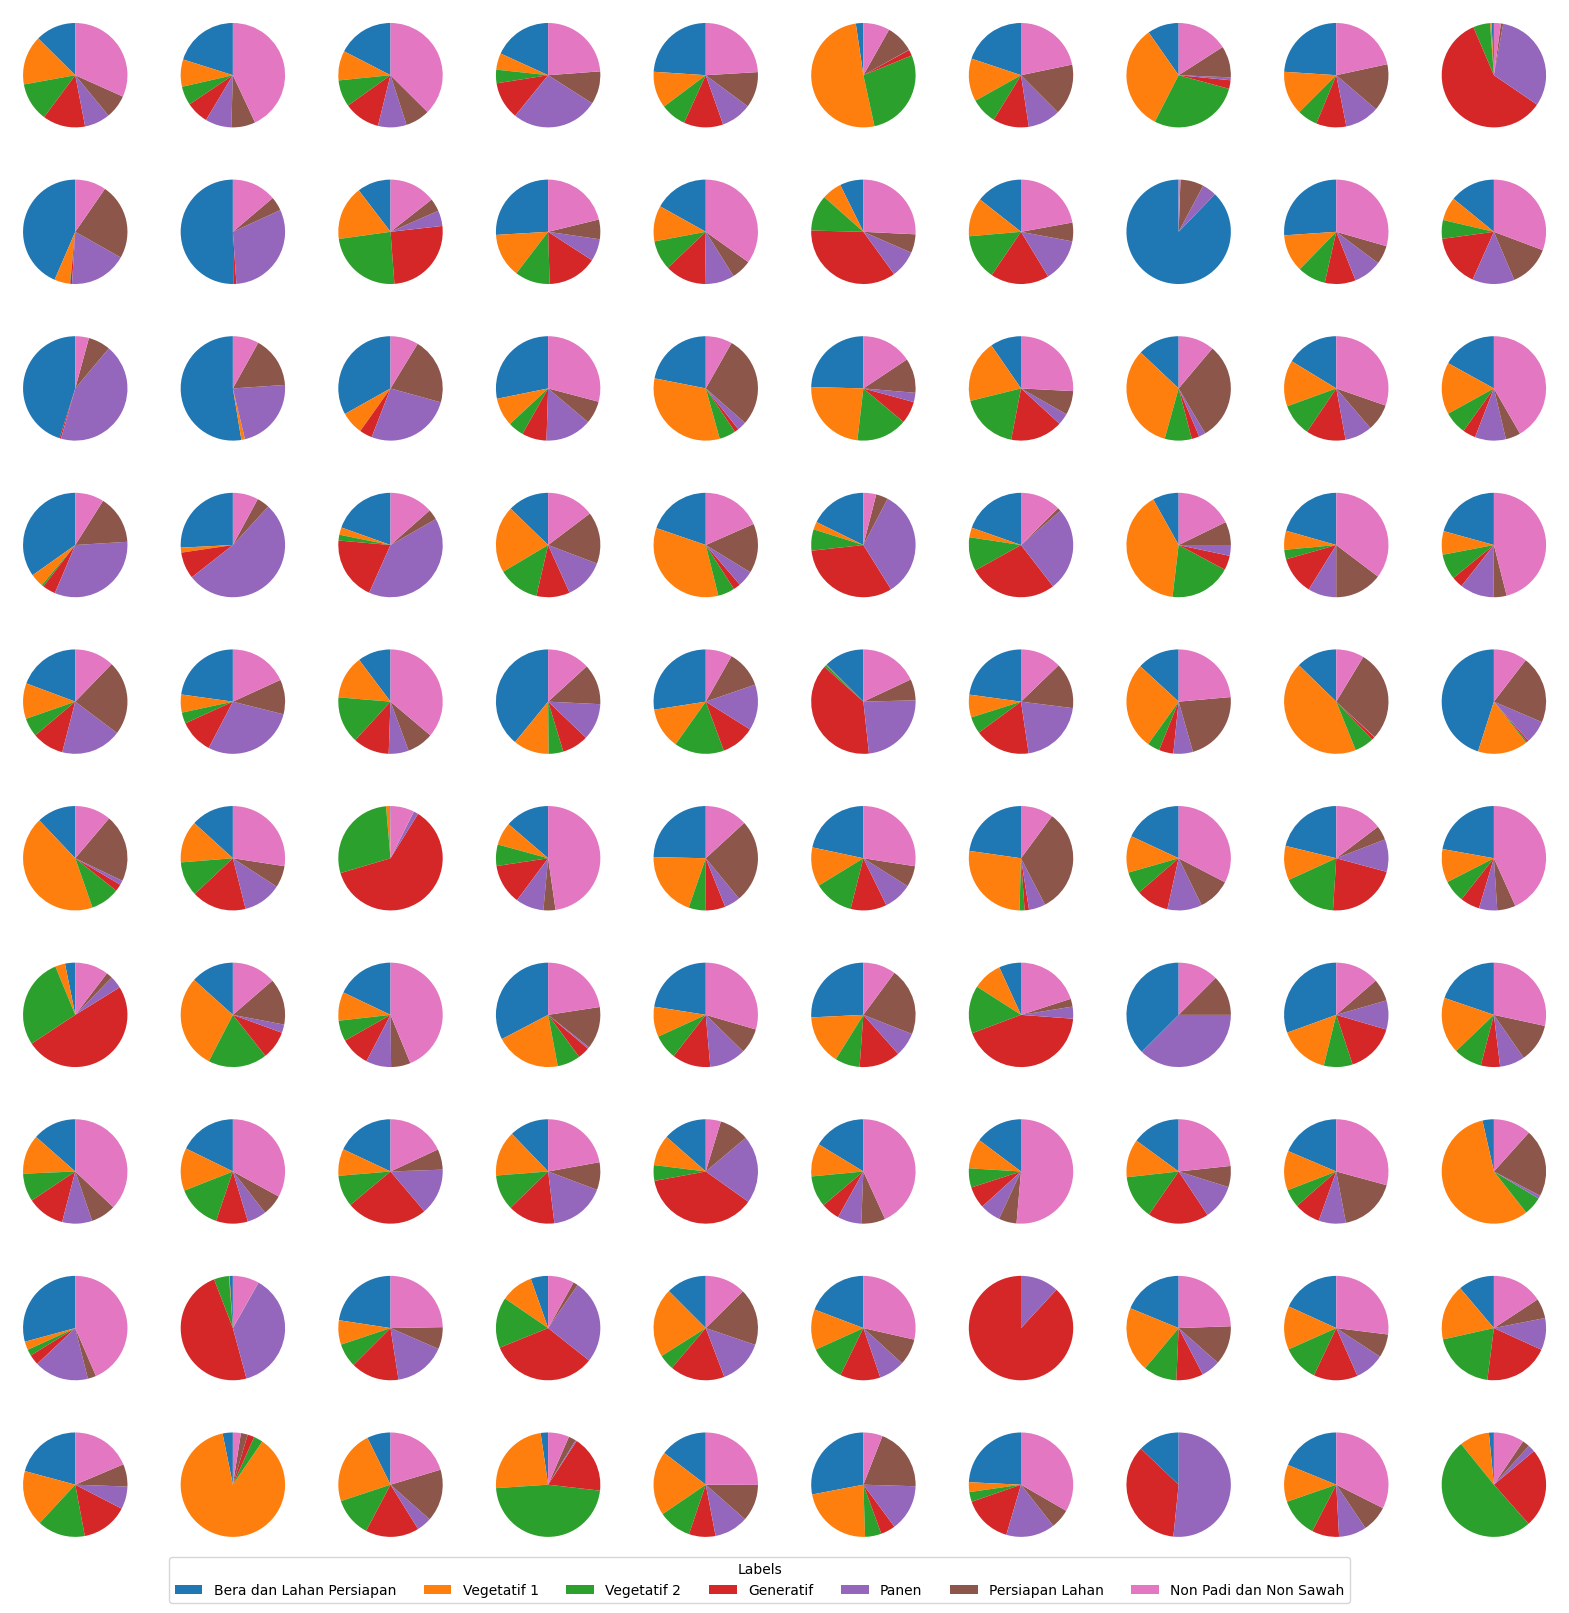

Cluster 1


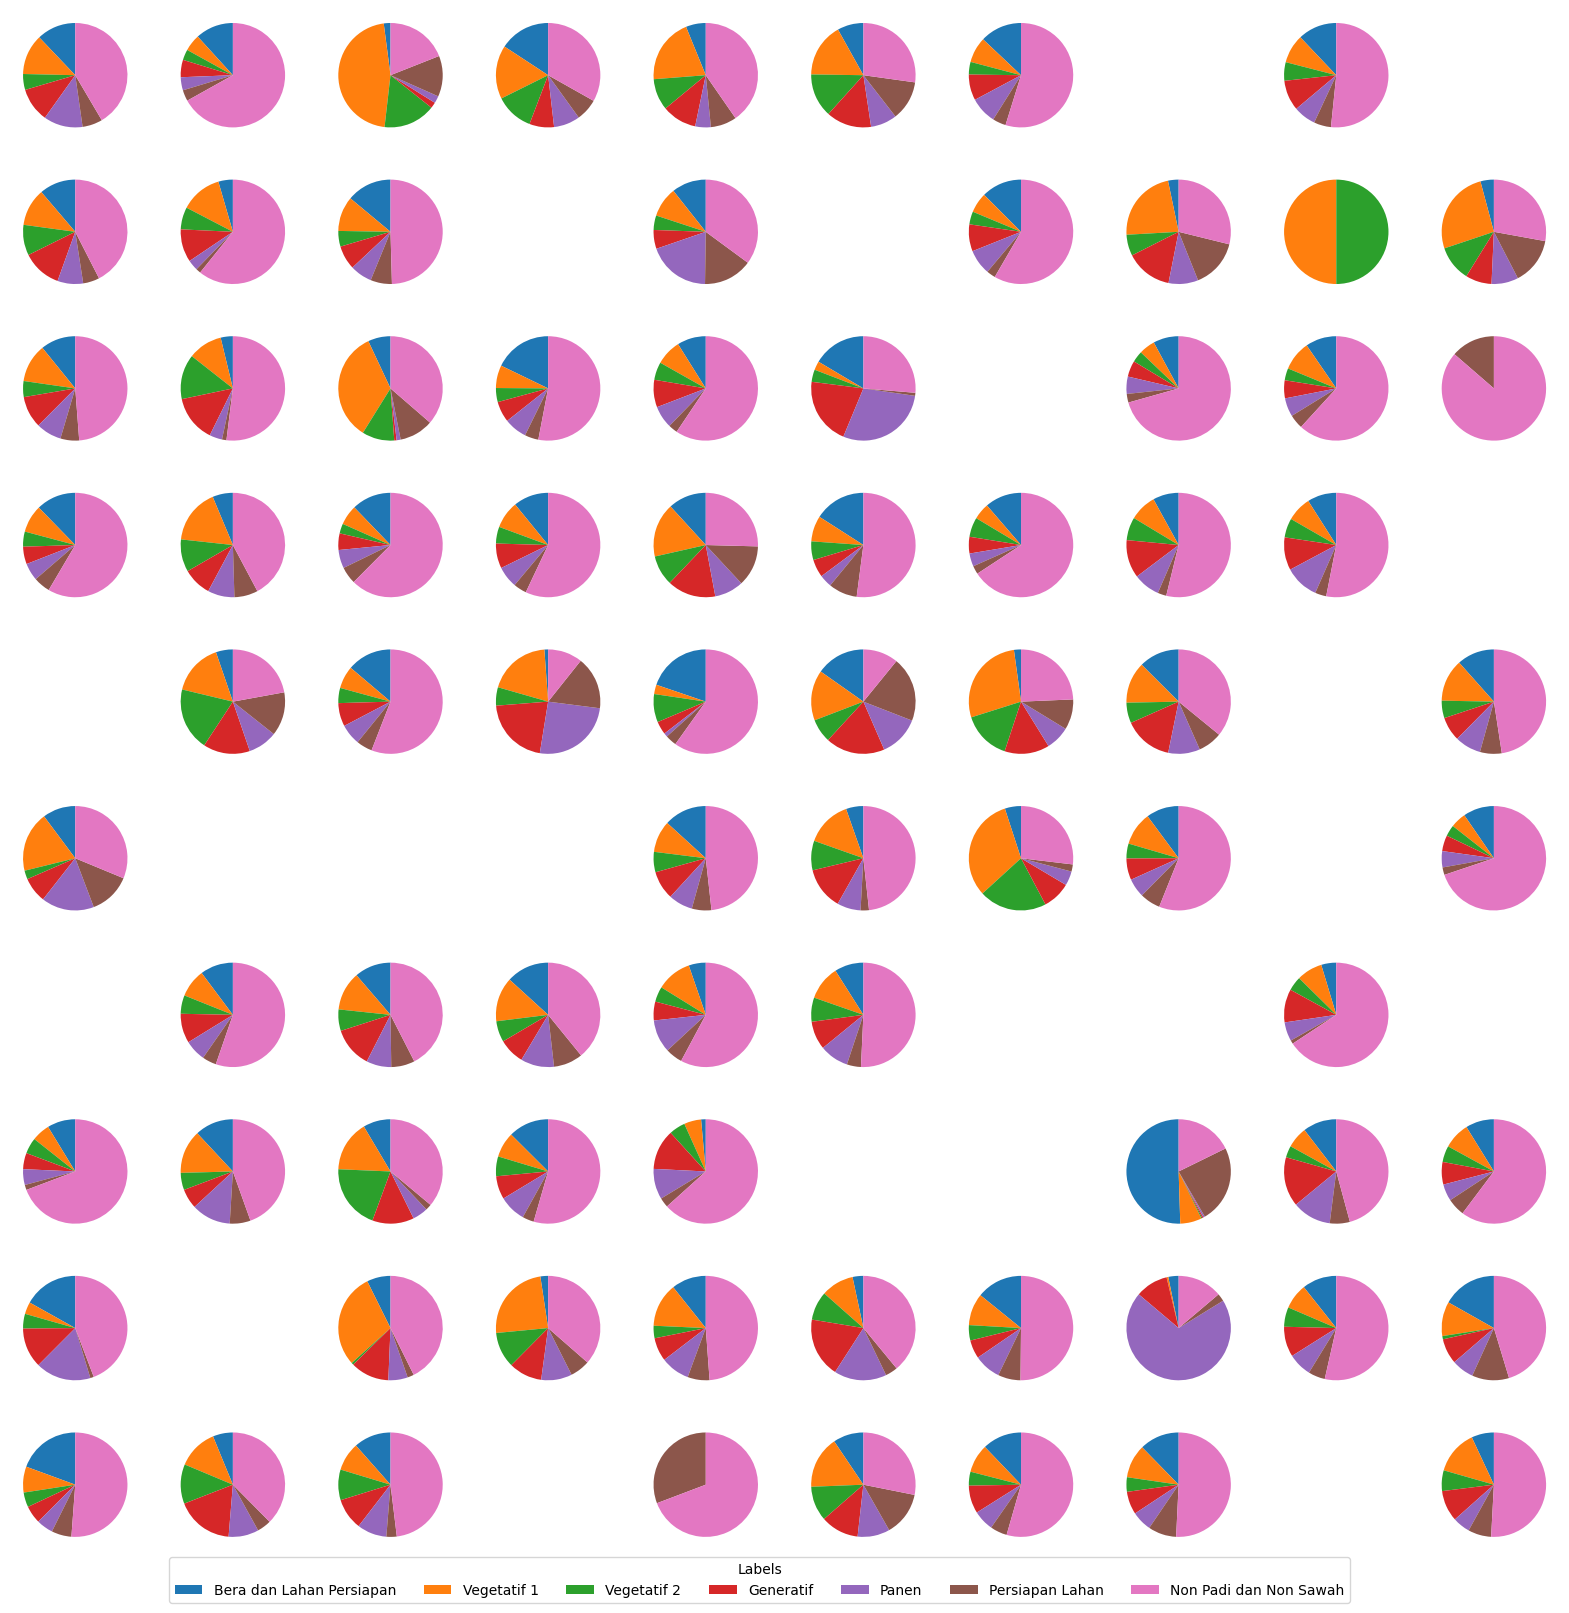

Cluster 2


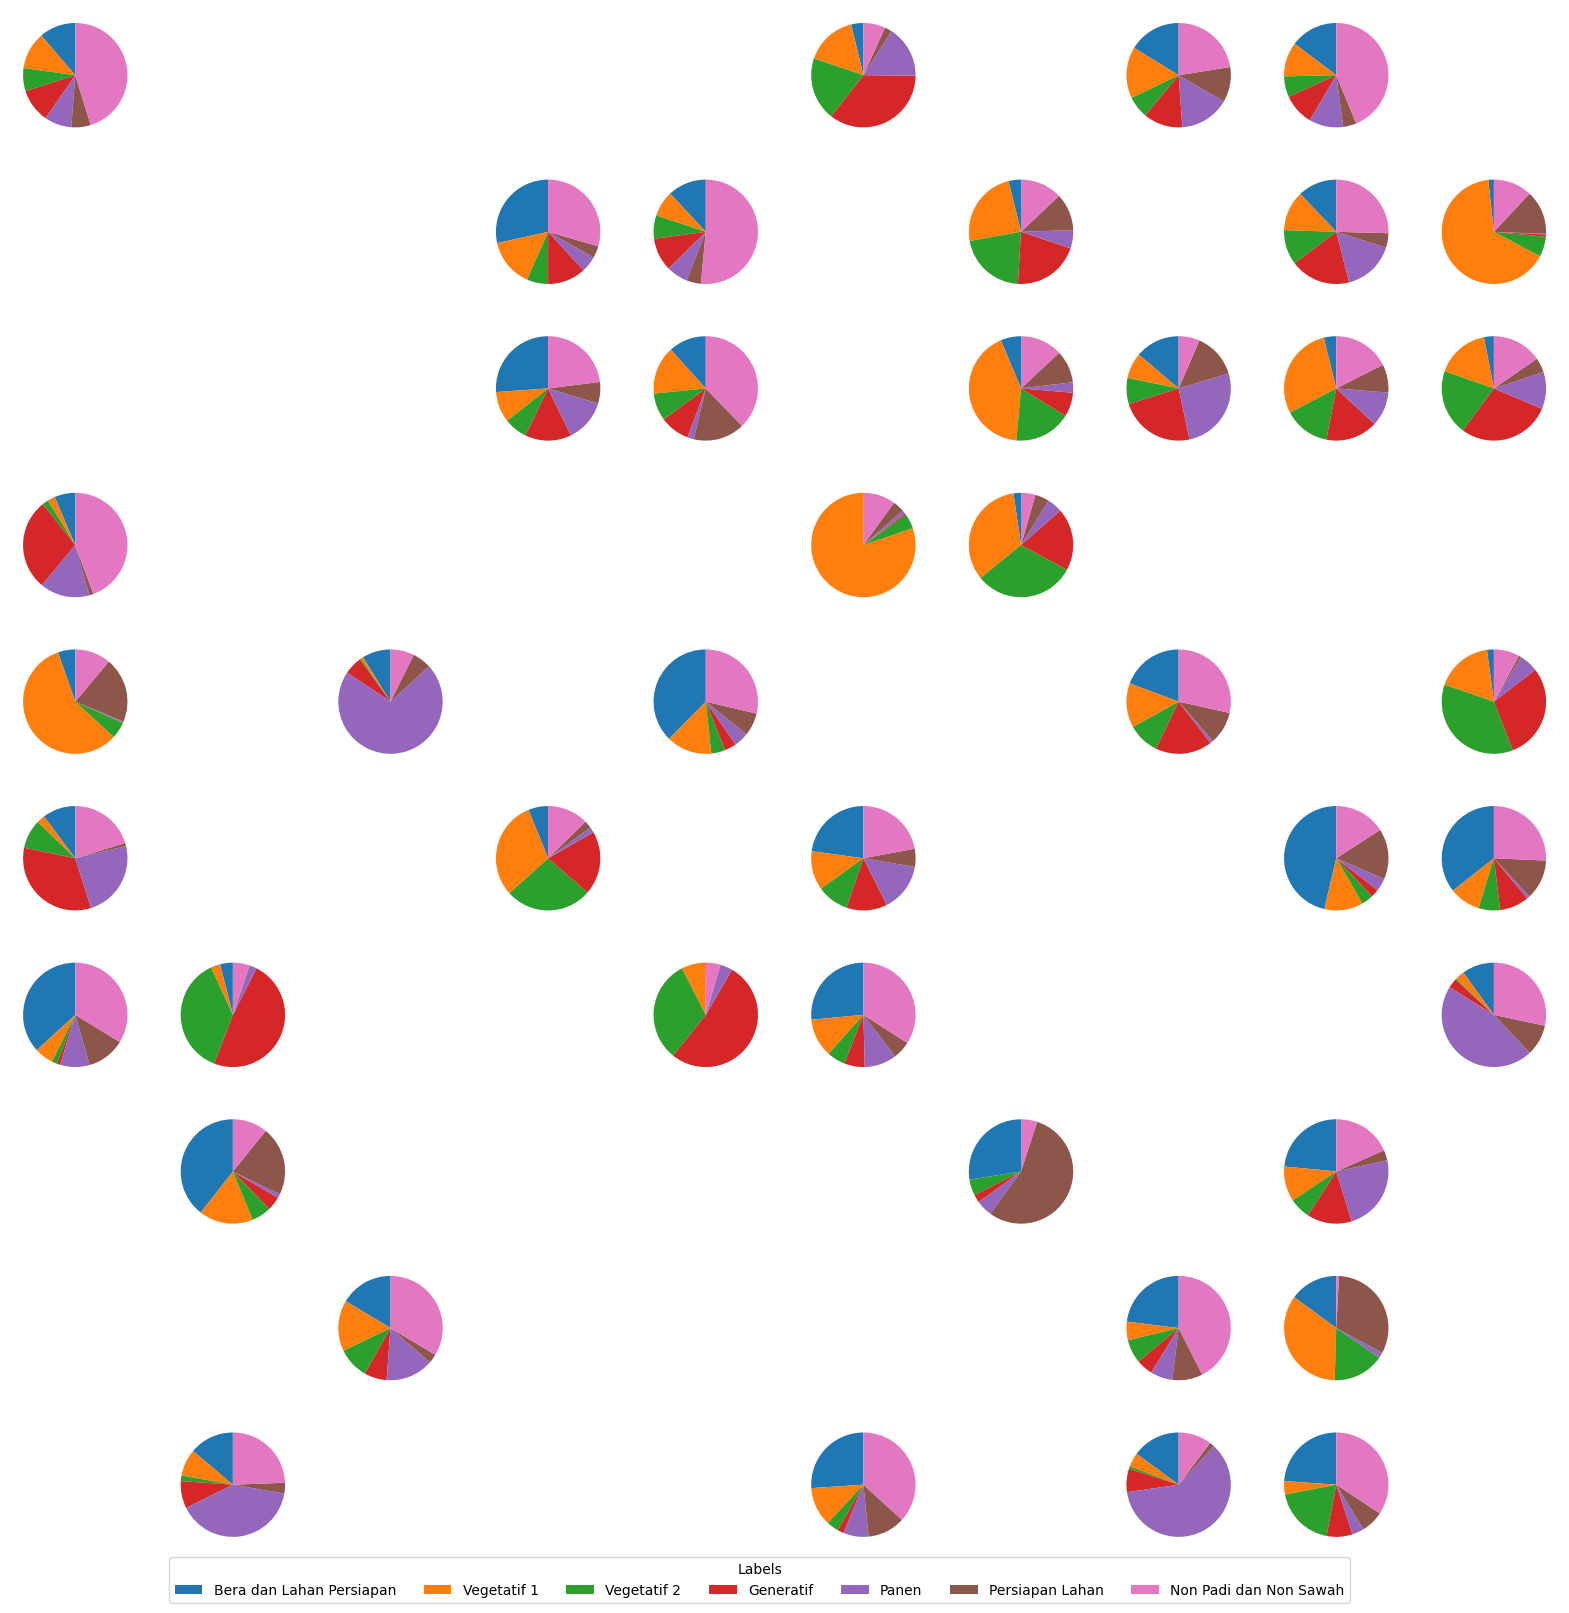

Cluster 3


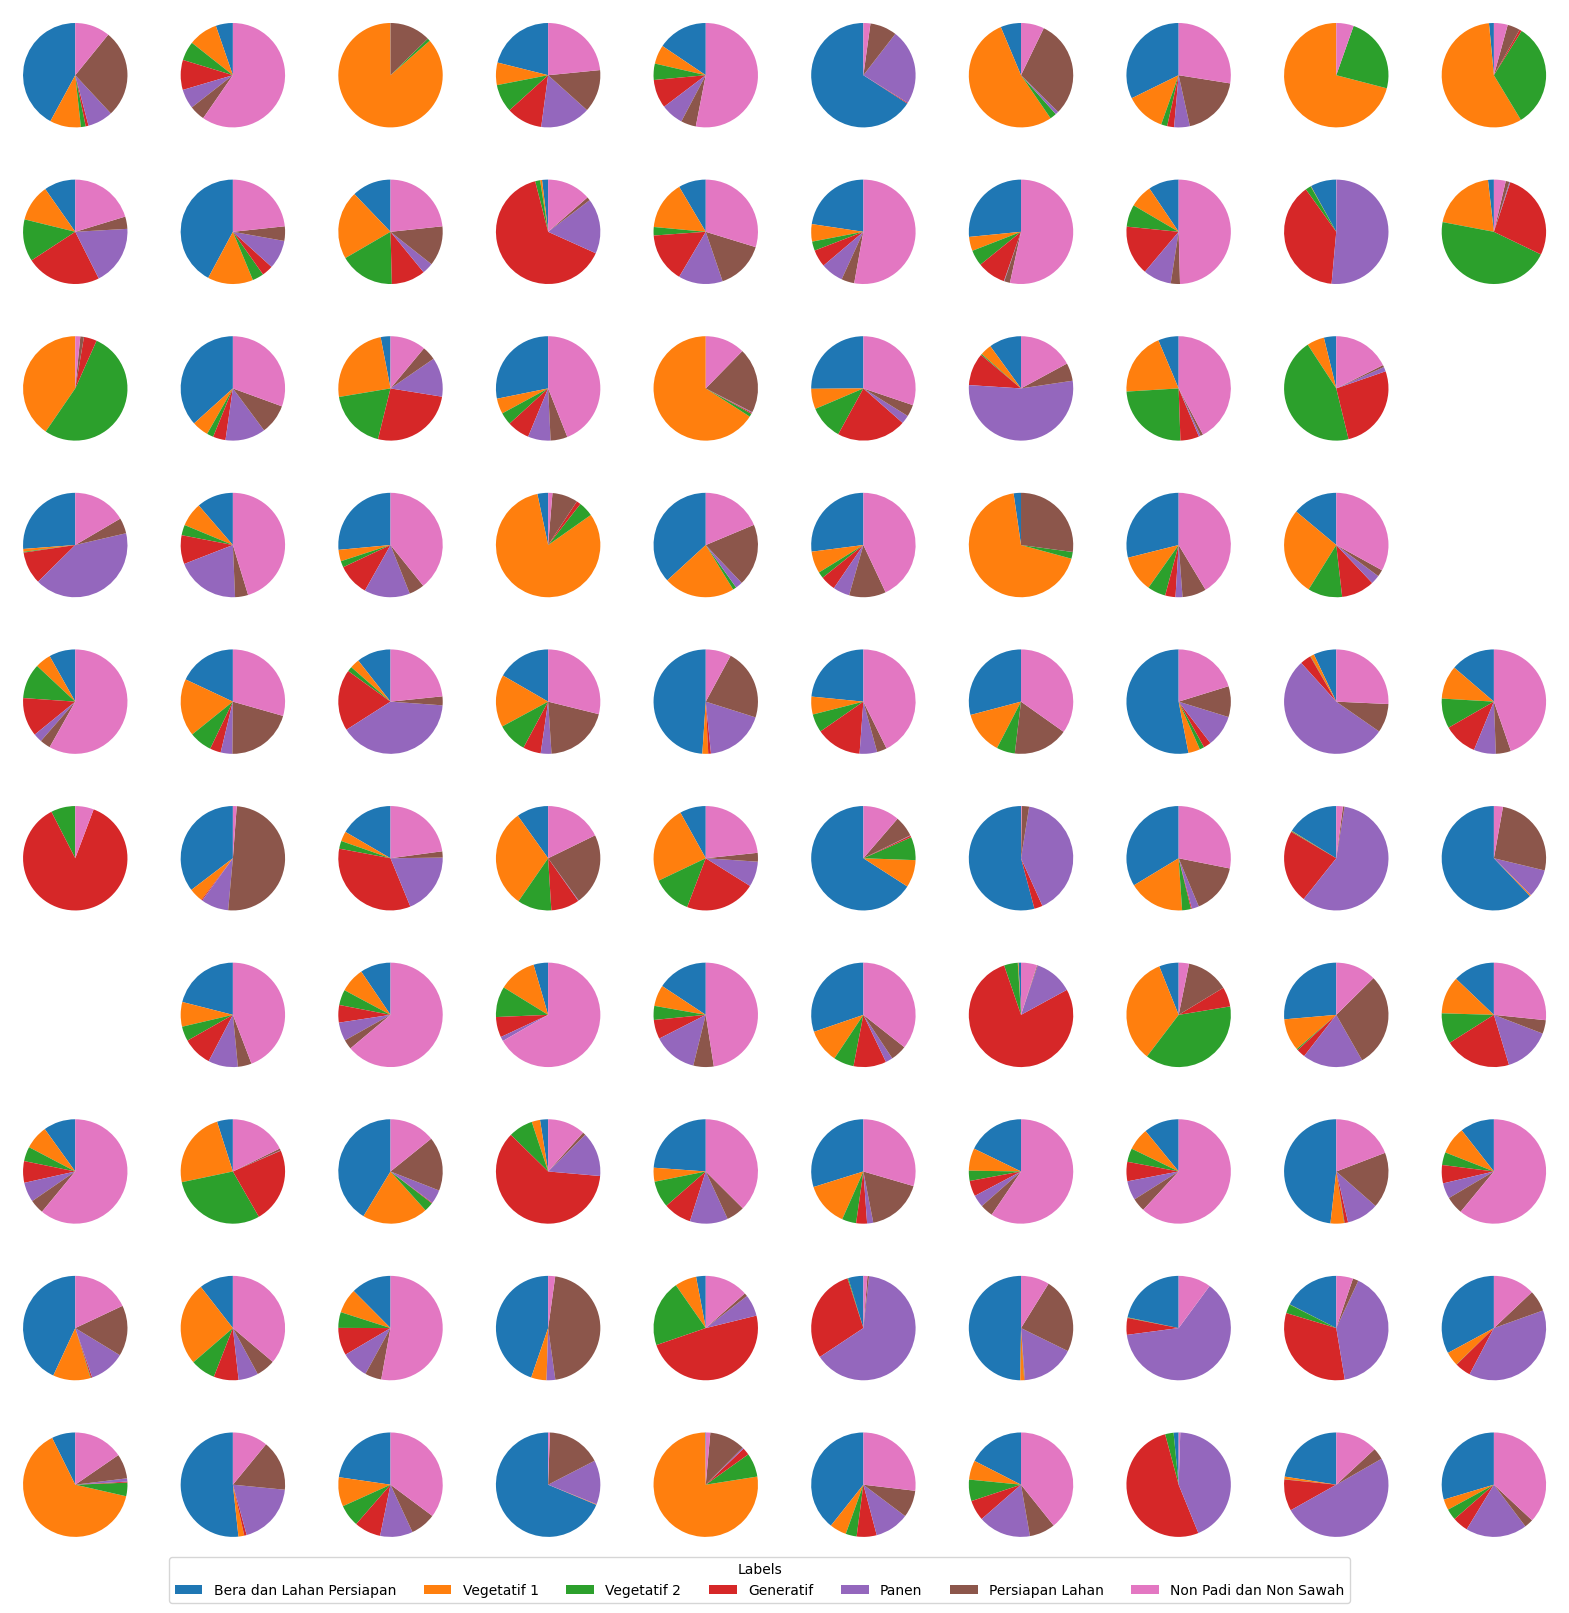

Cluster 4


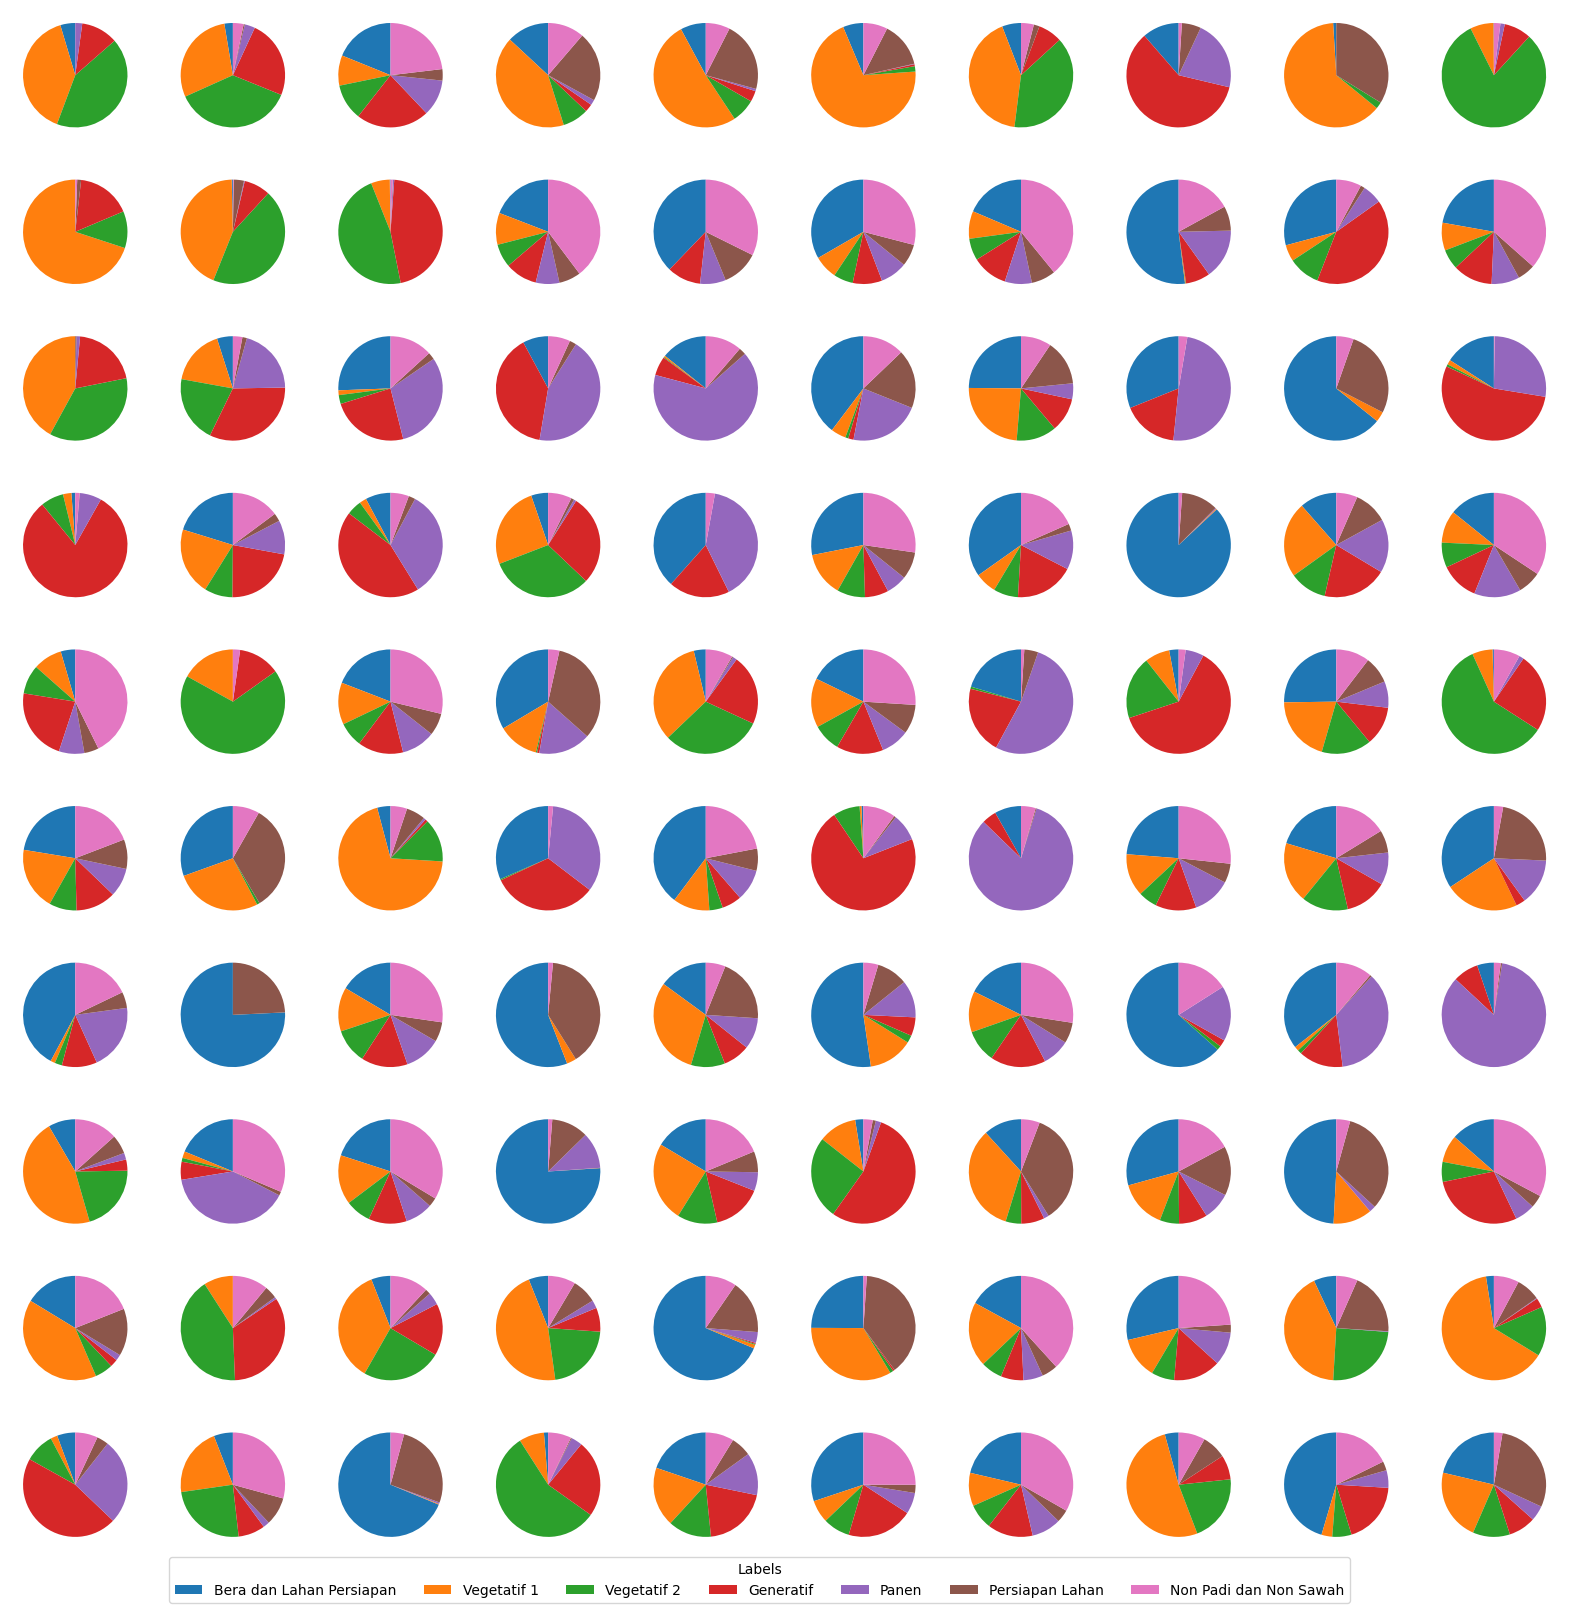

In [27]:
from matplotlib.gridspec import GridSpec

# Assuming df_som_pict and range(7) are defined elsewhere
for cl in df_som_pict['cluster_data'].unique():
    print('Cluster', cl)
    
    # Filter data for the current cluster once outside the loop
    cluster_data = df_som_pict[df_som_pict['cluster_data'] == cl]
    
    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(10, 10, figure=fig)

    # Precompute all winners to avoid excessive queries
    winners = cluster_data.set_index('winner')

    # Define labels for all pies (the same for all charts)
    pie_labels = np.array(range(7))
    wedges_for_legend = None  # Store wedges for later legend creation

    for i in range(10):
        for j in range(10):
            som_dt = f'R{i}C{j}'
            
            # Use pre-filtered 'winners' DataFrame for the current winner
            if som_dt in winners.index:
                dfx = winners.loc[som_dt]
                
                # Convert to numpy array if necessary, just a single row, no need to query the shape
                data = dfx[range(7)].values
                
                # Plot only if data is non-empty
                if data.size > 0:
                    ax = fig.add_subplot(gs[i, j])
                    
                    # Remove annotation, just plot the pie chart
                    wedges, texts = ax.pie(data, labels=None, startangle=90)
                    
                    # Store the wedges for the first pie chart to use in the global legend
                    if wedges_for_legend is None:
                        wedges_for_legend = wedges

    if wedges_for_legend is not None:
        fig.legend(wedges_for_legend, ['Bera dan Lahan Persiapan','Vegetatif 1','Vegetatif 2','Generatif',
                                      'Panen','Persiapan Lahan','Non Padi dan Non Sawah'], title="Labels", loc="lower center", 
                   bbox_to_anchor=(0.5, 0.08),
                   ncol=len(pie_labels))
    
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_som_neuron_{cl}.png", dpi=300, bbox_inches='tight')
    plt.show()